<br>

<br>

# This next cell contains methods for generating data for training the feature extractor and data for environments 1, 2, and 3 by adding color to the MNIST images and binarizing the image labels.

In [1]:

import numpy as np
import struct
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import torch
from torchvision import datasets
from torch import nn, optim, autograd
import pandas as pd
from numpy import vstack
from numpy import argmax
from pandas import read_csv
from sklearn.metrics import accuracy_score
from torchvision.datasets import MNIST
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torch.utils.data import DataLoader
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.optim import Adam
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
from scipy import stats



# Download and split MNIST data
mnist = datasets.MNIST('~/datasets/mnist', train=True, download=True)
mnist_train = (mnist.data[:40000], mnist.targets[:40000])
mnist_test = (mnist.data[40000:], mnist.targets[40000:])
mnist_all = (mnist.data, mnist.targets)

#Shuffle the data
rng_state = np.random.get_state()
np.random.shuffle(mnist_train[0].numpy())
np.random.set_state(rng_state)
np.random.shuffle(mnist_train[1].numpy())

rng_state = np.random.get_state()
np.random.shuffle(mnist_all[0].numpy())
np.random.set_state(rng_state)
np.random.shuffle(mnist_all[1].numpy())

# Splitting the data that will be used to train the feature extractor 
# into 80% train set and 20% test set
X_train = mnist_all[0][:int(0.8*len(mnist_all[0]))] 
y_train = mnist_all[1][:int(0.8*len(mnist_all[1]))] 
X_test = mnist_all[0][int(0.8*len(mnist_all[0])):]
y_test = mnist_all[1][int(0.8*len(mnist_all[1])):]


# used to binarize the target variable
def binarize(y, label_noise=0.):
    
    y = np.copy(y) > 4
    
    if label_noise > 0:
        y = np.logical_xor(y, np.random.binomial(1, label_noise, size=len(y)))
    
    return y.astype(int)

# used to randomly add color to the dataset used to train the feature extractor
def color_digits(X, y, color_noise=None, downsample=True):    
    if downsample:
        X = np.copy(X)[:,::2,::2]
    
    if color_noise is None:
        color = np.random.choice([True, False], size=len(y))
    else:
        color = np.logical_xor(y, np.random.binomial(1, color_noise, size=len(y)))
    colored_X = np.repeat(X[:,None,:,:],2,axis=1)
    colored_X[color,0,:,:] = 0
    colored_X[~color,1,:,:] = 0    
    colored_X = colored_X.reshape(X.shape[0],-1)    
    return (colored_X.astype(float)/ 255.), color.astype(int)



# used to color either the entire dataset green or the entire dataset red
def color_all_images_same_color(X, green=True, downsample=True):    
    if downsample:
        X = np.copy(X)[:,::2,::2]
        
    if green:
        colored_X = np.repeat(X[:,None,:,:],2,axis=1)
        colored_X[:,0,:,:] = 0
    else:
        colored_X = np.repeat(X[:,None,:,:],2,axis=1)
        colored_X[:,1,:,:] = 0
   
    colored_X = colored_X.reshape(X.shape[0],-1)    
    return (colored_X.astype(float)/ 255.)


# Produce images for the factor model
def produce_images_for_the_factor_model(X, green=True, downsample=True):    
    if downsample:
        X = np.copy(X)[:,::2,::2]
    color = None    
    if green:
        color = np.ones(len(X))
        colored_X = np.repeat(X[:,None,:,:],2,axis=1)
        colored_X[:,0,:,:] = 0
    else:
        color = np.zeros(len(X))
        colored_X = np.repeat(X[:,None,:,:],2,axis=1)
        colored_X[:,1,:,:] = 0
   
    colored_X = colored_X.reshape(X.shape[0],-1)    
    return (colored_X.astype(float)/ 255.), color.astype(int)


# Used to generate environments 1, 2, and 3 by varying the distribution of color
def generate_environments(X, y, color_noise=None, downsample=True):    
    if downsample:
        X = np.copy(X)[:,::2,::2]
    
    if color_noise is None:
        color = np.random.choice([True, False], size=len(y))
    else:
        color = np.logical_xor(y, np.random.binomial(1, color_noise, size=len(y)))
    colored_X = np.repeat(X[:,None,:,:],2,axis=1)
    colored_X[color,0,:,:] = 0
    colored_X[~color,1,:,:] = 0
    
    colored_X = colored_X.reshape(X.shape[0],-1)
    
    return {
      'images': (colored_X.astype(float) / 255.),
      'labels': y[:, None],
      'colors': color[:, None]
    }

    
    
# Used to plot colored images    
def plot_images(X, n_row=10, n_col=10, shape=(2,14,14), scale=False):
    fig = plt.figure(figsize=(n_row, n_col))
    grid = ImageGrid(fig, 111,  
                     nrows_ncols=(n_row, n_col),  # creates 2x2 grid of axes
                     axes_pad=0.05,  # pad between axes in inch.
                     )
    for ax in grid:
        index = np.random.choice(np.arange(X.shape[0]))
        img = X[index].reshape(shape)
        if scale:
            img = img - img.min()
            img /= img.max()
        img = np.vstack((img, np.zeros((1,shape[1],shape[2]))))
        img = np.moveaxis(img, 0, -1)
        ax.imshow(img)
        ax.set_axis_off()
    plt.show()
    return

<br>

# Define, train, and evaluate the feature extractor

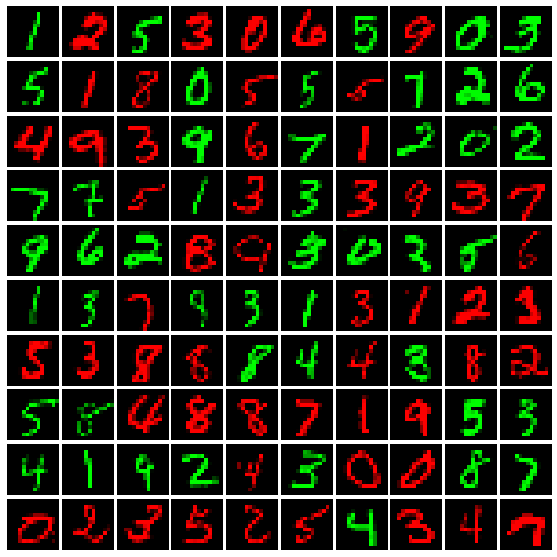

Sequential(
  (0): Linear(in_features=392, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=2, bias=True)
)
Label Accuracy:  0.94725
Color Accuracy:  1.0


In [2]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

class MLP(torch.nn.Module):

    def __init__(self, size=[2*14*14, 2]):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(size)-2):
            layers.append(torch.nn.Linear(size[i], size[i+1]))
            layers.append(torch.nn.ReLU())
        layers.append(torch.nn.Linear(size[-2], size[-1]))
        self.net = torch.nn.Sequential(*layers)
        print(self.net)

    def forward(self, x):
        return self.net(x)

def tensor_numpy(arrays, device):
    out = []
    for a in arrays:
        out.append(torch.from_numpy(a).float().to(device))
    return out
    
    
np.random.seed(1)
label_noise = 0.
color_noise = None

y_train = binarize(y_train, label_noise=label_noise)
y_test = binarize(y_test, label_noise=label_noise)

X_train, color_train = color_digits(X_train, y_train, color_noise, downsample=True)
X_test, color_test = color_digits(X_test, y_test, color_noise, downsample=True)

plot_images(X_train)
# plot_images(X_test)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

hidden_size = [2*14*14, 50, 2]
net = MLP(hidden_size).to(device)

tr_x, tr_y, tr_c = tensor_numpy([X_train, y_train, color_train], device)
te_x, te_y, te_c = tensor_numpy([X_test, y_test, color_test], device)

bs = 256

tr_dataset = TensorDataset(tr_x, tr_y, tr_c)
tr_loader = DataLoader(tr_dataset, batch_size = bs, shuffle = True)
# te_dataset = TensorDataset(te_x, te_y, te_c)
# te_loader = DataLoader(te_dataset, batch_size = bs, shuffle = True)

loss_label = torch.nn.BCEWithLogitsLoss()
loss_color = torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-5)

epoch = 10
for e in range(epoch):
    
    for x, y, c in tr_loader:
        
        optimizer.zero_grad()
        
        out = net(x)
        loss_y = loss_label(out[:,0], y)
        loss_c = loss_color(out[:,1], c)
        loss = loss_y + loss_c
        
        loss.backward()
        optimizer.step()
        
            
with torch.no_grad():
    test_preds = 1*(net(te_x).detach().cpu().numpy()>0)
#     acc_y = (test_preds[:,0] == y_test).mean()
#     acc_c = (test_preds[:,1] == color_test).mean()
    acc_y = accuracy_score(y_test, test_preds[:,0])
    acc_c = accuracy_score(color_test, test_preds[:,1])
    print('Label Accuracy: ', acc_y)
    print('Color Accuracy: ', acc_c)

<br>

# Use the trained feature extractor to extract features from data that will be used to train and test our classifiers

In [3]:
label_noise = 0.
color_noise = None


env1_X_train = mnist_train[0][::2]
env1_y_train = binarize(mnist_train[1][::2], label_noise=label_noise)

env2_X_train = mnist_train[0][1::2]
env2_y_train = binarize(mnist_train[1][1::2], label_noise=label_noise)

env3_X_train = mnist_test[0]
env3_y_train = binarize(mnist_test[1], label_noise=label_noise)

envs = [
generate_environments(env1_X_train, env1_y_train, 0.1),
generate_environments(env2_X_train, env2_y_train, 0.05),
generate_environments(env3_X_train, env3_y_train, 0.9)
]


class feature_extractor(nn.Module):
    def __init__(self):
        super().__init__()   
        net.eval()
        self.children_list = []
        for n,c in net.named_children():
            self.children_list.append(c)
            
        print("Printing all the trained model layers")
        print(self.children_list)
        self.children_list = self.children_list[0][:2]
        print("Printing model layers after dropping the output layer for feature extraction")    
        print(self.children_list)
        self.net = nn.Sequential(*self.children_list)
        self.pretrained = None
        
    def forward(self,x):
        x = self.net(x)
        return x


def extract_features(model,x,y, device = 'cpu'):
    extracted_features = []
    labels = []   
    with torch.no_grad():
        x = x.to(device)
        extracted_features = model(x.float())
    extracted_features = torch.flatten(extracted_features, 1)
    extracted_features_df = pd.DataFrame(extracted_features.numpy())
    extracted_features_df["target"] = y.cpu().numpy()
    return extracted_features_df



train_envs_1_and_2_inputs = torch.cat((torch.from_numpy(envs[0]['images']), torch.from_numpy(envs[1]['images'])), 0)
train_envs_1_and_2_targets = torch.cat((torch.from_numpy(envs[0]['labels']), torch.from_numpy(envs[1]['labels'])), 0)

print("Combined environments 1 and 2 data size - used to train our final prediction models")
print(len(train_envs_1_and_2_inputs))
print(len(train_envs_1_and_2_targets))

test_inputs =torch.from_numpy(envs[2]['images'])
test_targets =torch.from_numpy(envs[2]['labels'])

print("Environment 3 data size - used to test our final prediction models")
print(len(test_inputs))
print(len(test_targets))

feature_extractor = feature_extractor()

train_extracted_features_df = extract_features(feature_extractor,train_envs_1_and_2_inputs, train_envs_1_and_2_targets)
test_extracted_features_df = extract_features(feature_extractor,test_inputs, test_targets)


print("Printing the extracted features - first train features followed by test features shape/size!!!")
# print(train_extracted_features_df)
print(train_extracted_features_df.shape)
# print(test_extracted_features_df)
print(test_extracted_features_df.shape)


Combined environments 1 and 2 data size - used to train our final prediction models
40000
40000
Environment 3 data size - used to test our final prediction models
20000
20000
Printing all the trained model layers
[Sequential(
  (0): Linear(in_features=392, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=2, bias=True)
)]
Printing model layers after dropping the output layer for feature extraction
Sequential(
  (0): Linear(in_features=392, out_features=50, bias=True)
  (1): ReLU()
)
Printing the extracted features - first train features followed by test features shape/size!!!
(40000, 51)
(20000, 51)


In [4]:
# envs = [
# generate_environments(env1_X_train, env1_y_train, 0.2),
# generate_environments(env2_X_train, env2_y_train, 0.4),
# generate_environments(env3_X_train, env3_y_train, 0.9)
# ]

<br>

<br>

# Transforming the extracted image features using a factor model

# Preparing the features that we will need to obtain F and L for.

All images colored green
Color labels for green:
[1 1 1 ... 1 1 1]


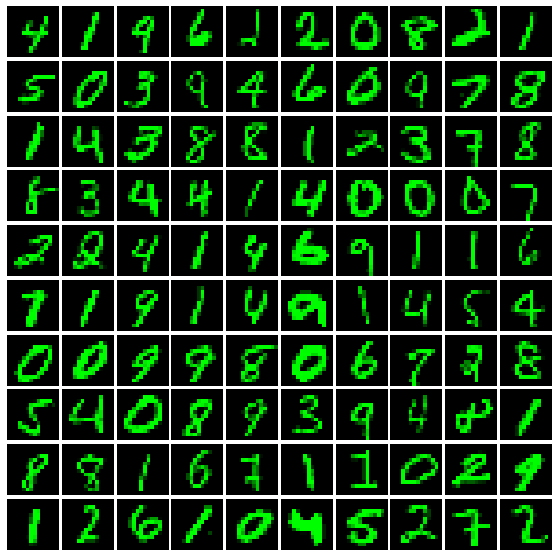

All images colored red
Color labels for red:
[0 0 0 ... 0 0 0]


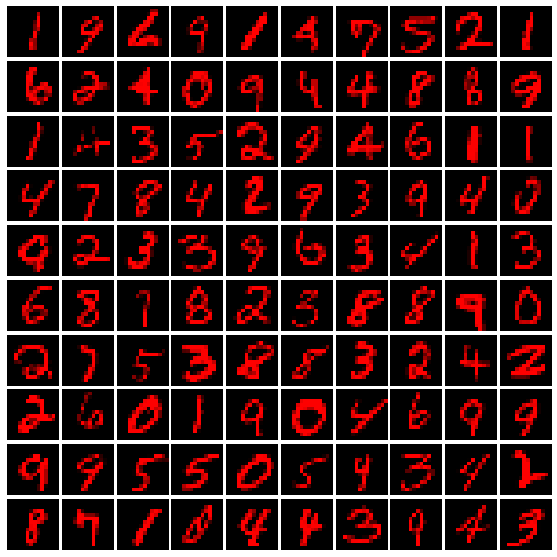

Z shape
(96000, 50)
Z_test shape
(24000, 50)
Z_test_green shape
(12000, 50)
Z_test_red shape
(12000, 50)


In [5]:
X_train_ = mnist_all[0][:int(0.8*len(mnist_all[0]))] 
y_train_ = mnist_all[1][:int(0.8*len(mnist_all[1]))]

X_test_ = mnist_all[0][int(0.8*len(mnist_all[0])):]
y_test_ = mnist_all[1][int(0.8*len(mnist_all[1])):]

y_train_ = binarize(y_train_, label_noise=label_noise)
y_test_ = binarize(y_test_, label_noise=label_noise)

green_images, color_green = produce_images_for_the_factor_model(X_train_, green=True)

red_images, color_red = produce_images_for_the_factor_model(X_train_, green=False)

green_and_red_images = np.concatenate((green_images, red_images), axis=0)
color = np.concatenate((color_green, color_red), axis=None)
label_train = np.concatenate((y_train_, y_train_), axis=None)
    



green_images_test, color_green_test = produce_images_for_the_factor_model(X_test_, green=True)

red_images_test, color_red_test = produce_images_for_the_factor_model(X_test_, green=False)

green_and_red_images_test = np.concatenate((green_images_test, red_images_test), axis=0)
color_test = np.concatenate((color_green_test, color_red_test), axis=None)
label_test = np.concatenate((y_test_, y_test_), axis=None)




print("All images colored green")
print("Color labels for green:")
print(color_green)
plot_images(green_images)


print("All images colored red")
print("Color labels for red:")
print(color_red)
plot_images(red_images)


# extract features from green and red train images
Z = extract_features(feature_extractor,torch.from_numpy(green_and_red_images), 
                                        torch.from_numpy(color)).to_numpy()[:, :-1]



# extract features from green and red test images
Z_test = extract_features(feature_extractor,torch.from_numpy(green_and_red_images_test), 
                                        torch.from_numpy(color_test)).to_numpy()[:, :-1]


# extract features from green test images
Z_test_green = extract_features(feature_extractor,torch.from_numpy(green_images_test), 
                                        torch.from_numpy(color_green_test)).to_numpy()[:, :-1]

# extract features from red test images
Z_test_red = extract_features(feature_extractor,torch.from_numpy(red_images_test), 
                                        torch.from_numpy(color_red_test)).to_numpy()[:, :-1]

# Features from images in environments 1, 2, and 3. Environments 1 and 2 are combined to be used for training. 
Z_envs_1_and_2 = train_extracted_features_df.to_numpy()[:, :-1]
Z_env3 = test_extracted_features_df.to_numpy()[:, :-1]


print("Z shape")
print(Z.shape)

print("Z_test shape")
print(Z_test.shape)

print("Z_test_green shape")
print(Z_test_green.shape)

print("Z_test_red shape")
print(Z_test_red.shape)


# Findind L using a closed form solution

## Obtaining color coefficients

In [6]:
# Using sklearn Logistic Regression
from sklearn.linear_model import LogisticRegression


lr_model = LogisticRegression(random_state=0).fit(Z, color)

color_coefficients = lr_model.coef_.reshape(-1,1)
color_coefficients = color_coefficients / np.linalg.norm(color_coefficients)

print("Printing color coefficients")
print(color_coefficients)
print()
print("Color coefficients shape")
print(color_coefficients.shape)

Printing color coefficients
[[-0.13980415]
 [ 0.06067927]
 [ 0.06512126]
 [ 0.06792226]
 [ 0.13046659]
 [-0.09280936]
 [ 0.22354013]
 [-0.04858436]
 [ 0.07667174]
 [ 0.15283947]
 [ 0.07466993]
 [-0.22045933]
 [ 0.03755255]
 [ 0.08255186]
 [ 0.01030543]
 [-0.26045538]
 [-0.10164742]
 [-0.12139986]
 [ 0.30554883]
 [ 0.1119806 ]
 [ 0.07934998]
 [-0.23366925]
 [-0.17188511]
 [-0.04898546]
 [-0.10836749]
 [-0.09085102]
 [ 0.13750755]
 [ 0.07273266]
 [-0.03928643]
 [-0.04657558]
 [-0.19253568]
 [ 0.00738967]
 [-0.06208997]
 [-0.11163535]
 [ 0.12157417]
 [ 0.11188642]
 [-0.24505455]
 [ 0.039272  ]
 [-0.10241531]
 [ 0.16812194]
 [ 0.25983986]
 [ 0.03844115]
 [-0.10252924]
 [-0.03788886]
 [ 0.19740868]
 [ 0.19817425]
 [-0.12326919]
 [-0.12935665]
 [-0.19125141]
 [ 0.2233117 ]]

Color coefficients shape
(50, 1)


## Computing M

In [7]:
lamda = 0.01

k = int(Z.shape[1]*0.2) # 20% of original number of features
n = Z.shape[0]


# the difference between Z_green and Z_red in Z
# delta_Z_matrix = (Z[:int(len(color)/2),:] - Z[int(len(color)/2):,:])
delta_Z_matrix = np.absolute((Z[:int(len(color)/2),:] - Z[int(len(color)/2):,:]))

M = - Z.T @ Z/n + lamda * delta_Z_matrix.T @ delta_Z_matrix / (n // 2 ) 
#n M = p.matmul(-Z.transpose(), Z) -   lamda * (Z.transpose() @ Z@ delta_Z_matrix.transpose() @ delta_Z_matrix)
# M = np.matmul(-Z.transpose(), Z) +   lamda * (Z.transpose() @ Z@ delta_Z_matrix.transpose() @ delta_Z_matrix)
# M = np.matmul(-Z.transpose(), Z)/n +   lamda * (Z.transpose() @ Z@ delta_Z_matrix.transpose() @ delta_Z_matrix)/(n // 2 )
M.shape

(50, 50)

## Computing the term on which we will perform SVD

In [8]:
alpha_alpha_T = color_coefficients @ color_coefficients.T
d = alpha_alpha_T.shape[0]
I = np.identity(d)
I_minus_alpa_alpha_T = I-alpha_alpha_T
term_for_SVD = (I_minus_alpa_alpha_T @ M) @ I_minus_alpa_alpha_T
term_for_SVD

array([[-4.08032488, -2.1355179 , -2.22132484, ..., -2.75089726,
        -2.24949956, -2.34942861],
       [-2.1355179 , -2.07654805, -1.65895715, ..., -2.13681333,
        -1.68620838, -1.74651939],
       [-2.22132484, -1.65895715, -2.20810421, ..., -2.08379281,
        -1.72292157, -1.72099193],
       ...,
       [-2.75089726, -2.13681333, -2.08379281, ..., -3.46735785,
        -2.32578499, -2.47935226],
       [-2.24949956, -1.68620838, -1.72292157, ..., -2.32578499,
        -1.8236544 , -1.87950946],
       [-2.34942861, -1.74651939, -1.72099193, ..., -2.47935226,
        -1.87950946, -2.1483911 ]])

## Performing SVD to get eigenvectors and eigenvalues

In [9]:
from numpy import linalg as LA
eigenvalues, eigenvectors = LA.eigh(term_for_SVD)
display(eigenvalues)
display(eigenvectors)
display(eigenvectors.shape)

array([-1.00118001e+02, -3.75815266e+00, -2.59418694e+00, -2.44154650e+00,
       -1.97209322e+00, -1.69957571e+00, -1.38456643e+00, -1.06337344e+00,
       -8.95844117e-01, -7.08389942e-01, -5.05101245e-01, -4.24570008e-01,
       -3.98546256e-01, -2.50816076e-01, -2.19646324e-01, -1.49025779e-01,
       -1.46397473e-01, -1.39457945e-01, -1.28014834e-01, -1.01468395e-01,
       -9.04179078e-02, -8.45446307e-02, -7.00570325e-02, -6.63879703e-02,
       -5.94601609e-02, -5.47752878e-02, -5.11225358e-02, -4.16109345e-02,
       -3.79360162e-02, -3.55847077e-02, -3.32164027e-02, -2.52189410e-02,
       -2.30844006e-02, -2.16353846e-02, -1.78557474e-02, -1.43220439e-02,
       -1.39309099e-02, -1.15129069e-02, -1.13296159e-02, -9.99169599e-03,
       -8.08210856e-03, -5.99349936e-03, -5.08440794e-03, -4.07393064e-03,
       -3.50201242e-03, -2.92669064e-03, -2.50774705e-03, -2.33349660e-03,
        1.08578838e-15,  3.60991335e-02])

array([[-0.1667031 ,  0.30811967,  0.01144763, ...,  0.00322505,
        -0.13980415,  0.10202403],
       [-0.12344632,  0.24032192,  0.05292055, ..., -0.01626558,
         0.06067927,  0.10686386],
       [-0.12389867,  0.1979652 , -0.10284571, ..., -0.02630085,
         0.06512126,  0.04029148],
       ...,
       [-0.17098498,  0.04018803, -0.02142524, ..., -0.02830755,
        -0.12935665,  0.09811266],
       [-0.13234635,  0.07069959, -0.04626125, ..., -0.0003747 ,
        -0.19125141, -0.11235189],
       [-0.14436991, -0.05037945,  0.10044735, ..., -0.08144153,
         0.2233117 , -0.15844924]])

(50, 50)

## Forming L from the eigen vectors and alpha

In [10]:
L_1 = color_coefficients
# L_2 = eigenvectors[:,(eigenvectors.shape[1]-k):eigenvectors.shape[1]-1]

least_k_eigen_values = eigenvalues[:k]


least_k_eigen_values[np.absolute(least_k_eigen_values)<0.000001]=0

print("Printing least k eigenvalues before removing the zero eigenvalue")
print(least_k_eigen_values)

non_zero_indeces = None
if 0 in least_k_eigen_values:
    non_zero_indeces = np.nonzero(least_k_eigen_values)[0]
    least_k_eigen_values_without_0 = least_k_eigen_values[non_zero_indeces]
    print("Printing least k eigenvalues after removing the zero eigenvalue")
    print(least_k_eigen_values_without_0)
    
else:
    non_zero_indeces = np.nonzero(least_k_eigen_values[:k-1])[0]
    least_k_eigen_values_without_0 = least_k_eigen_values[:k-1]
    print("Printing least k eigenvalues after removing the zero eigenvalue")
    print(least_k_eigen_values_without_0)

print("Printing non zero indeces of the least k eigenvalues") 
print(non_zero_indeces) #

L_2 = eigenvectors[:,non_zero_indeces]

print(L_2.shape)

L = np.concatenate((L_1, L_2), axis=1)

L.shape

Printing least k eigenvalues before removing the zero eigenvalue
[-100.11800142   -3.75815266   -2.59418694   -2.4415465    -1.97209322
   -1.69957571   -1.38456643   -1.06337344   -0.89584412   -0.70838994]
Printing least k eigenvalues after removing the zero eigenvalue
[-100.11800142   -3.75815266   -2.59418694   -2.4415465    -1.97209322
   -1.69957571   -1.38456643   -1.06337344   -0.89584412]
Printing non zero indeces of the least k eigenvalues
[0 1 2 3 4 5 6 7 8]
(50, 9)


(50, 10)

# Obtaining F_test values from extracted image features using numpy's linalg.lstsq function.

In [11]:
# Documentation of np.linalg.lstsq: https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html
# F_test = torch.from_numpy(np.linalg.lstsq((L.T).detach().numpy(), Z_test.transpose(), rcond=None)[0].transpose())
# F_test_green = torch.from_numpy(np.linalg.lstsq((L.T).detach().numpy(), Z_test_green.transpose(), rcond=None)[0].transpose())
# F_test_red = torch.from_numpy(np.linalg.lstsq((L.T).detach().numpy(), Z_test_red.transpose(), rcond=None)[0].transpose())

# F_envs_1_and_2 = torch.from_numpy(np.linalg.lstsq((L.T).detach().numpy(), Z_envs_1_and_2.transpose(), rcond=None)[0].transpose())
# F_env3 = torch.from_numpy(np.linalg.lstsq((L.T).detach().numpy(), Z_env3.transpose(), rcond=None)[0].transpose())



F = torch.from_numpy(np.linalg.lstsq(L, Z.transpose(), rcond=None)[0].transpose())
F_test = torch.from_numpy(np.linalg.lstsq(L, Z_test.transpose(), rcond=None)[0].transpose())
F_test_green = torch.from_numpy(np.linalg.lstsq(L, Z_test_green.transpose(), rcond=None)[0].transpose())
F_test_red = torch.from_numpy(np.linalg.lstsq(L, Z_test_red.transpose(), rcond=None)[0].transpose())

F_envs_1_and_2 = torch.from_numpy(np.linalg.lstsq(L, Z_envs_1_and_2.transpose(), rcond=None)[0].transpose())
F_env3 = torch.from_numpy(np.linalg.lstsq(L, Z_env3.transpose(), rcond=None)[0].transpose())



print("F_test shape")
print(F_test.shape)

print("F_test_green shape")
print(F_test_green.shape)

print("F_test_red shape")
print(F_test_red.shape)

print("F_envs_1_and_2 shape")
print(F_envs_1_and_2.shape)

print("F_env3 shape")
print(F_env3.shape)


F_test shape
torch.Size([24000, 10])
F_test_green shape
torch.Size([12000, 10])
F_test_red shape
torch.Size([12000, 10])
F_envs_1_and_2 shape
torch.Size([40000, 10])
F_env3 shape
torch.Size([20000, 10])


# Correlation Matrices

## Correlation Matrix for F

In [12]:
pd.DataFrame(torch.corrcoef(F.T).detach().numpy())

,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.081700,0.669181,-0.393711,0.179318,0.039726,0.073411,0.218715,0.078469,-0.165047
1,0.081700,1.000000,0.057787,-0.150630,-0.230684,0.174563,0.083709,0.182940,-0.062720,-0.023695
2,0.669181,0.057787,1.000000,0.000130,-0.000417,-0.001856,-0.002563,-0.001313,0.001235,-0.000687
3,-0.393711,-0.150630,0.000130,1.000000,-0.000359,0.002139,0.002327,-0.000094,-0.001058,-0.000312
4,0.179318,-0.230684,-0.000417,-0.000359,1.000000,0.003703,0.004375,0.002573,-0.001521,0.000427
5,0.039726,0.174563,-0.001856,0.002139,0.003703,1.000000,-0.000331,0.000551,-0.000059,-0.001647
6,0.073411,0.083709,-0.002563,0.002327,0.004375,-0.000331,1.000000,-0.003329,-0.006089,0.005094
7,0.218715,0.182940,-0.001313,-0.000094,0.002573,0.000551,-0.003329,1.000000,0.001913,0.000099
8,0.078469,-0.062720,0.001235,-0.001058,-0.001521,-0.000059,-0.006089,0.001913,1.000000,-0.003338
9,-0.165047,-0.023695,-0.000687,-0.000312,0.000427,-0.001647,0.005094,0.000099,-0.003338,1.000000


## Correlation Matrix for F_test

In [13]:
pd.DataFrame(torch.corrcoef(F_test.T).detach().numpy())

,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.083219,0.676313,-0.377999,0.166359,0.046373,0.075310,0.216050,0.085733,-0.179545
1,0.083219,1.000000,0.054374,-0.147430,-0.218351,0.184040,0.075868,0.195042,-0.054685,-0.014516
2,0.676313,0.054374,1.000000,0.002588,-0.004279,0.003025,0.004137,0.000767,0.008892,-0.006554
3,-0.377999,-0.147430,0.002588,1.000000,0.015269,-0.003132,0.012890,0.009397,-0.004554,0.000959
4,0.166359,-0.218351,-0.004279,0.015269,1.000000,0.004909,0.012459,-0.003114,-0.005547,-0.020773
5,0.046373,0.184040,0.003025,-0.003132,0.004909,1.000000,-0.003287,-0.003303,0.003880,-0.000432
6,0.075310,0.075868,0.004137,0.012890,0.012459,-0.003287,1.000000,-0.016194,-0.009173,-0.011437
7,0.216050,0.195042,0.000767,0.009397,-0.003114,-0.003303,-0.016194,1.000000,0.007048,-0.001359
8,0.085733,-0.054685,0.008892,-0.004554,-0.005547,0.003880,-0.009173,0.007048,1.000000,-0.009427
9,-0.179545,-0.014516,-0.006554,0.000959,-0.020773,-0.000432,-0.011437,-0.001359,-0.009427,1.000000


## Correlation Matrix for F_test_green

In [14]:
pd.DataFrame(torch.corrcoef(F_test_green.T).detach().numpy())

,0,1,2,3,4,5,6,7,8,9
0,1.000000,-0.873260,0.437472,0.019263,0.109508,-0.219285,-0.006877,-0.014303,-0.027642,-0.126407
1,-0.873260,1.000000,-0.321333,-0.037907,-0.313478,0.135833,0.009327,0.189567,0.116202,-0.012958
2,0.437472,-0.321333,1.000000,0.685846,-0.094877,-0.899747,-0.115045,-0.309853,0.037904,0.141294
3,0.019263,-0.037907,0.685846,1.000000,0.052487,-0.671347,0.194552,-0.181591,0.198645,0.153348
4,0.109508,-0.313478,-0.094877,0.052487,1.000000,0.167500,0.009304,-0.161166,-0.312053,0.093285
5,-0.219285,0.135833,-0.899747,-0.671347,0.167500,1.000000,0.341418,0.156410,0.077773,-0.217700
6,-0.006877,0.009327,-0.115045,0.194552,0.009304,0.341418,1.000000,-0.287315,0.534690,-0.060534
7,-0.014303,0.189567,-0.309853,-0.181591,-0.161166,0.156410,-0.287315,1.000000,0.217776,0.199408
8,-0.027642,0.116202,0.037904,0.198645,-0.312053,0.077773,0.534690,0.217776,1.000000,0.573548
9,-0.126407,-0.012958,0.141294,0.153348,0.093285,-0.217700,-0.060534,0.199408,0.573548,1.000000


## Correlation Matrix for F_test_red

In [15]:
pd.DataFrame(torch.corrcoef(F_test_red.T).detach().numpy())

,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.941215,0.648283,-0.340907,-0.015976,0.143889,0.196791,0.198851,0.000019,-0.127623
1,0.941215,1.000000,0.603401,-0.204662,-0.099936,0.220623,0.211364,0.186401,-0.163786,0.009086
2,0.648283,0.603401,1.000000,-0.198301,-0.272733,0.632148,0.226239,0.214654,-0.164938,-0.014966
3,-0.340907,-0.204662,-0.198301,1.000000,0.185781,0.226562,-0.184212,0.344457,-0.040537,-0.335632
4,-0.015976,-0.099936,-0.272733,0.185781,1.000000,-0.250597,-0.038366,0.507016,0.511947,-0.541387
5,0.143889,0.220623,0.632148,0.226562,-0.250597,1.000000,-0.320445,-0.111248,-0.018967,0.184734
6,0.196791,0.211364,0.226239,-0.184212,-0.038366,-0.320445,1.000000,0.661461,-0.656089,0.210837
7,0.198851,0.186401,0.214654,0.344457,0.507016,-0.111248,0.661461,1.000000,-0.185712,-0.369566
8,0.000019,-0.163786,-0.164938,-0.040537,0.511947,-0.018967,-0.656089,-0.185712,1.000000,-0.574124
9,-0.127623,0.009086,-0.014966,-0.335632,-0.541387,0.184734,0.210837,-0.369566,-0.574124,1.000000


## Correlation Matrix for F_envs_1_and_2

In [16]:
pd.DataFrame(torch.corrcoef(F_envs_1_and_2.T).detach().numpy())

,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.158838,0.791250,-0.693062,-0.374160,-0.011572,0.055577,-0.172243,0.057594,-0.149513
1,0.158838,1.000000,0.195394,-0.255979,-0.166779,0.186827,0.031981,0.132540,-0.226992,0.120301
2,0.791250,0.195394,1.000000,-0.417184,-0.386748,0.222035,0.164453,-0.220879,-0.113644,0.019997
3,-0.693062,-0.255979,-0.417184,1.000000,0.313085,0.178789,-0.037251,-0.039612,0.214382,-0.103171
4,-0.374160,-0.166779,-0.386748,0.313085,1.000000,-0.064992,0.258403,-0.091541,0.109759,-0.048388
5,-0.011572,0.186827,0.222035,0.178789,-0.064992,1.000000,-0.101860,-0.124126,-0.075197,0.181179
6,0.055577,0.031981,0.164453,-0.037251,0.258403,-0.101860,1.000000,-0.231713,-0.115556,-0.018147
7,-0.172243,0.132540,-0.220879,-0.039612,-0.091541,-0.124126,-0.231713,1.000000,-0.245392,0.096983
8,0.057594,-0.226992,-0.113644,0.214382,0.109759,-0.075197,-0.115556,-0.245392,1.000000,-0.233062
9,-0.149513,0.120301,0.019997,-0.103171,-0.048388,0.181179,-0.018147,0.096983,-0.233062,1.000000


## Correlation Matrix for F_env3

In [17]:
pd.DataFrame(torch.corrcoef(F_env3.T).detach().numpy())

,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.036433,0.580799,-0.066564,0.532427,0.111109,0.108134,0.568374,0.102653,-0.215264
1,0.036433,1.000000,-0.044427,-0.068458,-0.267959,0.167781,0.144669,0.239630,0.063152,-0.087391
2,0.580799,-0.044427,1.000000,0.369602,0.247371,-0.268243,-0.169387,0.168073,0.083750,0.015409
3,-0.066564,-0.068458,0.369602,1.000000,-0.099981,-0.277996,0.036446,0.012530,-0.187616,0.156138
4,0.532427,-0.267959,0.247371,-0.099981,1.000000,0.069467,-0.161325,0.083882,-0.052868,-0.092091
5,0.111109,0.167781,-0.268243,-0.277996,0.069467,1.000000,0.169772,0.153204,0.081670,-0.151466
6,0.108134,0.144669,-0.169387,0.036446,-0.161325,0.169772,1.000000,0.230547,0.091255,0.023977
7,0.568374,0.239630,0.168073,0.012530,0.083882,0.153204,0.230547,1.000000,0.175555,-0.032208
8,0.102653,0.063152,0.083750,-0.187616,-0.052868,0.081670,0.091255,0.175555,1.000000,0.088228
9,-0.215264,-0.087391,0.015409,0.156138,-0.092091,-0.151466,0.023977,-0.032208,0.088228,1.000000


# Histograms

Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,11.722137,1.039508,1.517831,1.920891,3.293982,0.056890,1.987212,1.324973,3.101247,0.225627
1,12.602412,0.983172,3.758572,0.934206,1.752816,0.675920,0.609236,1.603347,0.317992,0.628692
2,7.978467,0.323198,2.506323,0.664994,1.105696,1.267958,0.604712,0.833225,1.384370,0.011094
3,9.586573,0.390678,2.325157,0.005563,0.596222,0.588593,0.125418,1.190240,1.163300,0.329599
4,19.046872,0.703269,6.921508,3.669082,3.851316,0.124865,1.244331,0.227759,2.992684,0.603866


Histogram for F Test feature  0


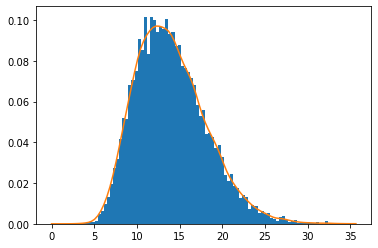

Histogram for F Test feature  1


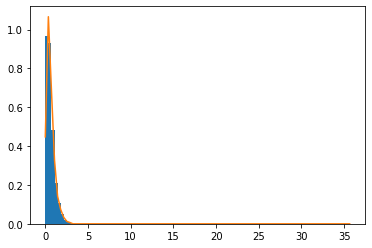

Histogram for F Test feature  2


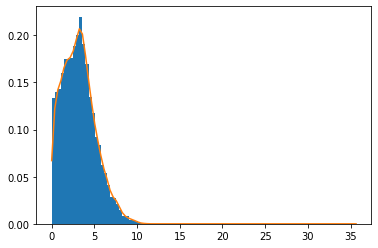

Histogram for F Test feature  3


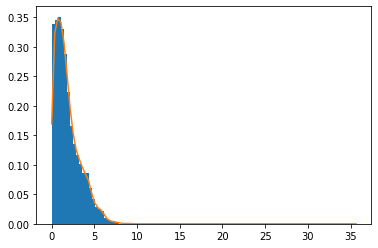

Histogram for F Test feature  4


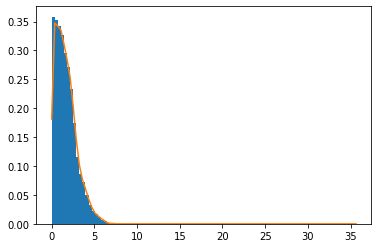

Histogram for F Test feature  5


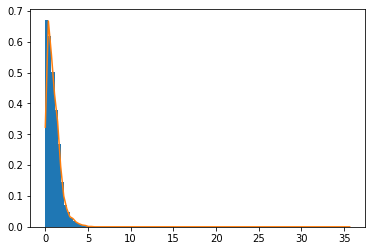

Histogram for F Test feature  6


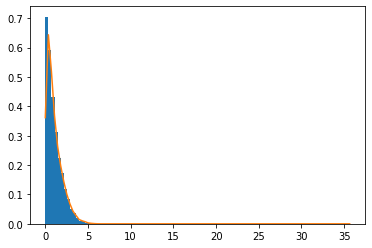

Histogram for F Test feature  7


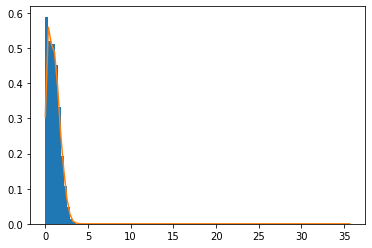

Histogram for F Test feature  8


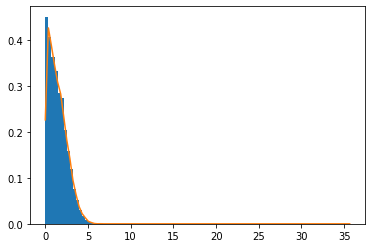

Histogram for F Test feature  9


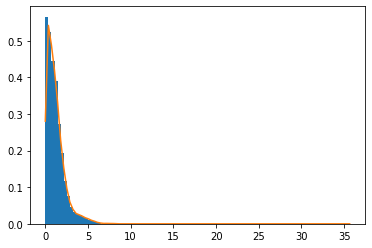

In [18]:
# the difference between F_test_green and F_test_red
delta_matrix = np.absolute(F_test_green.detach().numpy() - F_test_red.detach().numpy())

print("Printing the delta matrix")
delta_matrix_df = pd.DataFrame(delta_matrix)
display(delta_matrix_df.head())

# Plotting the histograms for each feature in the delta matrix # 100 bins
for i in range(len(delta_matrix_df.columns)): 
    print("Histogram for F Test feature ", i)    
    feature = delta_matrix_df.iloc[:,i].values
    density = stats.gaussian_kde(feature)
#     n, x, _ = plt.hist(feature, bins=np.linspace(np.amin(delta_matrix_df.iloc[:,i]), np.amax(delta_matrix_df.iloc[:,i]), 100), 
#                        histtype='bar', density=True)  
    n, x, _ = plt.hist(feature, bins=np.linspace(0, np.amax(delta_matrix_df.iloc[:,0]), 100), 
                       histtype='bar', density=True)  
    plt.plot(x, density(x))
    plt.show()


# Predicting label when trained on all F_envs_1_and_2 and tested on all F_env3 features including color - Environment Shift Present - Logistic Regression

In [19]:
# Using sklearn Logistic Regression
from sklearn.linear_model import LogisticRegression

import torch
from sklearn import preprocessing



train_data_path = train_extracted_features_df
test_data_path = test_extracted_features_df


def read_data(path):
    data_df = path.to_numpy()

    targets = data_df[:, -1] 
    X = data_df[:, :-1] 

    # Standardize the data
    sscaler = preprocessing.StandardScaler()
    sscaler.fit(X)
    X = sscaler.transform(X)


    X_torch = torch.from_numpy(X)
    targets_torch = torch.from_numpy(targets)
    return X_torch, targets_torch



_, targets_torch_train = read_data(train_data_path)
_, targets_torch_test = read_data(test_data_path)


X_torch_train = F_envs_1_and_2
X_torch_test = F_env3
X_torch_test_within = F_envs_1_and_2

targets_torch_train = targets_torch_train.reshape(-1,1)
targets_torch_test = targets_torch_test.reshape(-1,1)
targets_torch_test_within = targets_torch_train.reshape(-1,1)


print("Printing the shape of the input!")
print(X_torch_train.shape)

print("Printing the shape of the target!")
print(targets_torch_train.shape)


logistic_regression_model = LogisticRegression(random_state=0).fit(X_torch_train.detach().numpy(), targets_torch_train.numpy())

print('Logistic Regression Accuracy within training data: ',logistic_regression_model.score(X_torch_test_within.detach().numpy(), targets_torch_test_within.numpy()))
print('Logistic Regression Accuracy on test data: ', logistic_regression_model.score(X_torch_test.detach().numpy(), targets_torch_test.numpy()))




Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.97445
Logistic Regression Accuracy on test data:  0.81145


# Predicting label when trained on all F_envs_1_and_2 and tested on all F_env3 features except color - Environment Shift Present - Logistic Regression

In [20]:
# Using sklearn Logistic Regression
from sklearn.linear_model import LogisticRegression

import torch
from sklearn import preprocessing



train_data_path = train_extracted_features_df
test_data_path = test_extracted_features_df


def read_data(path):
    data_df = path.to_numpy()

    targets = data_df[:, -1] 
    X = data_df[:, :-1] 

    # Standardize the data
    sscaler = preprocessing.StandardScaler()
    sscaler.fit(X)
    X = sscaler.transform(X)


    X_torch = torch.from_numpy(X)
    targets_torch = torch.from_numpy(targets)
    return X_torch, targets_torch



_, targets_torch_train = read_data(train_data_path)
_, targets_torch_test = read_data(test_data_path)


# X_torch_train = F_envs_1_and_2[:,1:]
# X_torch_test = F_env3[:,1:]
# X_torch_test_within = F_envs_1_and_2[:,1:]

targets_torch_train = targets_torch_train.reshape(-1,1)
targets_torch_test = targets_torch_test.reshape(-1,1)
targets_torch_test_within = targets_torch_train.reshape(-1,1)


# print("Printing the shape of the input!")
# print(X_torch_train.shape)

# print("Printing the shape of the target!")
# print(targets_torch_train.shape)

for i in range(F_envs_1_and_2.detach().numpy().shape[1]):
    print("Accuracy for without feature ",i)
    
    X_torch_train = F_envs_1_and_2.detach().numpy().copy()
    X_torch_test = F_env3.detach().numpy().copy()
    X_torch_test_within = F_envs_1_and_2.detach().numpy().copy()
    
    X_torch_train = np.delete(X_torch_train, i, 1)
    X_torch_test = np.delete(X_torch_test, i, 1)
    X_torch_test_within = np.delete(X_torch_test_within, i, 1)


    logistic_regression_model = LogisticRegression(random_state=0).fit(X_torch_train, targets_torch_train.numpy())

    print('Logistic Regression Accuracy within training data: ',logistic_regression_model.score(X_torch_test_within, targets_torch_test_within.numpy()))
    print('Logistic Regression Accuracy on test data: ', logistic_regression_model.score(X_torch_test, targets_torch_test.numpy()))




Accuracy for without feature  0
Logistic Regression Accuracy within training data:  0.96545
Logistic Regression Accuracy on test data:  0.8409
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.974525
Logistic Regression Accuracy on test data:  0.8115
Accuracy for without feature  2
Logistic Regression Accuracy within training data:  0.974625
Logistic Regression Accuracy on test data:  0.81145
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9662
Logistic Regression Accuracy on test data:  0.7195
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.949775
Logistic Regression Accuracy on test data:  0.5289
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.974125
Logistic Regression Accuracy on test data:  0.80995
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9729
Logistic Regression Accuracy on test data:  0.801
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.941325
Logistic Regression Accuracy on test data:  0.4659
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9746
Logistic Regression Accuracy on test data:  0.81125
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.973825
Logistic Regression Accuracy on test data:  0.80695


# Predicting label using all F_train and F_test features including color - No Environment Shift (Logistic Regression)

In [21]:
# Using sklearn Logistic Regression
from sklearn.linear_model import LogisticRegression

import torch
from sklearn import preprocessing


X_torch_train = F
X_torch_test = F_test
X_torch_test_within = F

targets_torch_train = torch.from_numpy(label_train)
targets_torch_test = torch.from_numpy(label_test)
targets_torch_test_within = torch.from_numpy(label_train)


targets_torch_train = targets_torch_train.reshape(-1,1)
targets_torch_test = targets_torch_test.reshape(-1,1)
targets_torch_test_within = targets_torch_test_within.reshape(-1,1)


print("Printing the shape of the input!")
print(X_torch_train.shape)

print("Printing the shape of the target!")
print(targets_torch_train.shape)


logistic_regression_model = LogisticRegression(random_state=0).fit(X_torch_train.detach().numpy(), targets_torch_train.numpy())

print('Logistic Regression Accuracy within training data: ',logistic_regression_model.score(X_torch_test_within.detach().numpy(), targets_torch_test_within.numpy()))
print('Logistic Regression Accuracy on test data: ', logistic_regression_model.score(X_torch_test.detach().numpy(), targets_torch_test.numpy()))



Printing the shape of the input!
torch.Size([96000, 10])
Printing the shape of the target!
torch.Size([96000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.94453125
Logistic Regression Accuracy on test data:  0.9417916666666667



# Predicting Label Using all F_train and F_test Features Except Color - No Environment Shift (Logistic Regression)

In [22]:
# Using sklearn Logistic Regression
from sklearn.linear_model import LogisticRegression

import torch
from sklearn import preprocessing


X_torch_train = F[:,1:]
X_torch_test = F_test[:,1:]
X_torch_test_within = F[:,1:]

targets_torch_train = torch.from_numpy(label_train)
targets_torch_test = torch.from_numpy(label_test)
targets_torch_test_within = torch.from_numpy(label_train)


targets_torch_train = targets_torch_train.reshape(-1,1)
targets_torch_test = targets_torch_test.reshape(-1,1)
targets_torch_test_within = targets_torch_test_within.reshape(-1,1)


print("Printing the shape of the input!")
print(X_torch_train.shape)

print("Printing the shape of the target!")
print(targets_torch_train.shape)


logistic_regression_model = LogisticRegression(random_state=0).fit(X_torch_train.detach().numpy(), targets_torch_train.numpy())

print('Logistic Regression Accuracy within training data: ',logistic_regression_model.score(X_torch_test_within.detach().numpy(), targets_torch_test_within.numpy()))
print('Logistic Regression Accuracy on test data: ', logistic_regression_model.score(X_torch_test.detach().numpy(), targets_torch_test.numpy()))


Printing the shape of the input!
torch.Size([96000, 9])
Printing the shape of the target!
torch.Size([96000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9445
Logistic Regression Accuracy on test data:  0.9417916666666667


<br>

# Getting Results for Different values of Lamda





Results for lamda  100000



array([-5.25655946e-10,  3.97454001e+02,  4.92110686e+02,  5.59511285e+02,
        5.93423136e+02,  7.31044450e+02,  7.86956668e+02,  1.11623182e+03,
        1.35763465e+03,  1.82608616e+03,  2.08079410e+03,  2.20848552e+03,
        2.46281780e+03,  2.96728009e+03,  3.33748515e+03,  3.75094930e+03,
        3.79525712e+03,  4.28973315e+03,  4.73544828e+03,  5.05288154e+03,
        6.54761529e+03,  7.40084339e+03,  8.22544675e+03,  8.70849429e+03,
        9.04562361e+03,  9.98341006e+03,  1.05968891e+04,  1.09550554e+04,
        1.15787829e+04,  1.25457519e+04,  1.34019739e+04,  1.48429697e+04,
        1.67420335e+04,  1.91361696e+04,  2.16678297e+04,  2.23426731e+04,
        2.70467436e+04,  2.79193758e+04,  2.94291426e+04,  3.16389557e+04,
        3.54534354e+04,  4.97604808e+04,  5.32764194e+04,  6.55591016e+04,
        9.37356134e+04,  1.65060539e+05,  2.06200494e+05,  2.44094530e+05,
        4.11621921e+05,  2.40468798e+07])

array([[-0.13980415,  0.00607305,  0.00374049, ..., -0.00328741,
         0.13818439,  0.12935189],
       [ 0.06067927, -0.00547216,  0.00463455, ..., -0.23167262,
         0.09712673,  0.11034327],
       [ 0.06512126,  0.01414332, -0.01247927, ..., -0.01411857,
         0.00375996,  0.11812316],
       ...,
       [-0.12935665,  0.02313046, -0.00221829, ..., -0.1082842 ,
        -0.30019562,  0.13154362],
       [-0.19125141, -0.06085788,  0.02836889, ...,  0.03306362,
         0.03026013,  0.16350393],
       [ 0.2233117 , -0.01567642, -0.74231969, ..., -0.05915293,
         0.06681665,  0.18245761]])

Printing least k eigenvalues before removing the zero eigenvalue
[   0.          397.45400085  492.11068629  559.51128503  593.42313628
  731.04445046  786.95666761 1116.2318204  1357.63465409 1826.08615719]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[ 397.45400085  492.11068629  559.51128503  593.42313628  731.04445046
  786.95666761 1116.2318204  1357.63465409 1826.08615719]
Printing non zero indeces of the least k-1 eigenvalues
[1 2 3 4 5 6 7 8 9]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,11.722137,0.344972,0.090114,0.117150,0.481714,0.019796,0.070845,0.011926,0.814950,0.235286
1,12.602412,0.262727,0.130628,0.054775,0.023637,0.124464,0.263369,0.329493,0.092713,0.338470
2,7.978467,0.002954,0.027689,0.234907,0.255396,0.246017,0.093006,0.226430,0.564181,0.087527
3,9.586573,0.154895,0.108667,0.288360,0.031472,0.107989,0.137253,0.034425,0.278391,0.494153
4,19.046872,0.005486,0.153091,0.291748,0.441826,0.345535,0.362614,0.489838,1.477216,0.224671


Histogram for F Test feature  0


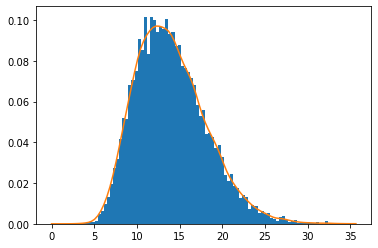

Histogram for F Test feature  1


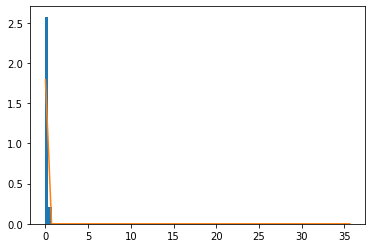

Histogram for F Test feature  2


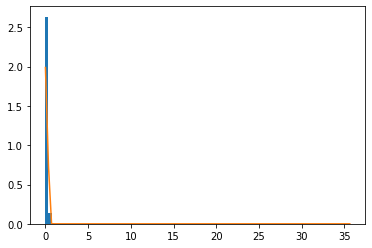

Histogram for F Test feature  3


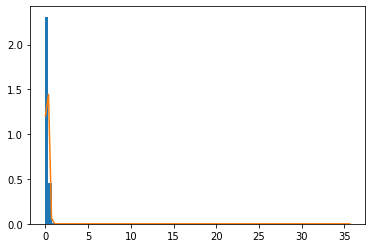

Histogram for F Test feature  4


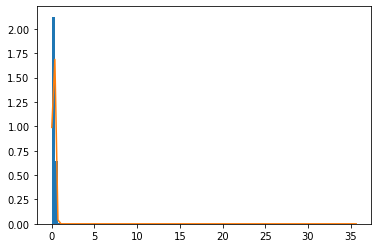

Histogram for F Test feature  5


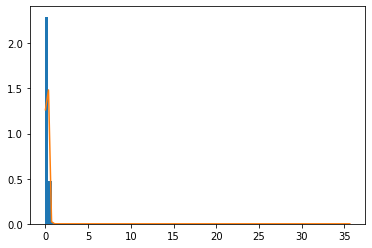

Histogram for F Test feature  6


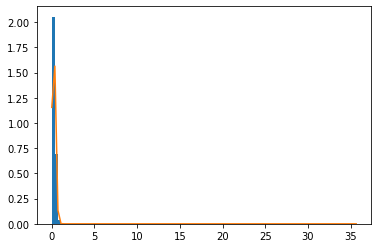

Histogram for F Test feature  7


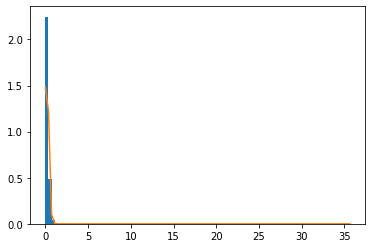

Histogram for F Test feature  8


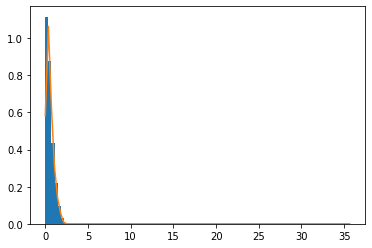

Histogram for F Test feature  9


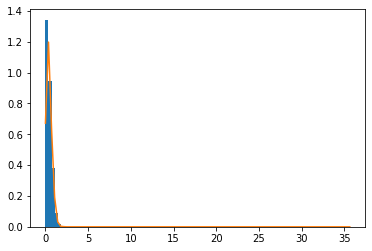

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR Accuracy within training data - All features :  0.926775
LR Accuracy on test data - All features:  0.16195
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.888125
Logistic Regression Accuracy on test data:  0.2668
Accuracy for without feature  1
Logistic Regression Accuracy within training data:  0.925975
Logistic Regression Accuracy on test data:  0.14085
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.926775
Logistic Regression Accuracy on test data:  0.1577
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9247
Logistic Regression Accuracy on test data:  0.13785
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.92585
Logistic Regression Accuracy on test data:  0.15215
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.92605
Logistic Regression Accuracy on test data:  0.13725
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9266
Logistic Regression Accuracy on test data:  0.16115
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d arr

Logistic Regression Accuracy within training data:  0.924275
Logistic Regression Accuracy on test data:  0.12995
Accuracy for without feature  8
Logistic Regression Accuracy within training data:  0.925825
Logistic Regression Accuracy on test data:  0.1533
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.926725
Logistic Regression Accuracy on test data:  0.16175




Results for lamda  10



array([-2.78441909e+00, -2.39199159e+00, -1.31324180e+00, -2.82181403e-01,
       -3.00303135e-02,  3.05749755e-14,  3.58674502e-02,  4.00988137e-02,
        4.88889469e-02,  5.52240535e-02,  6.61502697e-02,  7.43020052e-02,
        1.11118225e-01,  1.50850800e-01,  1.53040333e-01,  1.77068829e-01,
        2.24014422e-01,  2.58093442e-01,  3.17221059e-01,  3.24992639e-01,
        3.85036749e-01,  4.56321883e-01,  5.36369041e-01,  5.68174058e-01,
        6.27642921e-01,  6.60401257e-01,  7.77427801e-01,  8.21322937e-01,
        9.23656706e-01,  1.04220887e+00,  1.11720840e+00,  1.14472589e+00,
        1.31778027e+00,  1.43426611e+00,  1.57430841e+00,  1.91962308e+00,
        2.05642635e+00,  2.18935372e+00,  2.62479730e+00,  2.77008257e+00,
        3.30427101e+00,  3.88696876e+00,  4.50517096e+00,  5.32927135e+00,
        8.21862263e+00,  1.58095152e+01,  1.89131181e+01,  2.32894770e+01,
        3.98307664e+01,  2.30769225e+03])

array([[-0.09492205,  0.16570917, -0.0802355 , ..., -0.02682431,
         0.14585902,  0.12763144],
       [-0.11478   ,  0.40673571,  0.11448564, ..., -0.22810115,
         0.09942661,  0.10965637],
       [-0.04993383,  0.23564542,  0.00627531, ..., -0.00610836,
         0.001458  ,  0.11773903],
       ...,
       [ 0.14752363,  0.11119831,  0.12432202, ..., -0.12526843,
        -0.29607035,  0.12971542],
       [-0.12115928,  0.01401506, -0.08155817, ...,  0.03807488,
         0.03459912,  0.16462455],
       [-0.02601747, -0.13750698,  0.09797583, ..., -0.05872845,
         0.06900196,  0.18384914]])

Printing least k eigenvalues before removing the zero eigenvalue
[-2.78441909 -2.39199159 -1.3132418  -0.2821814  -0.03003031  0.
  0.03586745  0.04009881  0.04888895  0.05522405]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-2.78441909 -2.39199159 -1.3132418  -0.2821814  -0.03003031  0.03586745
  0.04009881  0.04888895  0.05522405]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 6 7 8 9]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,11.722137,1.054080,0.423641,3.837413,1.526267,1.626980,0.113436,0.047850,0.305950,0.427759
1,12.602412,3.039878,1.809153,1.554056,0.621635,1.054215,0.098196,0.279345,0.022306,0.191995
2,7.978467,2.348769,1.691159,0.215077,0.277326,0.920573,0.108347,0.020964,0.064725,0.193887
3,9.586573,1.795030,1.617705,0.087547,0.892585,0.740219,0.104169,0.239644,0.013279,0.366786
4,19.046872,5.434818,3.471450,3.661222,3.613585,0.241374,0.311068,0.042311,0.023068,0.195353


Histogram for F Test feature  0


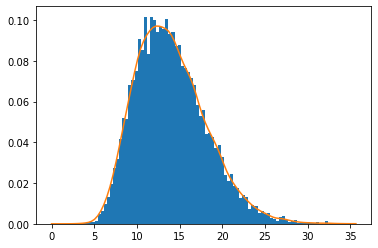

Histogram for F Test feature  1


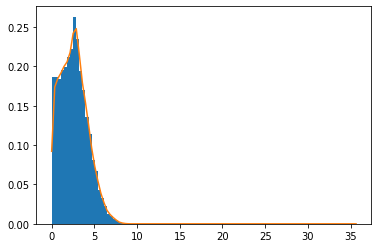

Histogram for F Test feature  2


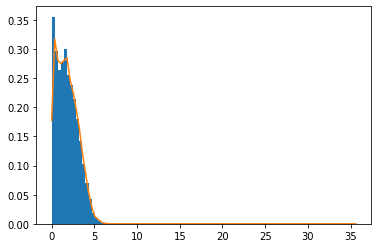

Histogram for F Test feature  3


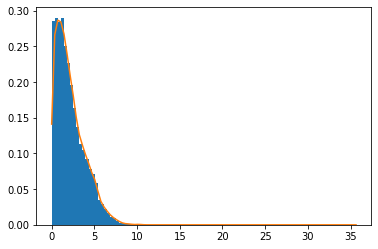

Histogram for F Test feature  4


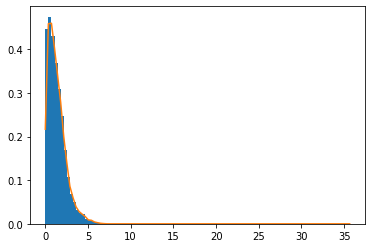

Histogram for F Test feature  5


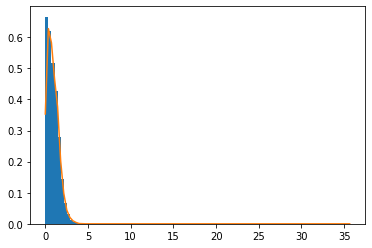

Histogram for F Test feature  6


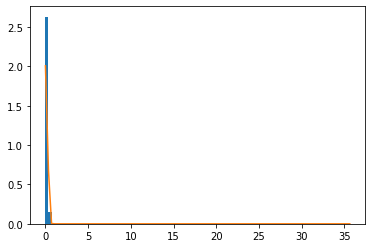

Histogram for F Test feature  7


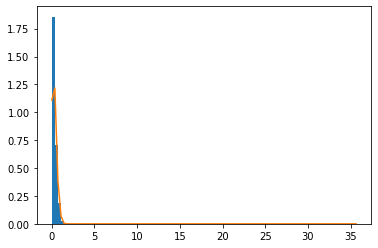

Histogram for F Test feature  8


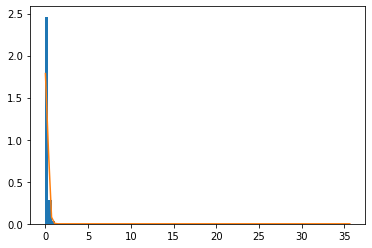

Histogram for F Test feature  9


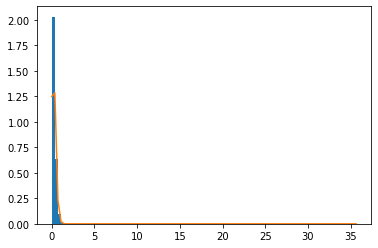

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d arr

LR Accuracy within training data - All features :  0.932775
LR Accuracy on test data - All features:  0.2792
Accuracy for without feature  0
Logistic Regression Accuracy within training data:  0.889225
Logistic Regression Accuracy on test data:  0.36755
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9328
Logistic Regression Accuracy on test data:  0.28015
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.929125
Logistic Regression Accuracy on test data:  0.25565
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d arr

Logistic Regression Accuracy within training data:  0.9326
Logistic Regression Accuracy on test data:  0.27145
Accuracy for without feature  4
Logistic Regression Accuracy within training data:  0.931175
Logistic Regression Accuracy on test data:  0.26135
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.93295
Logistic Regression Accuracy on test data:  0.27865
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.929725
Logistic Regression Accuracy on test data:  0.19575
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.933725
Logistic Regression Accuracy on test data:  0.2862
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.932775
Logistic Regression Accuracy on test data:  0.26415
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.93155
Logistic Regression Accuracy on test data:  0.2474




Results for lamda  9



array([-2.95163290e+00, -2.54998191e+00, -1.39639755e+00, -3.41041636e-01,
       -6.93719546e-02, -1.34986856e-14,  2.81398495e-02,  3.17853607e-02,
        4.15995775e-02,  4.61098479e-02,  5.75574079e-02,  6.38108037e-02,
        9.63308846e-02,  1.23243417e-01,  1.33650108e-01,  1.51354054e-01,
        1.94105058e-01,  2.27676763e-01,  2.74091982e-01,  2.81947368e-01,
        3.29661763e-01,  3.95947884e-01,  4.62207144e-01,  4.75880996e-01,
        5.44320524e-01,  5.61620430e-01,  6.80242278e-01,  7.11222908e-01,
        8.18279991e-01,  9.22919249e-01,  9.90504521e-01,  1.00937661e+00,
        1.14997953e+00,  1.27416998e+00,  1.38357867e+00,  1.70282821e+00,
        1.80245166e+00,  1.94444269e+00,  2.32408325e+00,  2.47293619e+00,
        2.95413255e+00,  3.42069214e+00,  4.00400996e+00,  4.71098155e+00,
        7.29540466e+00,  1.41624353e+01,  1.68547754e+01,  2.08536829e+01,
        3.57175785e+01,  2.06724769e+03])

array([[-0.05651051,  0.19511094, -0.08885084, ..., -0.02908652,
         0.14671697,  0.12743109],
       [-0.03849282,  0.41355363,  0.1169062 , ..., -0.22764043,
         0.09966277,  0.10957598],
       [-0.00630121,  0.23955577,  0.00614462, ..., -0.00515198,
         0.00116306,  0.11769374],
       ...,
       [ 0.16672918,  0.07997312,  0.12891733, ..., -0.12692562,
        -0.29556276,  0.12950246],
       [-0.1186028 ,  0.03226945, -0.08255202, ...,  0.0385998 ,
         0.03505908,  0.16475356],
       [-0.05832892, -0.13061175,  0.09918827, ..., -0.0587351 ,
         0.06922498,  0.18400948]])

Printing least k eigenvalues before removing the zero eigenvalue
[-2.9516329  -2.54998191 -1.39639755 -0.34104164 -0.06937195  0.
  0.02813985  0.03178536  0.04159958  0.04610985]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-2.9516329  -2.54998191 -1.39639755 -0.34104164 -0.06937195  0.02813985
  0.03178536  0.04159958  0.04610985]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 6 7 8 9]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,11.722137,1.203544,0.204987,3.823027,1.630348,1.772941,0.153868,0.173904,0.264922,0.380353
1,12.602412,2.630494,2.388906,1.569925,0.625208,1.147440,0.236203,0.145973,0.078984,0.117967
2,7.978467,1.923734,2.150936,0.218683,0.318309,0.976334,0.099837,0.057075,0.033649,0.147477
3,9.586573,1.412211,1.952148,0.100976,0.918425,0.849053,0.233238,0.197059,0.055605,0.341541
4,19.046872,4.582626,4.596803,3.806462,3.697240,0.260311,0.357799,0.015801,0.013505,0.176931


Histogram for F Test feature  0


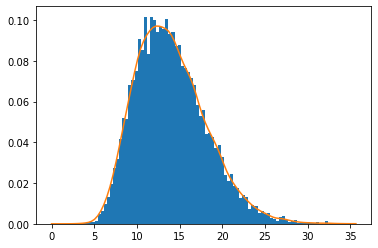

Histogram for F Test feature  1


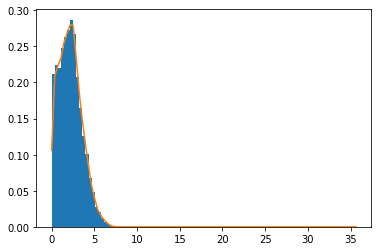

Histogram for F Test feature  2


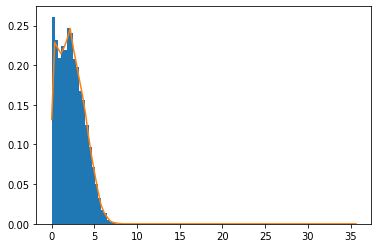

Histogram for F Test feature  3


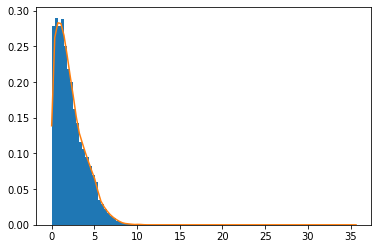

Histogram for F Test feature  4


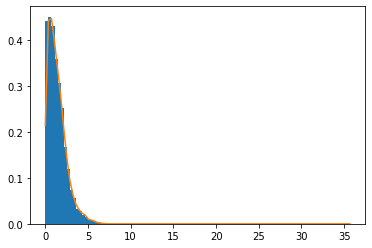

Histogram for F Test feature  5


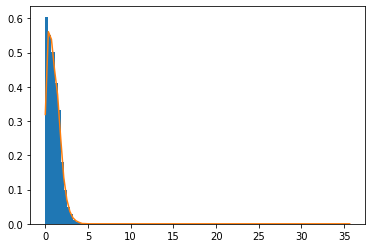

Histogram for F Test feature  6


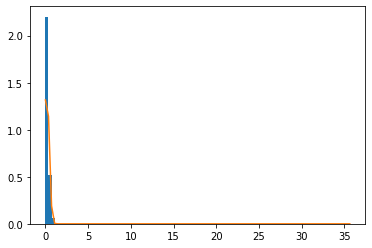

Histogram for F Test feature  7


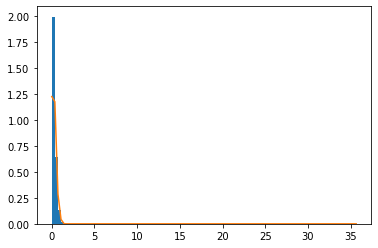

Histogram for F Test feature  8


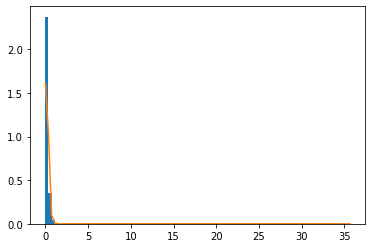

Histogram for F Test feature  9


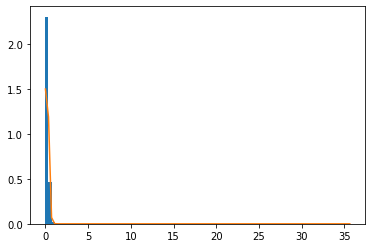

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d arr

LR Accuracy within training data - All features :  0.934
LR Accuracy on test data - All features:  0.29685
Accuracy for without feature  0
Logistic Regression Accuracy within training data:  0.8913
Logistic Regression Accuracy on test data:  0.38675
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.933875
Logistic Regression Accuracy on test data:  0.29675
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.92985
Logistic Regression Accuracy on test data:  0.2735
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d arr

Logistic Regression Accuracy within training data:  0.933525
Logistic Regression Accuracy on test data:  0.29175
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.932
Logistic Regression Accuracy on test data:  0.2775
Accuracy for without feature  5
Logistic Regression Accuracy within training data:  0.933875
Logistic Regression Accuracy on test data:  0.29155
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.929825
Logistic Regression Accuracy on test data:  0.19965
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.933825
Logistic Regression Accuracy on test data:  0.3018
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.93345
Logistic Regression Accuracy on test data:  0.2714
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9324
Logistic Regression Accuracy on test data:  0.2668




Results for lamda  8



array([-3.16671886e+00, -2.68519597e+00, -1.48403502e+00, -4.05999399e-01,
       -1.18143513e-01, -1.09005075e-13,  1.47237034e-02,  2.40052725e-02,
        3.41444913e-02,  3.77665960e-02,  4.88296014e-02,  5.44452075e-02,
        8.02265355e-02,  9.29226357e-02,  1.13912035e-01,  1.26694044e-01,
        1.65225139e-01,  1.96654718e-01,  2.27264231e-01,  2.41974878e-01,
        2.72412138e-01,  3.33759235e-01,  3.71988024e-01,  3.98718002e-01,
        4.56933983e-01,  4.66434002e-01,  5.84459315e-01,  6.05781946e-01,
        7.13006681e-01,  8.04115466e-01,  8.58937944e-01,  8.81945186e-01,
        9.86230111e-01,  1.11420198e+00,  1.19803316e+00,  1.48522206e+00,
        1.55428659e+00,  1.70198958e+00,  2.02487503e+00,  2.17661161e+00,
        2.60437426e+00,  2.96282516e+00,  3.50258246e+00,  4.09931031e+00,
        6.37537680e+00,  1.25159862e+01,  1.47973735e+01,  1.84190536e+01,
        3.16051291e+01,  1.82680974e+03])

array([[ 0.01352633, -0.21633071,  0.0981859 , ..., -0.03182101,
         0.14779025,  0.12717794],
       [-0.02717819, -0.40631348, -0.11889417, ..., -0.22705318,
         0.09995288,  0.1094743 ],
       [-0.03148692, -0.23579803, -0.00565017, ..., -0.00394228,
         0.00078392,  0.11763635],
       ...,
       [-0.17842223, -0.04921126, -0.13307247, ..., -0.12893714,
        -0.29491544,  0.12923337],
       [ 0.11446818, -0.0479731 ,  0.08295993, ...,  0.03925003,
         0.03562821,  0.16491614],
       [ 0.08599732,  0.11772528, -0.10013439, ..., -0.05875477,
         0.06949871,  0.18421156]])

Printing least k eigenvalues before removing the zero eigenvalue
[-3.16671886 -2.68519597 -1.48403502 -0.4059994  -0.11814351  0.
  0.0147237   0.02400527  0.03414449  0.0377666 ]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-3.16671886 -2.68519597 -1.48403502 -0.4059994  -0.11814351  0.0147237
  0.02400527  0.03414449  0.0377666 ]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 6 7 8 9]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,11.722137,1.302410,0.033968,3.801300,1.728962,1.897272,0.236315,0.301029,0.213619,0.343718
1,12.602412,2.168866,2.833169,1.588456,0.631018,1.204779,0.464727,0.024956,0.126548,0.035692
2,7.978467,1.457668,2.478859,0.218164,0.356053,1.011053,0.101023,0.141018,0.002928,0.112393
3,9.586573,1.014100,2.176160,0.118954,0.946874,0.910067,0.430962,0.124709,0.099920,0.296850
4,19.046872,3.604731,5.452862,3.954482,3.767384,0.277940,0.479443,0.055392,0.061755,0.157687


Histogram for F Test feature  0


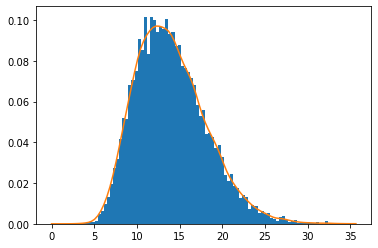

Histogram for F Test feature  1


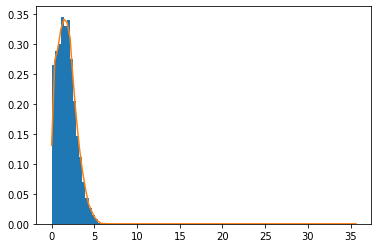

Histogram for F Test feature  2


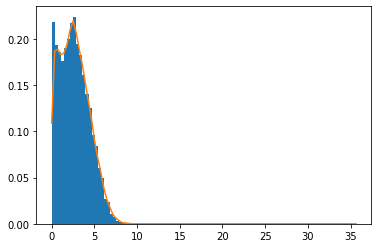

Histogram for F Test feature  3


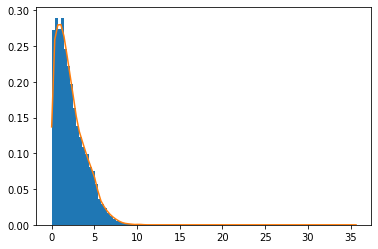

Histogram for F Test feature  4


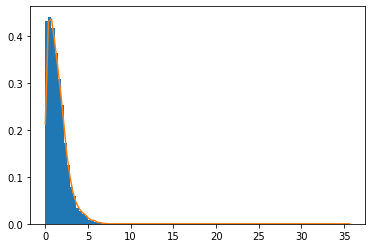

Histogram for F Test feature  5


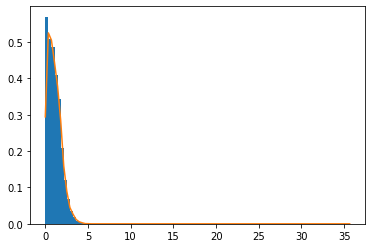

Histogram for F Test feature  6


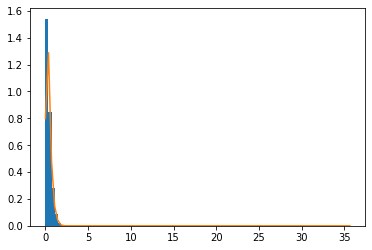

Histogram for F Test feature  7


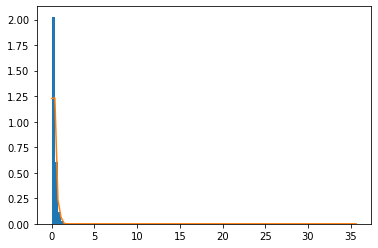

Histogram for F Test feature  8


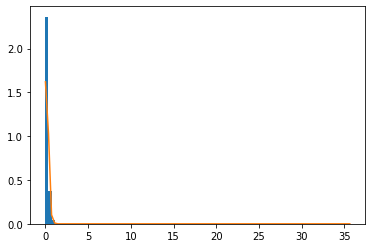

Histogram for F Test feature  9


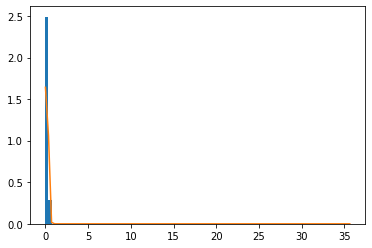

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d arr

LR Accuracy within training data - All features :  0.9348
LR Accuracy on test data - All features:  0.31815
Accuracy for without feature  0
Logistic Regression Accuracy within training data:  0.89305
Logistic Regression Accuracy on test data:  0.40875
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.93505
Logistic Regression Accuracy on test data:  0.3174
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.93015
Logistic Regression Accuracy on test data:  0.2938
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9348
Logistic Regression Accuracy on test data:  0.31605
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.933875
Logistic Regression Accuracy on test data:  0.29875
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.935125
Logistic Regression Accuracy on test data:  0.3115
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9299
Logistic Regression Accuracy on test data:  0.19505
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.935225
Logistic Regression Accuracy on test data:  0.32365
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9336
Logistic Regression Accuracy on test data:  0.282
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.93365
Logistic Regression Accuracy on test data:  0.28085




Results for lamda  7



array([-3.42829410e+00, -2.80396740e+00, -1.57689407e+00, -4.78481451e-01,
       -1.77218107e-01, -1.78223233e-02,  1.90278156e-15,  1.46066664e-02,
        2.71060885e-02,  2.92421897e-02,  3.97631283e-02,  4.56426529e-02,
        5.43537615e-02,  7.25984692e-02,  9.14801925e-02,  1.04324724e-01,
        1.37031723e-01,  1.63507418e-01,  1.81975373e-01,  1.99901798e-01,
        2.13733373e-01,  2.53358769e-01,  2.93637208e-01,  3.28028433e-01,
        3.56331561e-01,  3.87422549e-01,  4.90120106e-01,  5.06930479e-01,
        6.07747340e-01,  6.86000587e-01,  7.26404246e-01,  7.59414223e-01,
        8.28122604e-01,  9.53768524e-01,  1.01893236e+00,  1.26470719e+00,
        1.31532609e+00,  1.46232288e+00,  1.72800432e+00,  1.88096025e+00,
        2.25489567e+00,  2.51460071e+00,  3.00118140e+00,  3.49637256e+00,
        5.45974485e+00,  1.08703405e+01,  1.27413389e+01,  1.59860339e+01,
        2.74937246e+01,  1.58638141e+03])

array([[-2.42510198e-02,  2.30755550e-01, -1.08166250e-01, ...,
        -3.51881269e-02,  1.49171258e-01,  1.26847971e-01],
       [-6.77042132e-02,  3.92439129e-01,  1.20435480e-01, ...,
        -2.26282431e-01,  1.00317716e-01,  1.09341555e-01],
       [-5.48564398e-02,  2.29121219e-01,  4.71728394e-03, ...,
        -2.36603774e-03,  2.79700406e-04,  1.17561261e-01],
       ...,
       [-1.83283617e-01,  2.66404157e-02,  1.36670388e-01, ...,
        -1.31427968e-01, -2.94062742e-01,  1.28882583e-01],
       [ 1.11493194e-01,  5.76007696e-02, -8.26908979e-02, ...,
         4.00777874e-02,  3.63506678e-02,  1.65127311e-01],
       [ 1.04890126e-01, -1.04564395e-01,  1.00806779e-01, ...,
        -5.87968686e-02,  6.98426264e-02,  1.84474114e-01]])

Printing least k eigenvalues before removing the zero eigenvalue
[-3.4282941  -2.8039674  -1.57689407 -0.47848145 -0.17721811 -0.01782232
  0.          0.01460667  0.02710609  0.02924219]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-3.4282941  -2.8039674  -1.57689407 -0.47848145 -0.17721811 -0.01782232
  0.01460667  0.02710609  0.02924219]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 7 8 9]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,11.722137,1.362456,0.232789,3.770835,1.814636,2.028559,0.151527,0.527207,0.213798,0.242319
1,12.602412,1.799685,3.096454,1.609719,0.641011,1.233590,0.926210,0.220146,0.165817,0.060110
2,7.978467,1.076115,2.654240,0.212450,0.387407,1.034133,0.006870,0.282003,0.003773,0.064669
3,9.586573,0.705791,2.284010,0.142007,0.978163,0.925209,0.728302,0.104687,0.076078,0.256297
4,19.046872,2.782952,5.970541,4.103902,3.819975,0.322666,0.722877,0.010631,0.089168,0.152990


Histogram for F Test feature  0


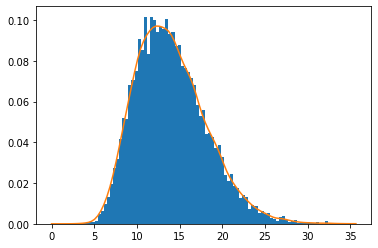

Histogram for F Test feature  1


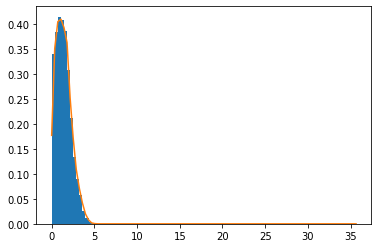

Histogram for F Test feature  2


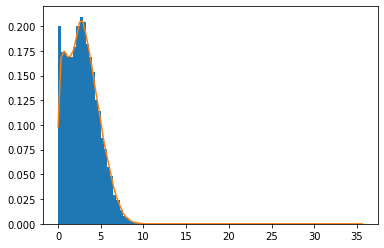

Histogram for F Test feature  3


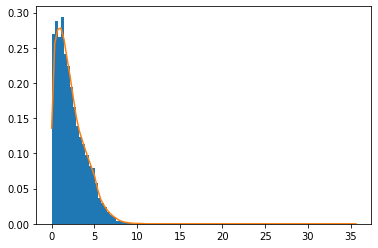

Histogram for F Test feature  4


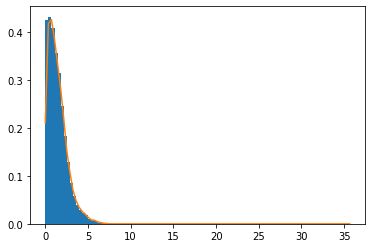

Histogram for F Test feature  5


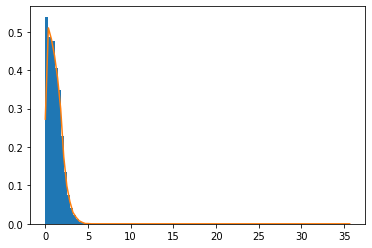

Histogram for F Test feature  6


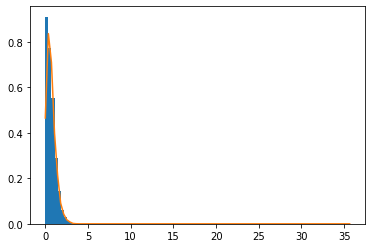

Histogram for F Test feature  7


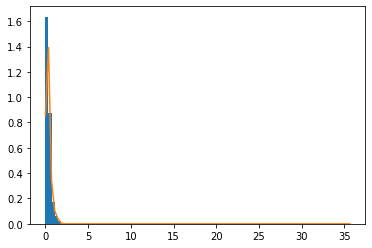

Histogram for F Test feature  8


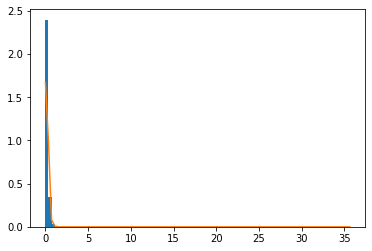

Histogram for F Test feature  9


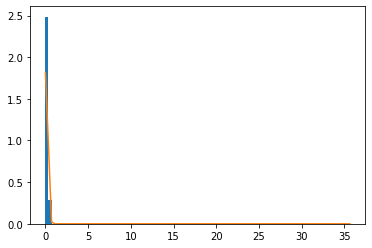

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d arr

LR Accuracy within training data - All features :  0.936975
LR Accuracy on test data - All features:  0.35605
Accuracy for without feature  0
Logistic Regression Accuracy within training data:  0.900525
Logistic Regression Accuracy on test data:  0.44825
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.93665
Logistic Regression Accuracy on test data:  0.35555
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.93265
Logistic Regression Accuracy on test data:  0.33695
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.936975
Logistic Regression Accuracy on test data:  0.35675
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.93595
Logistic Regression Accuracy on test data:  0.34035
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9374
Logistic Regression Accuracy on test data:  0.3462
Accuracy for without feature  6
Logistic Regression Accuracy within training data:  0.928775
Logistic Regression Accuracy on test data:  0.1871
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9367
Logistic Regression Accuracy on test data:  0.36085
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.933625
Logistic Regression Accuracy on test data:  0.2996
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.935625
Logistic Regression Accuracy on test data:  0.32425




Results for lamda  6



array([-3.73500681e+00, -2.91506929e+00, -1.67590097e+00, -5.60653505e-01,
       -2.50561301e-01, -9.28678226e-02, -4.67869165e-03,  3.89513498e-14,
        1.80187205e-02,  2.06309257e-02,  3.01814616e-02,  3.39652034e-02,
        3.71045698e-02,  5.85987707e-02,  6.59059322e-02,  8.44640914e-02,
        1.06777473e-01,  1.23712047e-01,  1.31051019e-01,  1.48407669e-01,
        1.56009446e-01,  1.80836862e-01,  2.32258985e-01,  2.52603281e-01,
        2.70291448e-01,  3.12462480e-01,  3.97656630e-01,  4.14829843e-01,
        5.02292375e-01,  5.68805999e-01,  5.96684240e-01,  6.38915429e-01,
        6.77212995e-01,  7.92347296e-01,  8.47491401e-01,  1.03967381e+00,
        1.08912564e+00,  1.22583420e+00,  1.43449504e+00,  1.58585832e+00,
        1.90524148e+00,  2.07778195e+00,  2.50084588e+00,  2.90496934e+00,
        4.55039698e+00,  9.22572112e+00,  1.06874145e+01,  1.35553297e+01,
        2.33838687e+01,  1.34596781e+03])

array([[ 5.61186988e-02,  2.42727211e-01, -1.18620102e-01, ...,
        -3.94257248e-02,  1.51013740e-01,  1.26399974e-01],
       [ 8.76827267e-02,  3.78315309e-01,  1.21457568e-01, ...,
        -2.25232915e-01,  1.00790272e-01,  1.09160980e-01],
       [ 6.61869833e-02,  2.23124850e-01,  3.18758784e-03, ...,
        -2.32759578e-04, -4.21248425e-04,  1.17458819e-01],
       ...,
       [ 1.84874382e-01,  1.19403778e-02,  1.39527713e-01, ...,
        -1.34587604e-01, -2.92891226e-01,  1.28406275e-01],
       [-1.10459149e-01,  6.25284673e-02, -8.16421326e-02, ...,
         4.11698419e-02,  3.72981724e-02,  1.65412700e-01],
       [-1.17092229e-01, -9.35620595e-02,  1.01212662e-01, ...,
        -5.88788222e-02,  7.02877510e-02,  1.84829061e-01]])

Printing least k eigenvalues before removing the zero eigenvalue
[-3.73500681 -2.91506929 -1.67590097 -0.56065351 -0.2505613  -0.09286782
 -0.00467869  0.          0.01801872  0.02063093]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-3.73500681 -2.91506929 -1.67590097 -0.56065351 -0.2505613  -0.09286782
 -0.00467869  0.01801872  0.02063093]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 8 9]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,11.722137,1.406386,0.388302,3.729938,1.870450,2.178616,0.182449,1.003894,0.196774,0.192473
1,12.602412,1.545243,3.244574,1.633465,0.659149,1.203499,1.340966,0.487922,0.161025,0.146206
2,7.978467,0.793363,2.738145,0.200238,0.405907,1.034458,0.307092,0.566484,0.014792,0.055955
3,9.586573,0.493102,2.326726,0.170479,1.012136,0.863740,1.019462,0.165521,0.165878,0.151183
4,19.046872,2.164641,6.281157,4.252678,3.846811,0.435777,0.824913,0.168183,0.054054,0.141658


Histogram for F Test feature  0


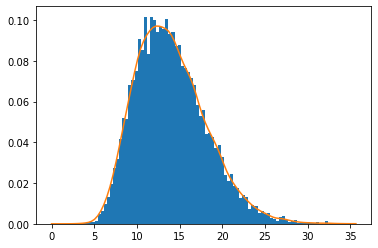

Histogram for F Test feature  1


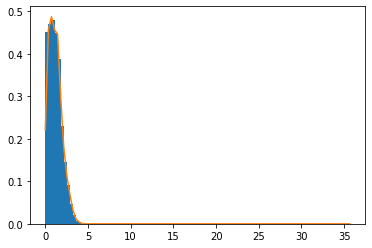

Histogram for F Test feature  2


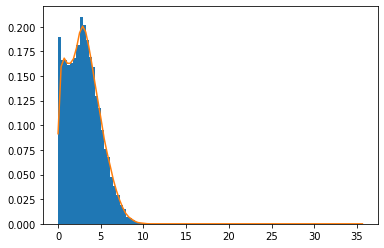

Histogram for F Test feature  3


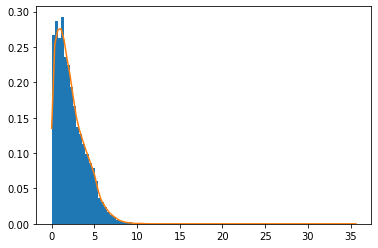

Histogram for F Test feature  4


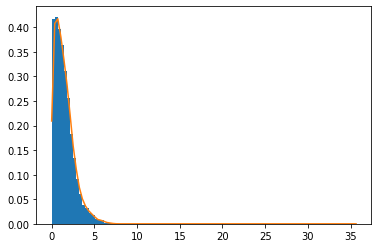

Histogram for F Test feature  5


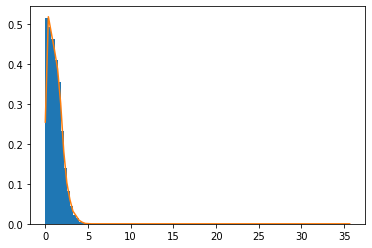

Histogram for F Test feature  6


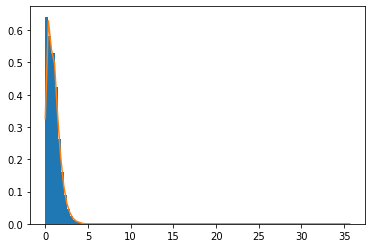

Histogram for F Test feature  7


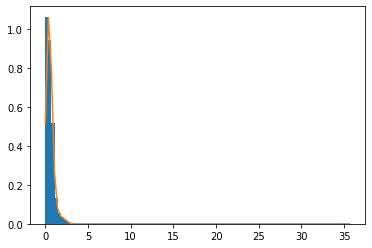

Histogram for F Test feature  8


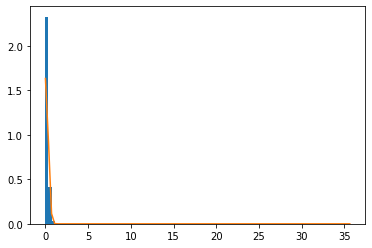

Histogram for F Test feature  9


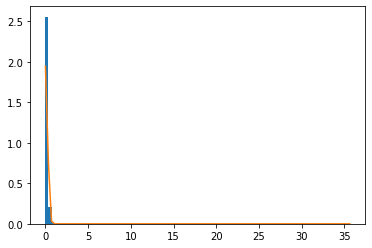

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR Accuracy within training data - All features :  0.9402
LR Accuracy on test data - All features:  0.4129
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.906725
Logistic Regression Accuracy on test data:  0.4989
Accuracy for without feature  1
Logistic Regression Accuracy within training data:  0.9401
Logistic Regression Accuracy on test data:  0.4133
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9357
Logistic Regression Accuracy on test data:  0.3964
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.940375
Logistic Regression Accuracy on test data:  0.41615
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.939725
Logistic Regression Accuracy on test data:  0.4111
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.94075
Logistic Regression Accuracy on test data:  0.39875
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.93025
Logistic Regression Accuracy on test data:  0.2386
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.940275
Logistic Regression Accuracy on test data:  0.4058
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.935225
Logistic Regression Accuracy on test data:  0.33995
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.937175
Logistic Regression Accuracy on test data:  0.37635




Results for lamda  5



array([-4.09330426e+00, -3.02438475e+00, -1.78224093e+00, -6.56203283e-01,
       -3.49698827e-01, -2.09677803e-01, -6.27908652e-02, -5.37214730e-03,
        1.20731728e-14,  1.00253629e-02,  2.01815164e-02,  2.11954510e-02,
        2.85231100e-02,  4.00853142e-02,  4.47030498e-02,  4.57648356e-02,
        6.54210042e-02,  8.24222353e-02,  9.21729902e-02,  1.03672736e-01,
        1.17098130e-01,  1.36767042e-01,  1.61206573e-01,  1.86690360e-01,
        2.05492208e-01,  2.41355699e-01,  3.07996553e-01,  3.27969886e-01,
        3.96072223e-01,  4.52412228e-01,  4.71761181e-01,  5.19647180e-01,
        5.34895905e-01,  6.30735874e-01,  6.83799705e-01,  8.15587806e-01,
        8.73280289e-01,  9.92976711e-01,  1.14559822e+00,  1.29123481e+00,
        1.55352781e+00,  1.65609969e+00,  2.00445616e+00,  2.32839602e+00,
        3.65045043e+00,  7.58236795e+00,  8.63704492e+00,  1.11281324e+01,
        1.92764525e+01,  1.10557853e+03])

array([[ 0.08442626,  0.25459838,  0.12921002, ..., -0.04489609,
         0.15359358,  0.12575688],
       [ 0.09470552,  0.365384  , -0.12179671, ..., -0.22373406,
         0.10142608,  0.10890106],
       [ 0.06959942,  0.21849762, -0.00075628, ...,  0.00280243,
        -0.00145589,  0.11731077],
       ...,
       [ 0.18518651,  0.00256163, -0.14136308, ..., -0.13871465,
        -0.29118753,  0.12772243],
       [-0.11071733,  0.06468387,  0.07969408, ...,  0.04268291,
         0.03859557,  0.16581972],
       [-0.12500899, -0.08460393, -0.10139027, ..., -0.05903482,
         0.07088654,  0.18533553]])

Printing least k eigenvalues before removing the zero eigenvalue
[-4.09330426 -3.02438475 -1.78224093 -0.65620328 -0.34969883 -0.2096778
 -0.06279087 -0.00537215  0.          0.01002536]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-4.09330426 -3.02438475 -1.78224093 -0.65620328 -0.34969883 -0.2096778
 -0.06279087 -0.00537215  0.01002536]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 9]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,11.722137,1.443913,0.515824,3.676579,1.856507,2.310483,0.777224,1.537086,0.097487,0.516244
1,12.602412,1.375178,3.332633,1.658867,0.694225,1.008017,1.616570,0.455691,0.613479,0.413311
2,7.978467,0.580249,2.775402,0.179923,0.397500,0.947762,0.762127,0.977915,0.263936,0.373303
3,9.586573,0.347909,2.338463,0.204297,1.047524,0.625471,1.252231,0.323963,0.211130,0.019523
4,19.046872,1.696405,6.488663,4.397894,3.830909,0.681808,0.657360,0.538835,0.072475,0.061718


Histogram for F Test feature  0


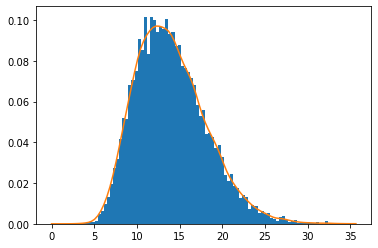

Histogram for F Test feature  1


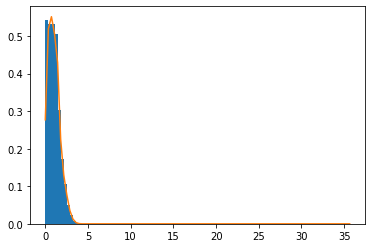

Histogram for F Test feature  2


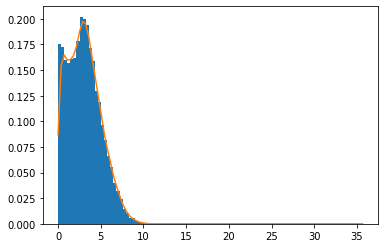

Histogram for F Test feature  3


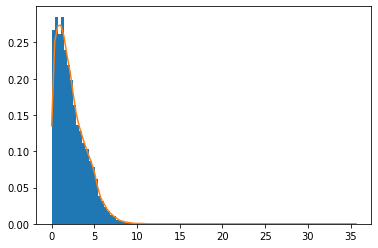

Histogram for F Test feature  4


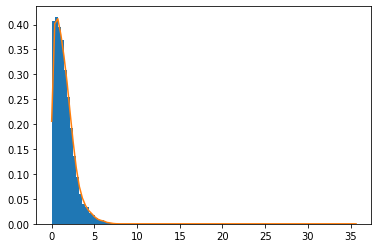

Histogram for F Test feature  5


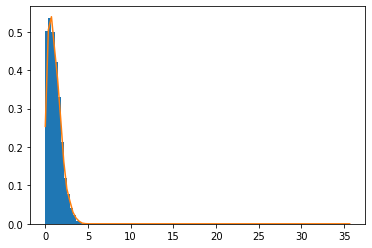

Histogram for F Test feature  6


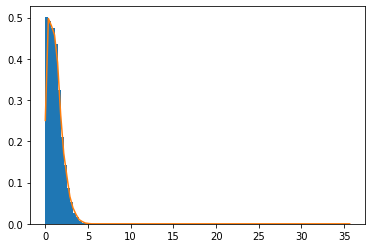

Histogram for F Test feature  7


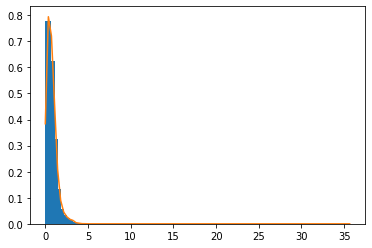

Histogram for F Test feature  8


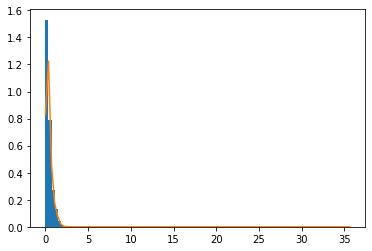

Histogram for F Test feature  9


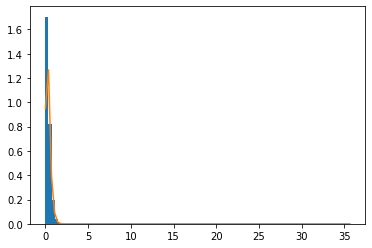

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR Accuracy within training data - All features :  0.942375
LR Accuracy on test data - All features:  0.43685
Accuracy for without feature  0
Logistic Regression Accuracy within training data:  0.9018
Logistic Regression Accuracy on test data:  0.4976
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9426
Logistic Regression Accuracy on test data:  0.4362
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.937625
Logistic Regression Accuracy on test data:  0.41505
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.94245
Logistic Regression Accuracy on test data:  0.44045
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.94265
Logistic Regression Accuracy on test data:  0.438
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.941175
Logistic Regression Accuracy on test data:  0.3924
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.933425
Logistic Regression Accuracy on test data:  0.3064
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9395
Logistic Regression Accuracy on test data:  0.38235
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.942325
Logistic Regression Accuracy on test data:  0.4132
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.93295
Logistic Regression Accuracy on test data:  0.3553




Results for lamda  4



array([-4.52316350e+00, -3.13559139e+00, -1.89749720e+00, -7.73099021e-01,
       -4.98477577e-01, -3.42609643e-01, -1.85729103e-01, -8.47088936e-02,
       -1.38394225e-02,  6.10619865e-15,  1.16652098e-02,  1.33336828e-02,
        1.92333564e-02,  2.12224197e-02,  2.81598608e-02,  3.13706477e-02,
        4.47638558e-02,  5.41458352e-02,  5.53140134e-02,  6.75380845e-02,
        8.50198466e-02,  9.69162173e-02,  1.00485976e-01,  1.29336286e-01,
        1.50541533e-01,  1.74295420e-01,  2.21358865e-01,  2.45014377e-01,
        2.87499235e-01,  3.36566293e-01,  3.54323241e-01,  3.99244050e-01,
        4.04227808e-01,  4.71749118e-01,  5.26350964e-01,  6.01245196e-01,
        6.63641198e-01,  7.64209111e-01,  8.62879953e-01,  9.97216593e-01,
        1.19296028e+00,  1.25995177e+00,  1.51846953e+00,  1.76965860e+00,
        2.76540406e+00,  5.94019548e+00,  6.59360694e+00,  8.70662857e+00,
        1.51732179e+01,  8.65233660e+02])

array([[ 0.11107817,  0.26731825, -0.13931336, ..., -0.05215574,
         0.15745852,  0.12475594],
       [ 0.09389827,  0.35312475,  0.1211247 , ..., -0.22145195,
         0.102326  ,  0.10849486],
       [ 0.06786383,  0.21493461, -0.00315727, ...,  0.00742739,
        -0.00311931,  0.11707801],
       ...,
       [ 0.18500334, -0.00333635,  0.1417294 , ..., -0.14429609,
        -0.28850134,  0.12665783],
       [-0.11133473,  0.06529306, -0.07669731, ...,  0.04493499,
         0.04048137,  0.16644706],
       [-0.12988163, -0.07708929,  0.10144288, ..., -0.05933694,
         0.07173547,  0.1861167 ]])

Printing least k eigenvalues before removing the zero eigenvalue
[-4.5231635  -3.13559139 -1.8974972  -0.77309902 -0.49847758 -0.34260964
 -0.1857291  -0.08470889 -0.01383942  0.        ]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-4.5231635  -3.13559139 -1.8974972  -0.77309902 -0.49847758 -0.34260964
 -0.1857291  -0.08470889 -0.01383942]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,11.722137,1.476784,0.628852,3.608276,1.666380,2.329870,1.707897,1.655394,0.331769,0.701614
1,12.602412,1.260895,3.389807,1.684014,0.766468,0.594982,1.849463,0.056372,1.202830,0.360954
2,7.978467,0.410922,2.787315,0.149433,0.328390,0.701610,1.301193,1.161304,0.265443,0.606364
3,9.586573,0.247318,2.334898,0.242519,1.077291,0.165337,1.344175,0.601493,0.211172,0.087181
4,19.046872,1.328867,6.645501,4.535556,3.726045,1.067187,0.204287,0.888447,0.212336,0.287173


Histogram for F Test feature  0


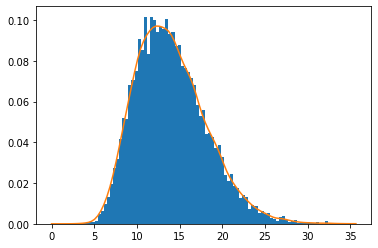

Histogram for F Test feature  1


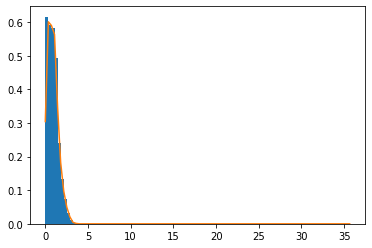

Histogram for F Test feature  2


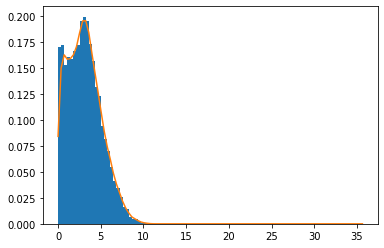

Histogram for F Test feature  3


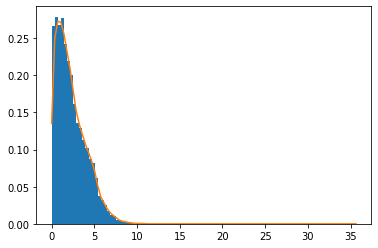

Histogram for F Test feature  4


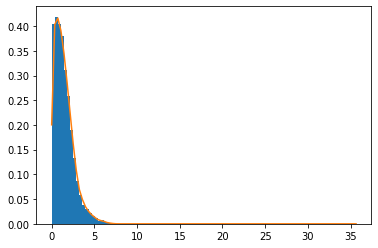

Histogram for F Test feature  5


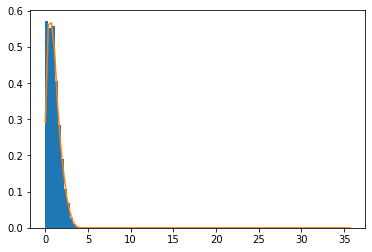

Histogram for F Test feature  6


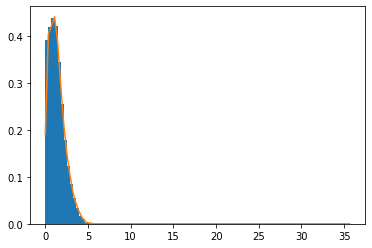

Histogram for F Test feature  7


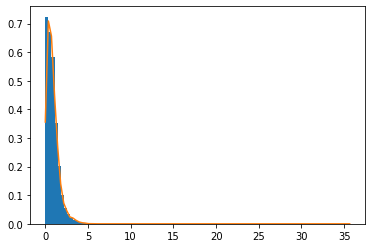

Histogram for F Test feature  8


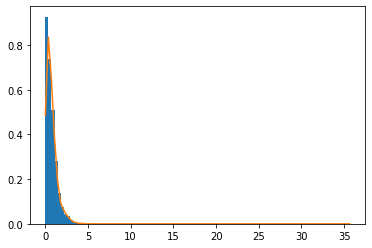

Histogram for F Test feature  9


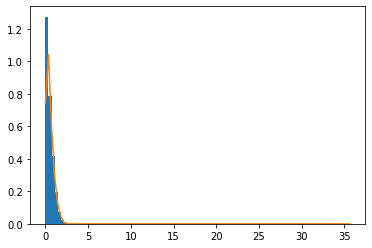

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR Accuracy within training data - All features :  0.943425
LR Accuracy on test data - All features:  0.45055
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.901525
Logistic Regression Accuracy on test data:  0.51175
Accuracy for without feature  1
Logistic Regression Accuracy within training data:  0.943675
Logistic Regression Accuracy on test data:  0.44845
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.94
Logistic Regression Accuracy on test data:  0.43295
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.94355
Logistic Regression Accuracy on test data:  0.45255
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.943225
Logistic Regression Accuracy on test data:  0.44465
Accuracy for without feature  5
Logistic Regression Accuracy within training data:  0.937725
Logistic Regression Accuracy on test data:  0.3363
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9376
Logistic Regression Accuracy on test data:  0.36965
Accuracy for without feature  7
Logistic Regression Accuracy within training data:  0.94095
Logistic Regression Accuracy on test data:  0.3658
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.94515
Logistic Regression Accuracy on test data:  0.45385
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.934975
Logistic Regression Accuracy on test data:  0.37875




Results for lamda  3



array([-5.07731371e+00, -3.25171325e+00, -2.02398368e+00, -9.34739030e-01,
       -7.00141675e-01, -4.93196568e-01, -3.53184571e-01, -1.85010193e-01,
       -6.92160652e-02,  2.23881736e-14,  2.18502042e-03,  5.95595429e-03,
        9.23707586e-03,  9.74762948e-03,  1.31917120e-02,  1.81796722e-02,
        2.17866564e-02,  2.61789358e-02,  3.36013965e-02,  3.60614279e-02,
        5.18931098e-02,  5.76414429e-02,  6.19292077e-02,  7.54497113e-02,
        1.00525693e-01,  1.11426088e-01,  1.36062394e-01,  1.65247806e-01,
        1.75971566e-01,  2.25748554e-01,  2.44781657e-01,  2.75910574e-01,
        2.86666874e-01,  3.18625673e-01,  3.73531477e-01,  4.03867971e-01,
        4.58834495e-01,  5.39565898e-01,  5.89186978e-01,  7.04865140e-01,
        8.23745199e-01,  8.96976314e-01,  1.05349019e+00,  1.23049651e+00,
        1.90582316e+00,  4.29458462e+00,  4.56941422e+00,  6.29534224e+00,
        1.10781062e+01,  6.24983946e+02])

array([[ 0.13720036, -0.28132142,  0.14778369, ..., -0.06198802,
         0.16386493,  0.1229842 ],
       [ 0.08854535, -0.34039439, -0.11876313, ..., -0.21764777,
         0.10369132,  0.107771  ],
       [ 0.06280413, -0.21199864,  0.00970086, ...,  0.01520877,
        -0.00616839,  0.11665916],
       ...,
       [ 0.18471398,  0.00662594, -0.13983184, ..., -0.15211802,
        -0.28370798,  0.12477266],
       [-0.11120637, -0.065082  ,  0.07243201, ...,  0.04869614,
         0.043476  ,  0.16753934],
       [-0.13195909,  0.07052646, -0.1016159 , ..., -0.05994948,
         0.07303422,  0.18747847]])

Printing least k eigenvalues before removing the zero eigenvalue
[-5.07731371 -3.25171325 -2.02398368 -0.93473903 -0.70014167 -0.49319657
 -0.35318457 -0.18501019 -0.06921607  0.        ]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-5.07731371 -3.25171325 -2.02398368 -0.93473903 -0.70014167 -0.49319657
 -0.35318457 -0.18501019 -0.06921607]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,11.722137,1.503217,0.738585,3.521603,1.014675,2.455491,2.750855,1.200683,0.353312,0.803914
1,12.602412,1.183774,3.432004,1.704733,0.908885,0.228474,1.819199,0.602878,1.315411,0.387108
2,7.978467,0.268544,2.782670,0.105756,0.120451,0.487743,1.887776,0.868862,0.188987,0.806707
3,9.586573,0.177593,2.323242,0.282268,1.061059,0.280933,1.041727,1.091048,0.303382,0.080517
4,19.046872,1.033437,6.776309,4.660326,3.369334,1.661790,0.573840,1.081209,0.359694,0.447970


Histogram for F Test feature  0


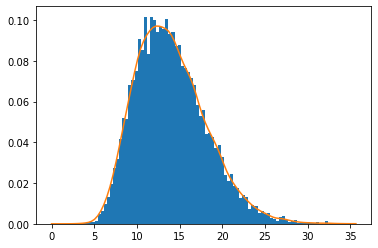

Histogram for F Test feature  1


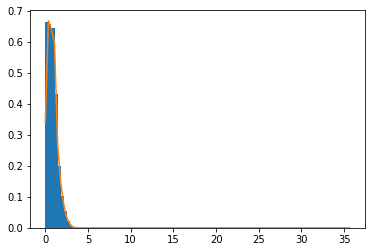

Histogram for F Test feature  2


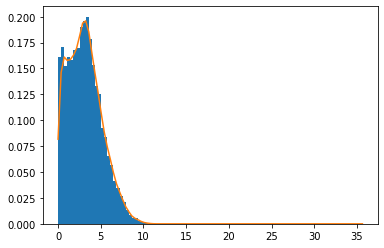

Histogram for F Test feature  3


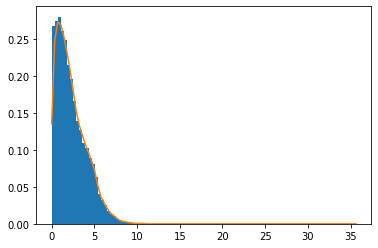

Histogram for F Test feature  4


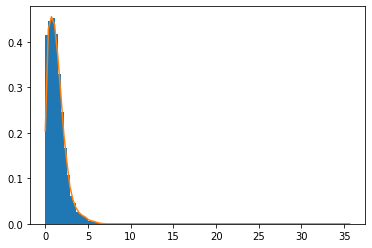

Histogram for F Test feature  5


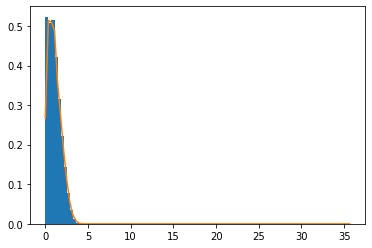

Histogram for F Test feature  6


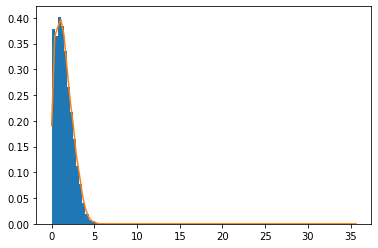

Histogram for F Test feature  7


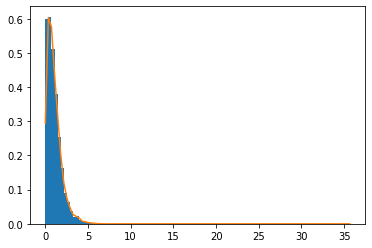

Histogram for F Test feature  8


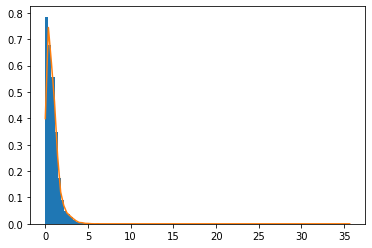

Histogram for F Test feature  9


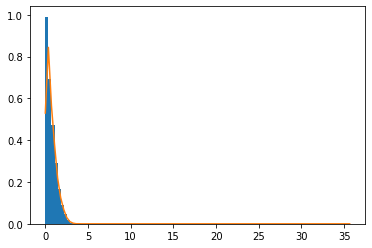

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR Accuracy within training data - All features :  0.944425
LR Accuracy on test data - All features:  0.4687
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.90295
Logistic Regression Accuracy on test data:  0.54035
Accuracy for without feature  1
Logistic Regression Accuracy within training data:  0.9443
Logistic Regression Accuracy on test data:  0.4639
Accuracy for without feature  2
Logistic Regression Accuracy within training data:  0.94135
Logistic Regression Accuracy on test data:  0.46315
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.94455
Logistic Regression Accuracy on test data:  0.4665
Accuracy for without feature  4
Logistic Regression Accuracy within training data:  0.942375
Logistic Regression Accuracy on test data:  0.42785
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9367
Logistic Regression Accuracy on test data:  0.3145
Accuracy for without feature  6
Logistic Regression Accuracy within training data:  0.942625


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy on test data:  0.4519
Accuracy for without feature  7
Logistic Regression Accuracy within training data:  0.9398
Logistic Regression Accuracy on test data:  0.3607
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.94605
Logistic Regression Accuracy on test data:  0.47315
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9367
Logistic Regression Accuracy on test data:  0.3999




Results for lamda  2



array([-5.93483943e+00, -3.37697902e+00, -2.16576739e+00, -1.20317250e+00,
       -9.22291281e-01, -7.12900374e-01, -5.19874268e-01, -3.08413908e-01,
       -1.60219983e-01, -5.85857109e-02, -1.26809723e-02, -9.40589035e-03,
       -2.28245604e-03, -4.49611749e-04, -5.89541124e-17,  3.87131768e-03,
        6.76766945e-03,  7.50636636e-03,  1.26966927e-02,  1.50344455e-02,
        1.69529248e-02,  2.52404917e-02,  2.87397417e-02,  3.20446750e-02,
        4.41919553e-02,  5.02580252e-02,  6.34226574e-02,  7.75437210e-02,
        9.04115385e-02,  1.23216591e-01,  1.40898646e-01,  1.58164839e-01,
        1.70393149e-01,  1.75332158e-01,  2.24049035e-01,  2.28748576e-01,
        2.59103716e-01,  3.15137814e-01,  3.37249045e-01,  4.18860501e-01,
        4.74142314e-01,  5.49518685e-01,  6.20480850e-01,  7.12848315e-01,
        1.09436134e+00,  2.52448335e+00,  2.71038388e+00,  3.90561359e+00,
        7.00242202e+00,  3.85004434e+02])

array([[ 0.16351628, -0.29684425,  0.15232705, ..., -0.07464444,
         0.17640416,  0.1190014 ],
       [ 0.08172827, -0.32521334, -0.11309916, ..., -0.21036498,
         0.10596177,  0.10612167],
       [ 0.05647235, -0.20928937,  0.02135939, ...,  0.03046271,
        -0.01317477,  0.11568639],
       ...,
       [ 0.18514723,  0.00707994, -0.13387135, ..., -0.16297592,
        -0.27312614,  0.12053148],
       [-0.10824859, -0.06458483,  0.06646705, ...,  0.05647865,
         0.04897524,  0.16991202],
       [-0.1300583 ,  0.06457951, -0.10250065, ..., -0.06125099,
         0.07527946,  0.19044426]])

Printing least k eigenvalues before removing the zero eigenvalue
[-5.93483943 -3.37697902 -2.16576739 -1.2031725  -0.92229128 -0.71290037
 -0.51987427 -0.30841391 -0.16021998 -0.05858571]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-5.93483943 -3.37697902 -2.16576739 -1.2031725  -0.92229128 -0.71290037
 -0.51987427 -0.30841391 -0.16021998]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,11.722137,1.517853,0.859588,3.409675,0.223019,2.229711,3.630256,0.118803,0.279808,0.777806
1,12.602412,1.132635,3.472116,1.710860,1.085728,0.152612,1.319060,1.342140,1.395349,0.367574
2,7.978467,0.141395,2.762828,0.043198,0.245936,0.108905,2.305399,0.130354,0.169871,0.857763
3,9.586573,0.131715,2.308046,0.315548,0.927714,0.619532,0.303730,1.485520,0.454328,0.084056
4,19.046872,0.800216,6.891882,4.764427,2.608505,2.170237,1.698065,0.849572,0.536430,0.478028


Histogram for F Test feature  0


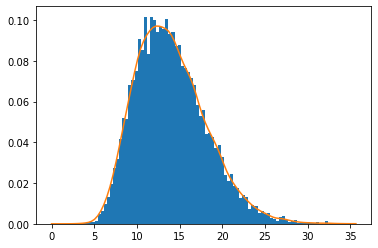

Histogram for F Test feature  1


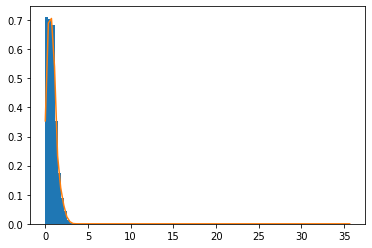

Histogram for F Test feature  2


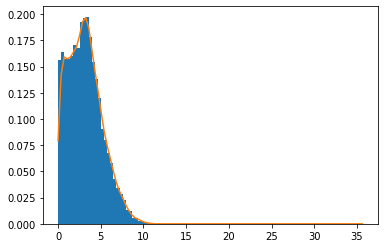

Histogram for F Test feature  3


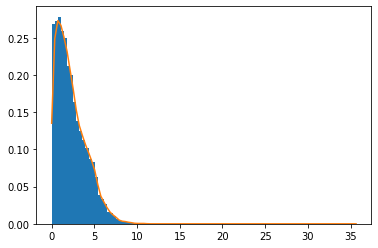

Histogram for F Test feature  4


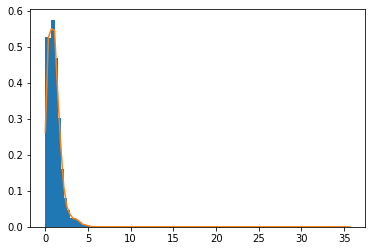

Histogram for F Test feature  5


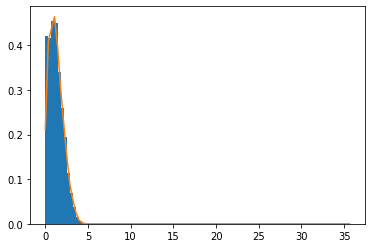

Histogram for F Test feature  6


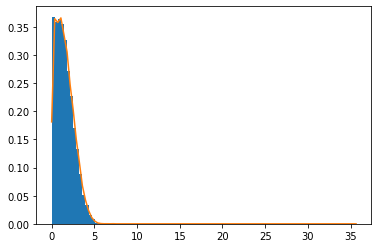

Histogram for F Test feature  7


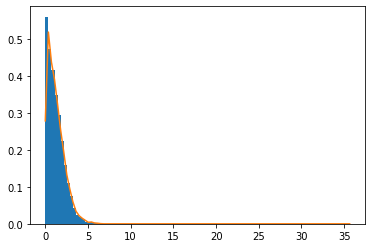

Histogram for F Test feature  8


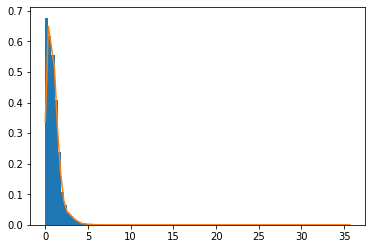

Histogram for F Test feature  9


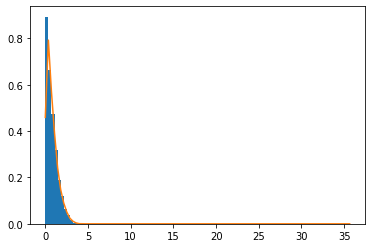

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])
LR Accuracy within training data - All features :  0.9451
LR Accuracy on test data - All features:  0.49455
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.907075
Logistic Regression Accuracy on test data:  0.5815
Accuracy for without feature  1
Logistic Regression Accuracy within training data:  0.945375
Logistic Regression Accuracy on test data:  0.4922
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.943675
Logistic Regression Accuracy on test data:  0.4979
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.94525
Logistic Regression Accuracy on test data:  0.48725
Accuracy for without feature  4
Logistic Regression Accuracy within training data:  0.934775
Logistic Regression Accuracy on test data:  0.3003
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9362
Logistic Regression Accuracy on test data:  0.3482
Accuracy for without feature  6
Logistic Regression Accuracy within training data:  0.94505
Logistic Regression Accuracy on test data:  0.4924
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9394
Logistic Regression Accuracy on test data:  0.38435
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.946625
Logistic Regression Accuracy on test data:  0.48805
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.93945
Logistic Regression Accuracy on test data:  0.43325




Results for lamda  1



array([-8.36088935e+00, -3.52257015e+00, -2.33314350e+00, -1.64157641e+00,
       -1.21784492e+00, -9.82103297e-01, -7.04846176e-01, -5.07204902e-01,
       -3.07445192e-01, -2.74471390e-01, -9.32819836e-02, -5.76473004e-02,
       -5.27972979e-02, -4.35254533e-02, -1.97429452e-02, -1.64492959e-02,
       -1.51945938e-02, -4.68665332e-03, -3.67369610e-03, -7.41035453e-04,
        1.19031889e-15,  2.19695273e-03,  2.54125118e-03,  3.32490064e-03,
        5.43008339e-03,  6.82389883e-03,  1.25092773e-02,  1.60152539e-02,
        2.04440942e-02,  2.93977085e-02,  3.57914393e-02,  4.38543420e-02,
        5.11901411e-02,  5.98483293e-02,  6.48732265e-02,  7.89995860e-02,
        8.86925086e-02,  1.03945401e-01,  1.22058140e-01,  1.44713517e-01,
        1.66134173e-01,  2.03120615e-01,  2.20115316e-01,  2.43315689e-01,
        3.84539593e-01,  7.29193880e-01,  1.08167045e+00,  1.58026916e+00,
        2.99844019e+00,  1.46556427e+02])

array([[ 0.19293308, -0.31330393, -0.14664599, ..., -0.07720181,
         0.20941454,  0.1021792 ],
       [ 0.08270556, -0.30222005,  0.09902889, ..., -0.19271066,
         0.10949855,  0.0988402 ],
       [ 0.05726873, -0.2062978 , -0.04465619, ...,  0.06842785,
        -0.03914717,  0.11113435],
       ...,
       [ 0.19356813,  0.00141689,  0.11735118, ..., -0.1665515 ,
        -0.2365615 ,  0.10256693],
       [-0.09173832, -0.06462008, -0.05756411, ...,  0.08283265,
         0.06227969,  0.178761  ],
       [-0.11361454,  0.05896247,  0.10571397, ..., -0.06292453,
         0.08020577,  0.20161807]])

Printing least k eigenvalues before removing the zero eigenvalue
[-8.36088935 -3.52257015 -2.3331435  -1.64157641 -1.21784492 -0.9821033
 -0.70484618 -0.5072049  -0.30744519 -0.27447139]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-8.36088935 -3.52257015 -2.3331435  -1.64157641 -1.21784492 -0.9821033
 -0.70484618 -0.5072049  -0.30744519]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,11.722137,1.507384,1.030417,3.243497,1.284473,0.703361,4.200494,0.588712,0.288973,0.542565
1,12.602412,1.107892,3.534789,1.667292,1.250489,0.359534,0.707435,1.691027,1.375019,0.146747
2,7.978467,0.009821,2.716365,0.056645,0.581045,0.880673,2.222291,0.339044,0.111936,0.884662
3,9.586573,0.113553,2.296556,0.314813,0.822614,0.460687,0.379304,1.582726,0.579280,0.220824
4,19.046872,0.653129,6.989508,4.825617,2.102365,1.322304,2.846770,0.559126,0.531631,0.374740


Histogram for F Test feature  0


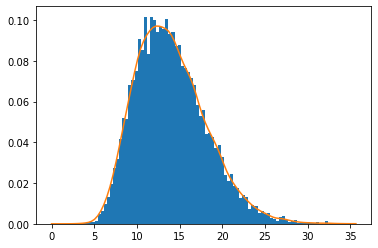

Histogram for F Test feature  1


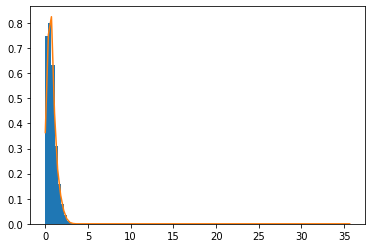

Histogram for F Test feature  2


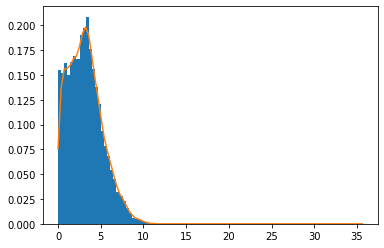

Histogram for F Test feature  3


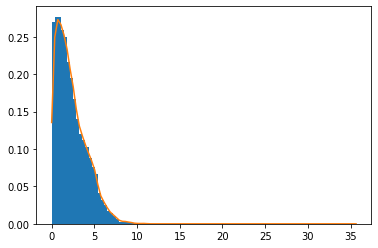

Histogram for F Test feature  4


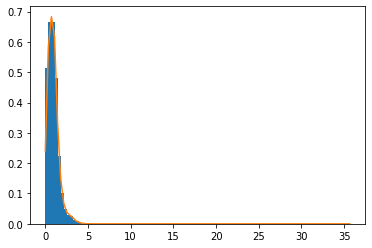

Histogram for F Test feature  5


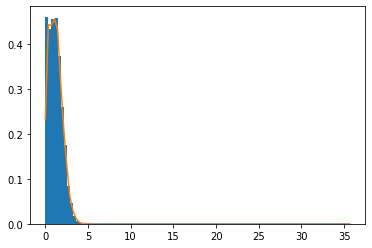

Histogram for F Test feature  6


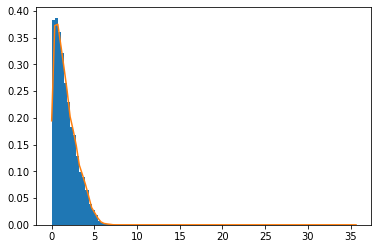

Histogram for F Test feature  7


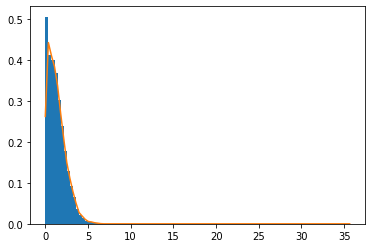

Histogram for F Test feature  8


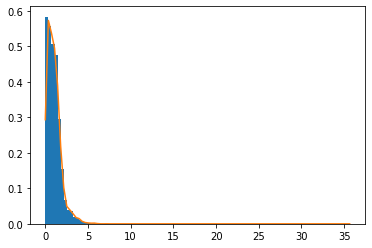

Histogram for F Test feature  9


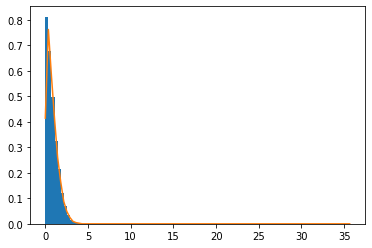

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])
LR Accuracy within training data - All features :  0.9538
LR Accuracy on test data - All features:  0.60955
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.92
Logistic Regression Accuracy on test data:  0.673
Accuracy for without feature  1
Logistic Regression Accuracy within training data:  0.9537


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy on test data:  0.60855
Accuracy for without feature  2
Logistic Regression Accuracy within training data:  0.952775
Logistic Regression Accuracy on test data:  0.61415
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.95375
Logistic Regression Accuracy on test data:  0.60535
Accuracy for without feature  4
Logistic Regression Accuracy within training data:  0.9324
Logistic Regression Accuracy on test data:  0.25365
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.944
Logistic Regression Accuracy on test data:  0.48995
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.951225
Logistic Regression Accuracy on test data:  0.56735
Accuracy for without feature  7
Logistic Regression Accuracy within training data:  0.9458
Logistic Regression Accuracy on test data:  0.4886
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.945625
Logistic Regression Accuracy on test data:  0.51005
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9519
Logistic Regression Accuracy on test data:  0.5938




Results for lamda  0.1



array([-7.99108118e+01, -3.72379490e+00, -2.55213992e+00, -2.31855263e+00,
       -1.86291429e+00, -1.52918914e+00, -1.27052305e+00, -1.00291118e+00,
       -8.28019152e-01, -6.40972756e-01, -3.91219911e-01, -3.39909168e-01,
       -3.22872715e-01, -2.24679414e-01, -1.81120618e-01, -1.31447844e-01,
       -1.25113852e-01, -1.17721483e-01, -1.09016441e-01, -8.36546610e-02,
       -7.10303409e-02, -6.11057209e-02, -5.16929425e-02, -4.58814804e-02,
       -4.18818517e-02, -3.74875470e-02, -2.97282961e-02, -2.88756672e-02,
       -2.66548570e-02, -2.31120709e-02, -1.92611179e-02, -1.42282934e-02,
       -1.34600426e-02, -1.02047364e-02, -9.09904636e-03, -7.32122239e-03,
       -6.83177054e-03, -5.16852221e-03, -4.48698063e-03, -3.63868502e-03,
       -2.65644739e-03, -2.43856235e-03, -2.18024116e-03, -1.27186862e-03,
        1.80824598e-16,  8.16344823e-04,  1.53271764e-03,  1.05464553e-02,
        7.13967774e-02,  1.39147224e+00])

array([[-0.17496692,  0.31411586,  0.06632771, ..., -0.01373951,
         0.07613947,  0.11483393],
       [-0.12572854,  0.25126294, -0.05975726, ...,  0.14378434,
         0.01147974,  0.05436179],
       [-0.12430092,  0.19997499,  0.09609783, ..., -0.03708811,
        -0.16330629,  0.01158983],
       ...,
       [-0.17963052,  0.03092047, -0.03230296, ...,  0.01290152,
        -0.08404008,  0.16878558],
       [-0.12311469,  0.06908996,  0.04491653, ..., -0.1249859 ,
         0.04534125, -0.16861284],
       [-0.1332466 , -0.05206035, -0.11028623, ...,  0.17210043,
         0.05601812, -0.19714911]])

Printing least k eigenvalues before removing the zero eigenvalue
[-79.91081184  -3.7237949   -2.55213992  -2.31855263  -1.86291429
  -1.52918914  -1.27052305  -1.00291118  -0.82801915  -0.64097276]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-79.91081184  -3.7237949   -2.55213992  -2.31855263  -1.86291429
  -1.52918914  -1.27052305  -1.00291118  -0.82801915]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,11.722137,1.096841,1.424607,2.551002,2.758057,0.092317,2.413656,1.791724,2.633486,0.553104
1,12.602412,1.019160,3.715867,1.261773,1.592819,0.488766,0.480733,1.752033,0.426307,0.796014
2,7.978467,0.316297,2.554429,0.410341,1.098858,1.324503,0.825195,1.025902,1.163752,0.133891
3,9.586573,0.382843,2.317886,0.111190,0.673875,0.469957,0.088638,1.237518,1.209956,0.584756
4,19.046872,0.720917,6.964205,4.358808,3.008079,0.154246,1.699845,0.127907,2.602338,0.918445


Histogram for F Test feature  0


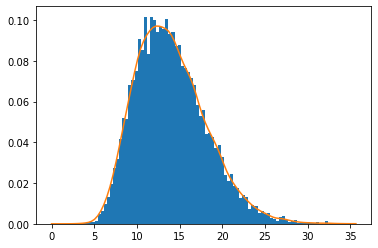

Histogram for F Test feature  1


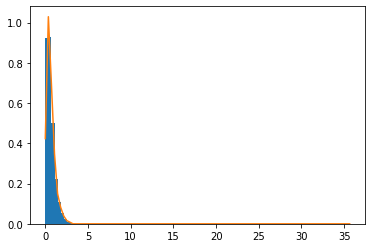

Histogram for F Test feature  2


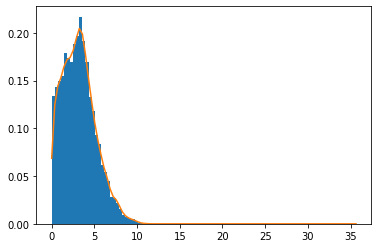

Histogram for F Test feature  3


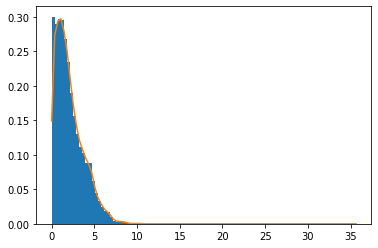

Histogram for F Test feature  4


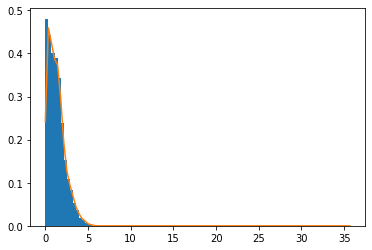

Histogram for F Test feature  5


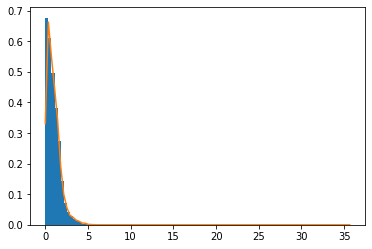

Histogram for F Test feature  6


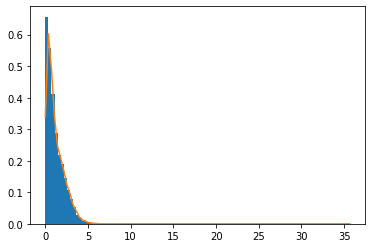

Histogram for F Test feature  7


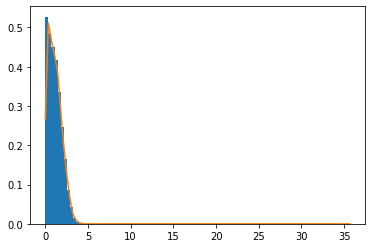

Histogram for F Test feature  8


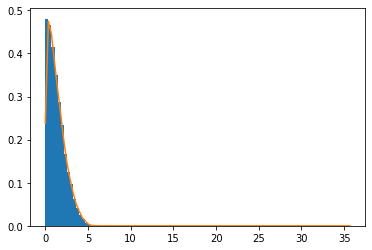

Histogram for F Test feature  9


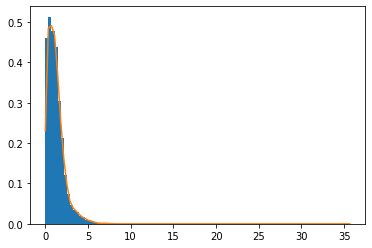

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR Accuracy within training data - All features :  0.974425
LR Accuracy on test data - All features:  0.8084
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.964275
Logistic Regression Accuracy on test data:  0.834
Accuracy for without feature  1
Logistic Regression Accuracy within training data:  0.974375
Logistic Regression Accuracy on test data:  0.8079
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9742
Logistic Regression Accuracy on test data:  0.80755
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.970575
Logistic Regression Accuracy on test data:  0.77025
Accuracy for without feature  4
Logistic Regression Accuracy within training data:  0.95015
Logistic Regression Accuracy on test data:  0.4905
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9742
Logistic Regression Accuracy on test data:  0.80805
Accuracy for without feature  6
Logistic Regression Accuracy within training data:  0.969475
Logistic Regression Accuracy on test data:  0.7679
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.942375
Logistic Regression Accuracy on test data:  0.4924
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.97425
Logistic Regression Accuracy on test data:  0.80755
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.97325
Logistic Regression Accuracy on test data:  0.80145




Results for lamda  0.01



array([-1.00118001e+02, -3.75815266e+00, -2.59418694e+00, -2.44154650e+00,
       -1.97209322e+00, -1.69957571e+00, -1.38456643e+00, -1.06337344e+00,
       -8.95844117e-01, -7.08389942e-01, -5.05101245e-01, -4.24570008e-01,
       -3.98546256e-01, -2.50816076e-01, -2.19646324e-01, -1.49025779e-01,
       -1.46397473e-01, -1.39457945e-01, -1.28014834e-01, -1.01468395e-01,
       -9.04179078e-02, -8.45446307e-02, -7.00570325e-02, -6.63879703e-02,
       -5.94601609e-02, -5.47752878e-02, -5.11225358e-02, -4.16109345e-02,
       -3.79360162e-02, -3.55847077e-02, -3.32164027e-02, -2.52189410e-02,
       -2.30844006e-02, -2.16353846e-02, -1.78557474e-02, -1.43220439e-02,
       -1.39309099e-02, -1.15129069e-02, -1.13296159e-02, -9.99169599e-03,
       -8.08210856e-03, -5.99349936e-03, -5.08440794e-03, -4.07393064e-03,
       -3.50201242e-03, -2.92669064e-03, -2.50774705e-03, -2.33349660e-03,
        1.08578838e-15,  3.60991335e-02])

array([[-0.1667031 ,  0.30811967,  0.01144763, ...,  0.00322505,
        -0.13980415,  0.10202403],
       [-0.12344632,  0.24032192,  0.05292055, ..., -0.01626558,
         0.06067927,  0.10686386],
       [-0.12389867,  0.1979652 , -0.10284571, ..., -0.02630085,
         0.06512126,  0.04029148],
       ...,
       [-0.17098498,  0.04018803, -0.02142524, ..., -0.02830755,
        -0.12935665,  0.09811266],
       [-0.13234635,  0.07069959, -0.04626125, ..., -0.0003747 ,
        -0.19125141, -0.11235189],
       [-0.14436991, -0.05037945,  0.10044735, ..., -0.08144153,
         0.2233117 , -0.15844924]])

Printing least k eigenvalues before removing the zero eigenvalue
[-100.11800142   -3.75815266   -2.59418694   -2.4415465    -1.97209322
   -1.69957571   -1.38456643   -1.06337344   -0.89584412   -0.70838994]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-100.11800142   -3.75815266   -2.59418694   -2.4415465    -1.97209322
   -1.69957571   -1.38456643   -1.06337344   -0.89584412]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,11.722137,1.039508,1.517831,1.920891,3.293982,0.056890,1.987212,1.324973,3.101247,0.225627
1,12.602412,0.983172,3.758572,0.934206,1.752816,0.675920,0.609236,1.603347,0.317992,0.628692
2,7.978467,0.323198,2.506323,0.664994,1.105696,1.267958,0.604712,0.833225,1.384370,0.011094
3,9.586573,0.390678,2.325157,0.005563,0.596222,0.588593,0.125418,1.190240,1.163300,0.329599
4,19.046872,0.703269,6.921508,3.669082,3.851316,0.124865,1.244331,0.227759,2.992684,0.603866


Histogram for F Test feature  0


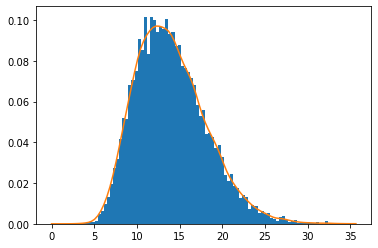

Histogram for F Test feature  1


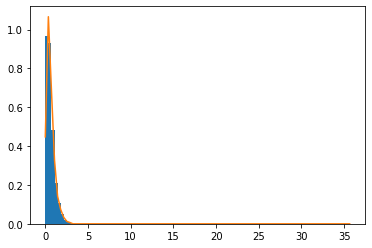

Histogram for F Test feature  2


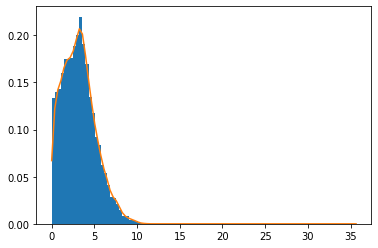

Histogram for F Test feature  3


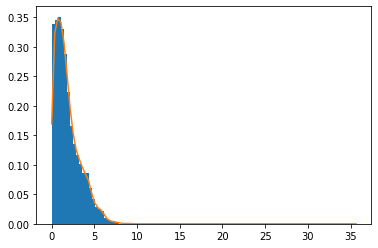

Histogram for F Test feature  4


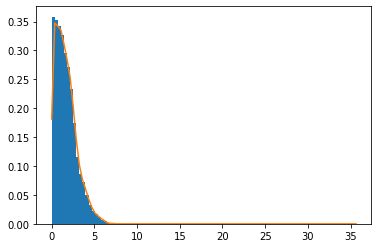

Histogram for F Test feature  5


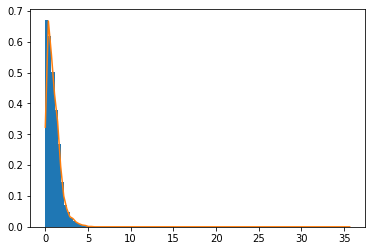

Histogram for F Test feature  6


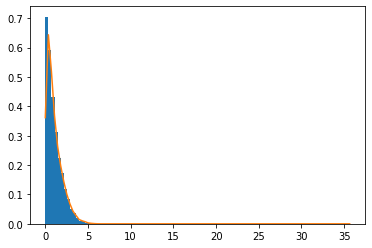

Histogram for F Test feature  7


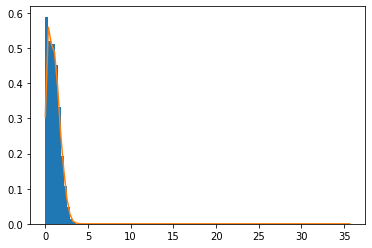

Histogram for F Test feature  8


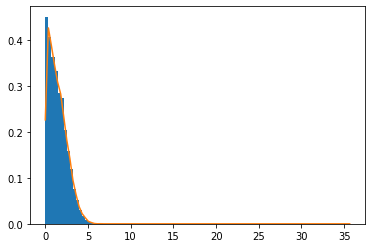

Histogram for F Test feature  9


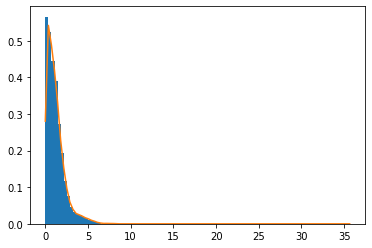

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR Accuracy within training data - All features :  0.97445
LR Accuracy on test data - All features:  0.81145
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.96545
Logistic Regression Accuracy on test data:  0.8409
Accuracy for without feature  1
Logistic Regression Accuracy within training data:  0.974525
Logistic Regression Accuracy on test data:  0.8115
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.974625
Logistic Regression Accuracy on test data:  0.81145
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9662
Logistic Regression Accuracy on test data:  0.7195
Accuracy for without feature  4
Logistic Regression Accuracy within training data:  0.949775
Logistic Regression Accuracy on test data:  0.5289
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.974125
Logistic Regression Accuracy on test data:  0.80995
Accuracy for without feature  6
Logistic Regression Accuracy within training data:  0.9729
Logistic Regression Accuracy on test data:  0.801
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.941325
Logistic Regression Accuracy on test data:  0.4659
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9746
Logistic Regression Accuracy on test data:  0.81125
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.973825
Logistic Regression Accuracy on test data:  0.80695




Results for lamda  0.001



array([-1.02169978e+02, -3.76195599e+00, -2.59981064e+00, -2.45460691e+00,
       -1.98345564e+00, -1.71880789e+00, -1.39620446e+00, -1.06938665e+00,
       -9.02645366e-01, -7.18048594e-01, -5.22909278e-01, -4.34447353e-01,
       -4.04673276e-01, -2.53638416e-01, -2.27327968e-01, -1.51054697e-01,
       -1.48756799e-01, -1.41771036e-01, -1.32571737e-01, -1.09307440e-01,
       -1.02447113e-01, -8.71133589e-02, -7.90721476e-02, -6.94877340e-02,
       -6.10959011e-02, -5.68162992e-02, -5.36201062e-02, -4.62484686e-02,
       -3.99591028e-02, -3.80404412e-02, -3.60410228e-02, -3.14260908e-02,
       -2.63141069e-02, -2.48453097e-02, -1.94188445e-02, -1.58141432e-02,
       -1.46235238e-02, -1.39925289e-02, -1.21031406e-02, -1.12157076e-02,
       -1.05283118e-02, -8.33826130e-03, -6.16869764e-03, -5.30152696e-03,
       -4.19118880e-03, -3.61523428e-03, -3.15608242e-03, -2.49934438e-03,
       -2.38826858e-03,  3.57317162e-16])

array([[-0.16602061,  0.30730614,  0.025634  , ..., -0.0084738 ,
        -0.00596622,  0.13980415],
       [-0.12324519,  0.23908572,  0.0522305 , ..., -0.00421528,
        -0.03600403, -0.06067927],
       [-0.12384749,  0.1977143 , -0.1029419 , ...,  0.01708729,
        -0.01330722, -0.06512126],
       ...,
       [-0.17026934,  0.0412664 , -0.03033496, ...,  0.02809567,
         0.00850261,  0.12935665],
       [-0.13306074,  0.070893  , -0.04665297, ...,  0.02881416,
         0.08529328,  0.19125141],
       [-0.14523318, -0.05017277,  0.09797773, ...,  0.17031769,
         0.47165649, -0.2233117 ]])

Printing least k eigenvalues before removing the zero eigenvalue
[-102.16997815   -3.76195599   -2.59981064   -2.45460691   -1.98345564
   -1.71880789   -1.39620446   -1.06938665   -0.90264537   -0.71804859]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-102.16997815   -3.76195599   -2.59981064   -2.45460691   -1.98345564
   -1.71880789   -1.39620446   -1.06938665   -0.90264537]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,11.722137,1.034810,1.528542,1.801004,3.366521,0.074164,1.940885,1.286091,3.128677,0.174266
1,12.602412,0.980175,3.763353,0.874211,1.776501,0.694750,0.614804,1.584105,0.314051,0.619398
2,7.978467,0.323698,2.500540,0.708196,1.092315,1.262451,0.584210,0.816951,1.394516,0.036707
3,9.586573,0.391250,2.325928,0.023871,0.584977,0.599450,0.140821,1.178675,1.161898,0.307667
4,19.046872,0.701762,6.915791,3.528751,3.984065,0.126418,1.201060,0.251321,3.026325,0.564801


Histogram for F Test feature  0


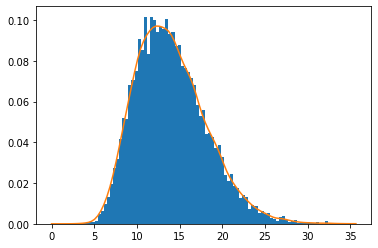

Histogram for F Test feature  1


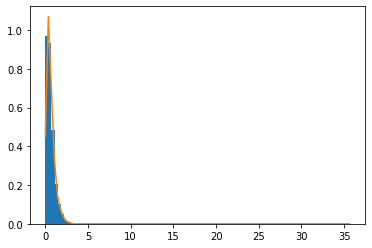

Histogram for F Test feature  2


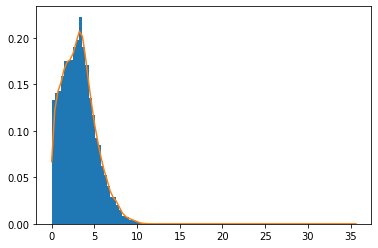

Histogram for F Test feature  3


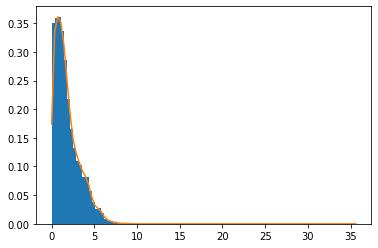

Histogram for F Test feature  4


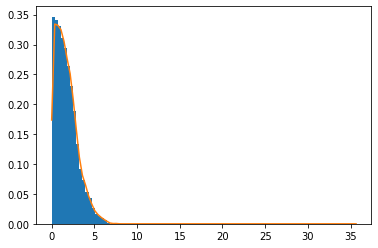

Histogram for F Test feature  5


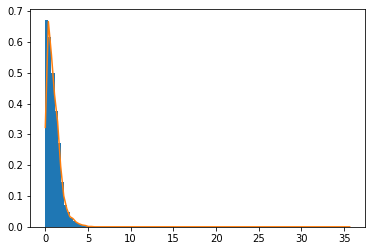

Histogram for F Test feature  6


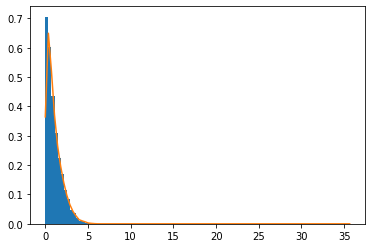

Histogram for F Test feature  7


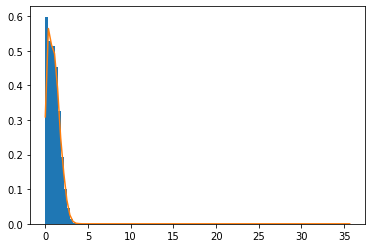

Histogram for F Test feature  8


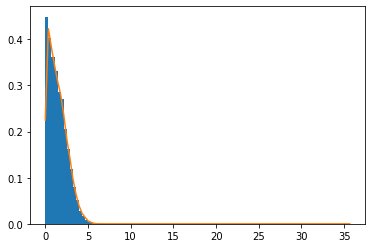

Histogram for F Test feature  9


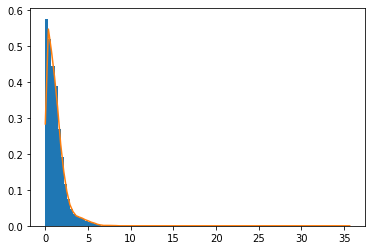

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR Accuracy within training data - All features :  0.97445
LR Accuracy on test data - All features:  0.8115
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.96565
Logistic Regression Accuracy on test data:  0.84135
Accuracy for without feature  1
Logistic Regression Accuracy within training data:  0.974425
Logistic Regression Accuracy on test data:  0.8116
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.974625
Logistic Regression Accuracy on test data:  0.8118
Accuracy for without feature  3
Logistic Regression Accuracy within training data:  0.9648
Logistic Regression Accuracy on test data:  0.7065
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9494
Logistic Regression Accuracy on test data:  0.53895
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.974075
Logistic Regression Accuracy on test data:  0.81045
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.973325
Logistic Regression Accuracy on test data:  0.80225
Accuracy for without feature  7
Logistic Regression Accuracy within training data:  0.941225
Logistic Regression Accuracy on test data:  0.4636
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.974575
Logistic Regression Accuracy on test data:  0.81135
Accuracy for without feature  9
Logistic Regression Accuracy within training data:  0.9739
Logistic Regression Accuracy on test data:  0.80715




Results for lamda  0.0001



/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([-1.02375424e+02, -3.76234059e+00, -2.60039784e+00, -2.45591304e+00,
       -1.98459668e+00, -1.72075071e+00, -1.39736962e+00, -1.06999167e+00,
       -9.03326629e-01, -7.19089677e-01, -5.24818977e-01, -4.35464108e-01,
       -4.05278886e-01, -2.53955224e-01, -2.28351565e-01, -1.51261621e-01,
       -1.49002427e-01, -1.42040024e-01, -1.33676993e-01, -1.12374207e-01,
       -1.02858725e-01, -8.73729870e-02, -7.99102498e-02, -6.98080910e-02,
       -6.12627643e-02, -5.70897698e-02, -5.38853572e-02, -4.72725406e-02,
       -4.03833152e-02, -3.83948770e-02, -3.63136714e-02, -3.21119404e-02,
       -2.64810841e-02, -2.50436548e-02, -1.96164384e-02, -1.60273081e-02,
       -1.48921371e-02, -1.45306505e-02, -1.21652594e-02, -1.14554188e-02,
       -1.06180060e-02, -8.44488943e-03, -6.18571255e-03, -5.33179346e-03,
       -4.20316555e-03, -3.62921019e-03, -3.18407162e-03, -2.51455861e-03,
       -2.43515425e-03, -1.24440838e-15])

array([[-0.16595359,  0.30722219,  0.02715345, ..., -0.00909887,
        -0.00539985,  0.13980415],
       [-0.12322535,  0.23896047,  0.05216159, ..., -0.00779748,
        -0.03664726, -0.06067927],
       [-0.12384233,  0.19768859, -0.10293679, ...,  0.01561124,
        -0.01448969, -0.06512126],
       ...,
       [-0.17019905,  0.04137597, -0.03127869, ...,  0.02812921,
         0.00536801,  0.12935665],
       [-0.13313052,  0.07091272, -0.04669535, ...,  0.03614829,
         0.08355934,  0.19125141],
       [-0.14531753, -0.05015162,  0.09770245, ...,  0.20998329,
         0.47782035, -0.2233117 ]])

Printing least k eigenvalues before removing the zero eigenvalue
[-102.37542356   -3.76234059   -2.60039784   -2.45591304   -1.98459668
   -1.72075071   -1.39736962   -1.06999167   -0.90332663   -0.71908968]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-102.37542356   -3.76234059   -2.60039784   -2.45591304   -1.98459668
   -1.72075071   -1.39736962   -1.06999167   -0.90332663]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,11.722137,1.034349,1.529629,1.788055,3.373946,0.075906,1.936213,1.282315,3.131165,0.168873
1,12.602412,0.979881,3.763836,0.867760,1.778938,0.696629,0.615263,1.582146,0.313780,0.618565
2,7.978467,0.323747,2.499950,0.712773,1.090706,1.261909,0.582181,0.815362,1.395364,0.039424
3,9.586573,0.391306,2.326005,0.025795,0.583791,0.600522,0.142282,1.177449,1.161839,0.305523
4,19.046872,0.701613,6.915202,3.513458,3.997941,0.126635,1.196776,0.253516,3.029679,0.560805


Histogram for F Test feature  0


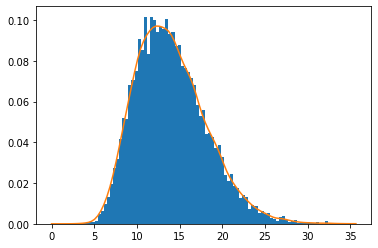

Histogram for F Test feature  1


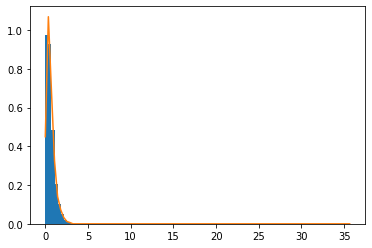

Histogram for F Test feature  2


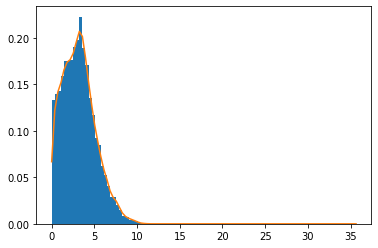

Histogram for F Test feature  3


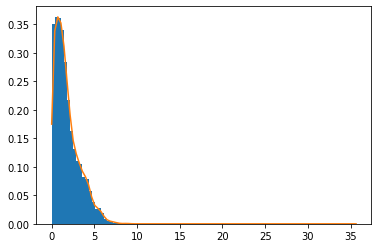

Histogram for F Test feature  4


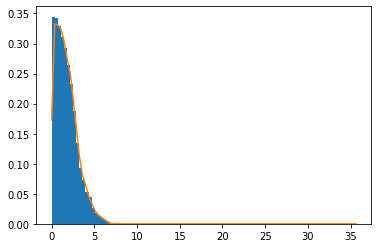

Histogram for F Test feature  5


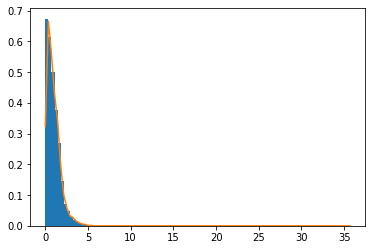

Histogram for F Test feature  6


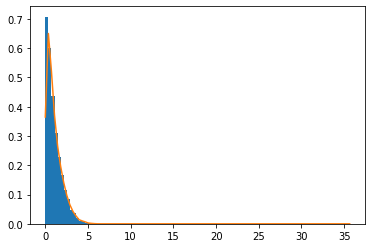

Histogram for F Test feature  7


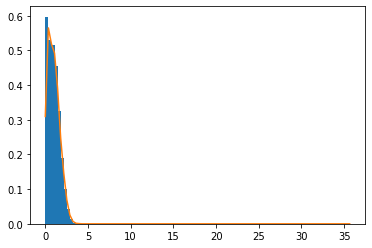

Histogram for F Test feature  8


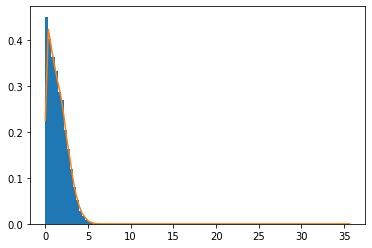

Histogram for F Test feature  9


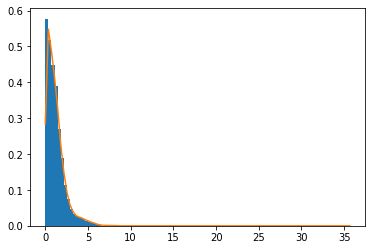

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR Accuracy within training data - All features :  0.97445
LR Accuracy on test data - All features:  0.8115
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.96565
Logistic Regression Accuracy on test data:  0.8413
Accuracy for without feature  1
Logistic Regression Accuracy within training data:  0.97445
Logistic Regression Accuracy on test data:  0.8115
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.97455
Logistic Regression Accuracy on test data:  0.81185
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.964575
Logistic Regression Accuracy on test data:  0.7051
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9493
Logistic Regression Accuracy on test data:  0.5402
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.974075
Logistic Regression Accuracy on test data:  0.8103
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.973375
Logistic Regression Accuracy on test data:  0.80245
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.941125
Logistic Regression Accuracy on test data:  0.4634
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.974625
Logistic Regression Accuracy on test data:  0.81125
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9739
Logistic Regression Accuracy on test data:  0.80725




Results for lamda  1e-05



array([-1.02395971e+02, -3.76237909e+00, -2.60045683e+00, -2.45604364e+00,
       -1.98471083e+00, -1.72094519e+00, -1.39748615e+00, -1.07005222e+00,
       -9.03394768e-01, -7.19194657e-01, -5.25011382e-01, -4.35566113e-01,
       -4.05339391e-01, -2.53987539e-01, -2.28457721e-01, -1.51282378e-01,
       -1.49027201e-01, -1.42068450e-01, -1.33805605e-01, -1.12689784e-01,
       -1.02893461e-01, -8.73989822e-02, -7.99901485e-02, -6.98402674e-02,
       -6.12795155e-02, -5.71182010e-02, -5.39120475e-02, -4.73786695e-02,
       -4.04269388e-02, -3.84266079e-02, -3.63383553e-02, -3.21704823e-02,
       -2.64984483e-02, -2.50625244e-02, -1.96364573e-02, -1.60513487e-02,
       -1.49431585e-02, -1.45497339e-02, -1.21714401e-02, -1.14732961e-02,
       -1.06255402e-02, -8.45351340e-03, -6.18738174e-03, -5.33468366e-03,
       -4.20435445e-03, -3.63057670e-03, -3.18679684e-03, -2.51610166e-03,
       -2.43901426e-03,  2.05369266e-16])

array([[-0.1659469 ,  0.30721376,  0.02730644, ..., -0.00916321,
        -0.00531955,  0.13980415],
       [-0.12322336,  0.23894792,  0.0521547 , ..., -0.00819562,
        -0.03663708, -0.06067927],
       [-0.12384181,  0.19768601, -0.10293611, ...,  0.01544291,
        -0.01461595, -0.06512126],
       ...,
       [-0.17019204,  0.04138694, -0.0313736 , ...,  0.02812541,
         0.00503748,  0.12935665],
       [-0.13313749,  0.0709147 , -0.04669962, ...,  0.03697499,
         0.08328011,  0.19125141],
       [-0.14532595, -0.0501495 ,  0.09767462, ...,  0.21459483,
         0.47766945, -0.2233117 ]])

Printing least k eigenvalues before removing the zero eigenvalue
[-102.39597052   -3.76237909   -2.60045683   -2.45604364   -1.98471083
   -1.72094519   -1.39748615   -1.07005222   -0.90339477   -0.71919466]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-102.39597052   -3.76237909   -2.60045683   -2.45604364   -1.98471083
   -1.72094519   -1.39748615   -1.07005222   -0.90339477]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,11.722137,1.034303,1.529738,1.786750,3.374690,0.076080,1.935746,1.281939,3.131411,0.168331
1,12.602412,0.979851,3.763884,0.867110,1.779183,0.696817,0.615308,1.581949,0.313754,0.618483
2,7.978467,0.323751,2.499891,0.713233,1.090542,1.261855,0.581979,0.815204,1.395447,0.039698
3,9.586573,0.391311,2.326013,0.025989,0.583671,0.600629,0.142427,1.177326,1.161835,0.305310
4,19.046872,0.701599,6.915143,3.511916,3.999335,0.126657,1.196348,0.253734,3.030014,0.560405


Histogram for F Test feature  0


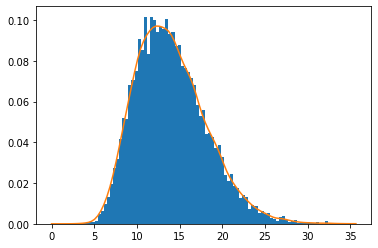

Histogram for F Test feature  1


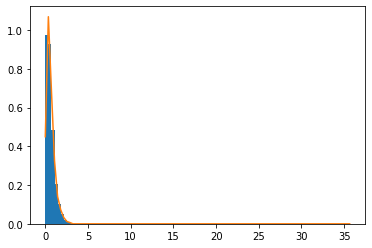

Histogram for F Test feature  2


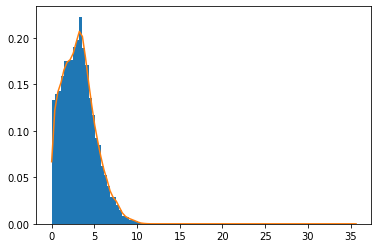

Histogram for F Test feature  3


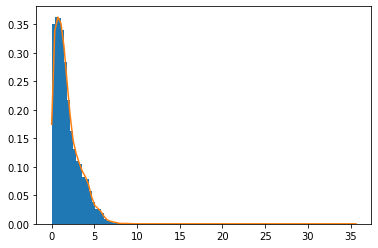

Histogram for F Test feature  4


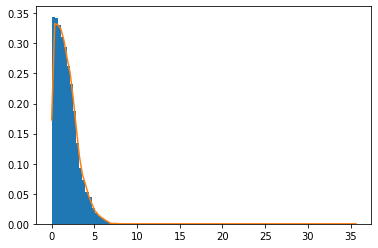

Histogram for F Test feature  5


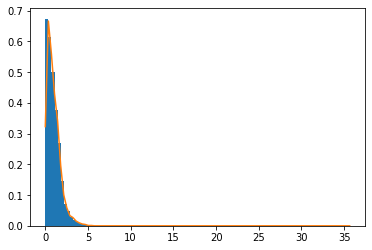

Histogram for F Test feature  6


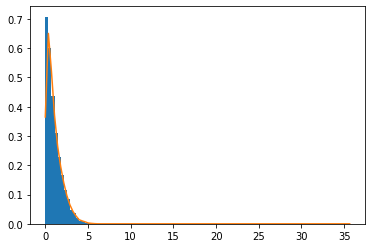

Histogram for F Test feature  7


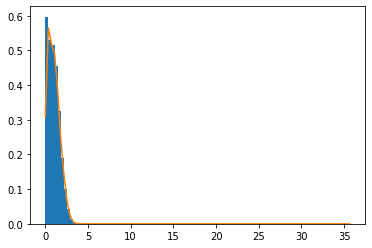

Histogram for F Test feature  8


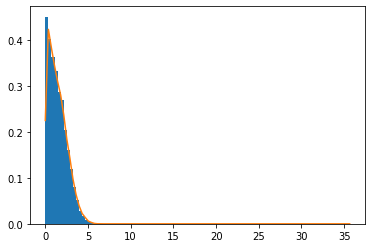

Histogram for F Test feature  9


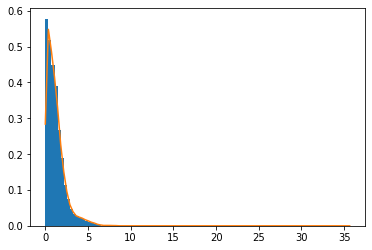

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR Accuracy within training data - All features :  0.97445
LR Accuracy on test data - All features:  0.81155
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.96565
Logistic Regression Accuracy on test data:  0.8413
Accuracy for without feature  1
Logistic Regression Accuracy within training data:  0.97445
Logistic Regression Accuracy on test data:  0.8115
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.97455
Logistic Regression Accuracy on test data:  0.81185
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.964575
Logistic Regression Accuracy on test data:  0.70505
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.949275
Logistic Regression Accuracy on test data:  0.54025
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.974075
Logistic Regression Accuracy on test data:  0.8103
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.973375
Logistic Regression Accuracy on test data:  0.8024
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.941125
Logistic Regression Accuracy on test data:  0.4634
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.974625
Logistic Regression Accuracy on test data:  0.81125
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9739
Logistic Regression Accuracy on test data:  0.80725




Results for lamda  1e-06



array([-1.02398025e+02, -3.76238294e+00, -2.60046273e+00, -2.45605670e+00,
       -1.98472225e+00, -1.72096464e+00, -1.39749781e+00, -1.07005827e+00,
       -9.03401582e-01, -7.19205164e-01, -5.25030637e-01, -4.35576317e-01,
       -4.05345441e-01, -2.53990777e-01, -2.28468377e-01, -1.51284454e-01,
       -1.49029680e-01, -1.42071313e-01, -1.33818671e-01, -1.12721371e-01,
       -1.02896888e-01, -8.74015820e-02, -7.99980986e-02, -6.98434864e-02,
       -6.12811913e-02, -5.71210553e-02, -5.39147181e-02, -4.73893042e-02,
       -4.04313031e-02, -3.84297431e-02, -3.63408007e-02, -3.21762474e-02,
       -2.65001915e-02, -2.50644019e-02, -1.96384613e-02, -1.60537859e-02,
       -1.49483504e-02, -1.45514330e-02, -1.21720579e-02, -1.14750391e-02,
       -1.06262856e-02, -8.45436135e-03, -6.18754840e-03, -5.33497164e-03,
       -4.20447326e-03, -3.63071310e-03, -3.18706873e-03, -2.51625622e-03,
       -2.43939366e-03, -9.28075748e-16])

array([[-0.16594623,  0.30721292,  0.02732175, ..., -0.00916965,
        -0.0053113 ,  0.13980415],
       [-0.12322317,  0.23894667,  0.05215401, ..., -0.00823582,
        -0.03663539, -0.06067927],
       [-0.12384176,  0.19768576, -0.10293604, ...,  0.01542585,
        -0.01462865, -0.06512126],
       ...,
       [-0.17019133,  0.04138804, -0.0313831 , ...,  0.02812492,
         0.00500422,  0.12935665],
       [-0.13313818,  0.07091489, -0.04670005, ...,  0.03705855,
         0.08325108,  0.19125141],
       [-0.14532679, -0.05014929,  0.09767184, ...,  0.2150623 ,
         0.47764664, -0.2233117 ]])

Printing least k eigenvalues before removing the zero eigenvalue
[-102.39802524   -3.76238294   -2.60046273   -2.4560567    -1.98472225
   -1.72096464   -1.39749781   -1.07005827   -0.90340158   -0.71920516]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-102.39802524   -3.76238294   -2.60046273   -2.4560567    -1.98472225
   -1.72096464   -1.39749781   -1.07005827   -0.90340158]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,11.722137,1.034299,1.529748,1.786620,3.374764,0.076097,1.935699,1.281901,3.131436,0.168276
1,12.602412,0.979848,3.763889,0.867045,1.779207,0.696835,0.615313,1.581930,0.313752,0.618475
2,7.978467,0.323752,2.499885,0.713279,1.090525,1.261850,0.581959,0.815188,1.395456,0.039725
3,9.586573,0.391312,2.326014,0.026008,0.583660,0.600640,0.142441,1.177314,1.161834,0.305288
4,19.046872,0.701597,6.915137,3.511761,3.999474,0.126659,1.196305,0.253755,3.030048,0.560365


Histogram for F Test feature  0


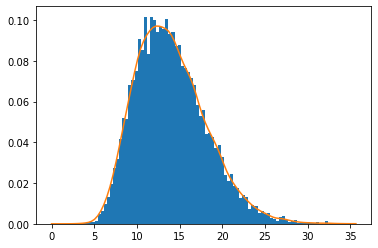

Histogram for F Test feature  1


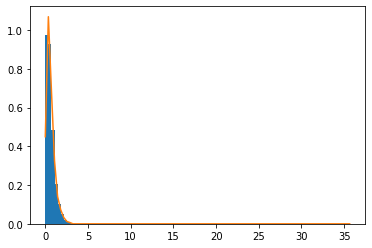

Histogram for F Test feature  2


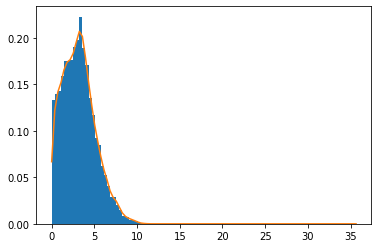

Histogram for F Test feature  3


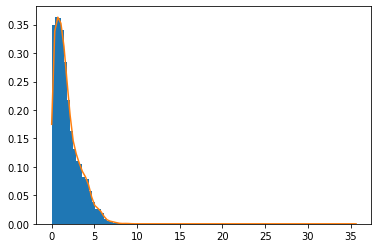

Histogram for F Test feature  4


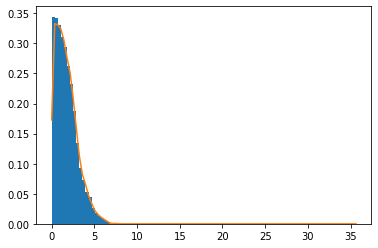

Histogram for F Test feature  5


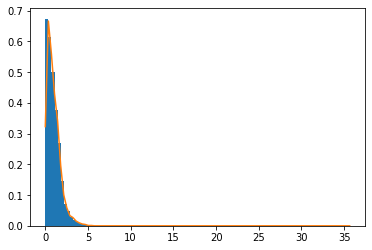

Histogram for F Test feature  6


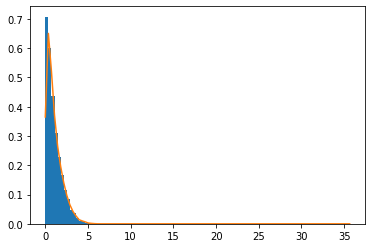

Histogram for F Test feature  7


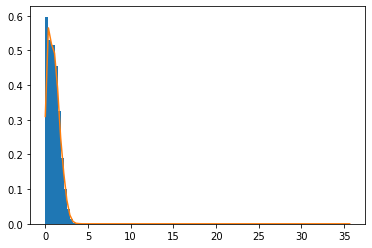

Histogram for F Test feature  8


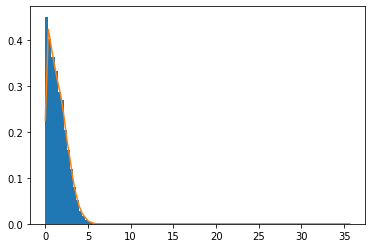

Histogram for F Test feature  9


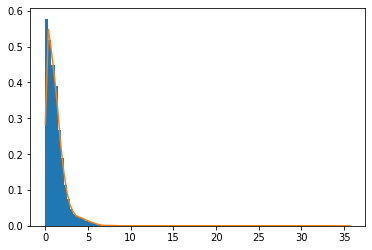

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])
LR Accuracy within training data - All features :  0.97445
LR Accuracy on test data - All features:  0.81155


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy for without feature  0
Logistic Regression Accuracy within training data:  0.96565
Logistic Regression Accuracy on test data:  0.8413
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.97445
Logistic Regression Accuracy on test data:  0.8115
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.97455
Logistic Regression Accuracy on test data:  0.8118
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.964575
Logistic Regression Accuracy on test data:  0.70505
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.949275
Logistic Regression Accuracy on test data:  0.5403
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.974075
Logistic Regression Accuracy on test data:  0.81025
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.973375
Logistic Regression Accuracy on test data:  0.8024
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.941125
Logistic Regression Accuracy on test data:  0.4634
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.974625
Logistic Regression Accuracy on test data:  0.81125
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9739
Logistic Regression Accuracy on test data:  0.80725




Results for lamda  1e-07



array([-1.02398231e+02, -3.76238333e+00, -2.60046332e+00, -2.45605800e+00,
       -1.98472339e+00, -1.72096658e+00, -1.39749897e+00, -1.07005888e+00,
       -9.03402264e-01, -7.19206215e-01, -5.25032563e-01, -4.35577338e-01,
       -4.05346046e-01, -2.53991101e-01, -2.28469443e-01, -1.51284662e-01,
       -1.49029928e-01, -1.42071599e-01, -1.33819980e-01, -1.12724530e-01,
       -1.02897230e-01, -8.74018420e-02, -7.99988932e-02, -6.98438083e-02,
       -6.12813589e-02, -5.71213408e-02, -5.39149851e-02, -4.73903679e-02,
       -4.04317395e-02, -3.84300562e-02, -3.63410450e-02, -3.21768231e-02,
       -2.65003659e-02, -2.50645895e-02, -1.96386617e-02, -1.60540300e-02,
       -1.49488703e-02, -1.45516011e-02, -1.21721196e-02, -1.14752130e-02,
       -1.06263600e-02, -8.45444600e-03, -6.18756506e-03, -5.33500043e-03,
       -4.20448514e-03, -3.63072674e-03, -3.18709592e-03, -2.51627168e-03,
       -2.43943153e-03,  2.59405396e-15])

array([[-0.16594616,  0.30721284,  0.02732328, ..., -0.0091703 ,
        -0.00531048,  0.13980415],
       [-0.12322315,  0.23894654,  0.05215394, ..., -0.00823985,
        -0.03663521, -0.06067927],
       [-0.12384176,  0.19768573, -0.10293603, ...,  0.01542415,
        -0.01462992, -0.06512126],
       ...,
       [-0.17019126,  0.04138815, -0.03138405, ...,  0.02812487,
         0.0050009 ,  0.12935665],
       [-0.13313825,  0.07091491, -0.04670009, ...,  0.03706691,
         0.08324816,  0.19125141],
       [-0.14532687, -0.05014927,  0.09767156, ...,  0.21510911,
         0.47764428, -0.2233117 ]])

Printing least k eigenvalues before removing the zero eigenvalue
[-102.39823072   -3.76238333   -2.60046332   -2.456058     -1.98472339
   -1.72096658   -1.39749897   -1.07005888   -0.90340226   -0.71920622]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-102.39823072   -3.76238333   -2.60046332   -2.456058     -1.98472339
   -1.72096658   -1.39749897   -1.07005888   -0.90340226]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,11.722137,1.034298,1.529750,1.786607,3.374772,0.076099,1.935694,1.281897,3.131438,0.168271
1,12.602412,0.979848,3.763890,0.867039,1.779209,0.696837,0.615313,1.581928,0.313752,0.618474
2,7.978467,0.323752,2.499884,0.713284,1.090524,1.261849,0.581957,0.815187,1.395456,0.039728
3,9.586573,0.391312,2.326014,0.026010,0.583658,0.600641,0.142443,1.177312,1.161834,0.305286
4,19.046872,0.701597,6.915136,3.511746,3.999488,0.126660,1.196301,0.253758,3.030051,0.560361


Histogram for F Test feature  0


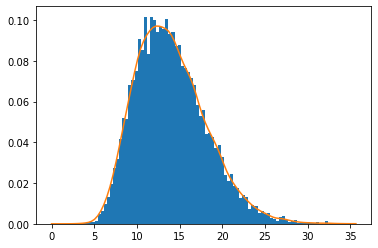

Histogram for F Test feature  1


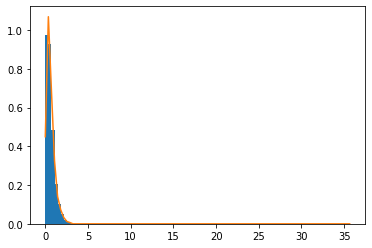

Histogram for F Test feature  2


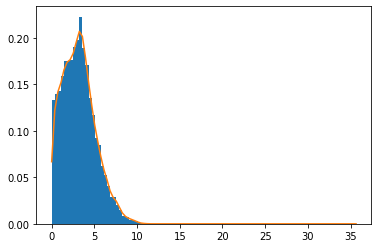

Histogram for F Test feature  3


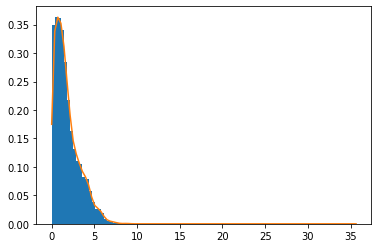

Histogram for F Test feature  4


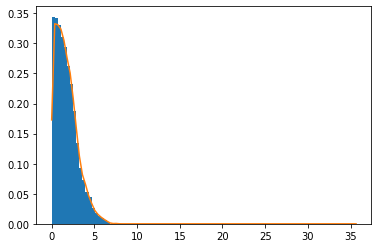

Histogram for F Test feature  5


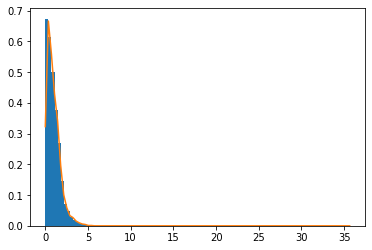

Histogram for F Test feature  6


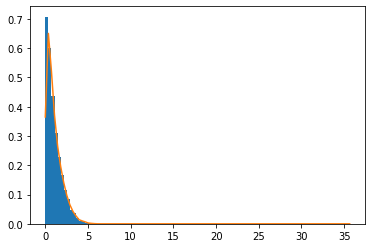

Histogram for F Test feature  7


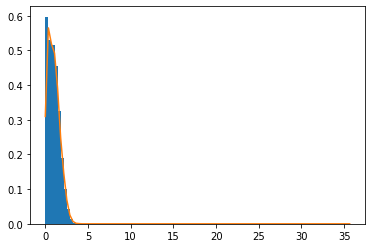

Histogram for F Test feature  8


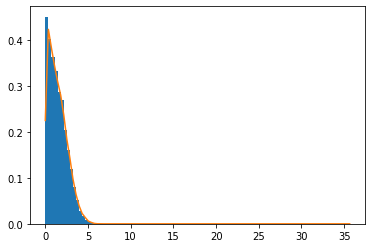

Histogram for F Test feature  9


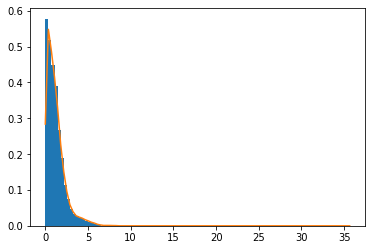

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR Accuracy within training data - All features :  0.97445
LR Accuracy on test data - All features:  0.81155
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.96565
Logistic Regression Accuracy on test data:  0.8413
Accuracy for without feature  1
Logistic Regression Accuracy within training data:  0.97445
Logistic Regression Accuracy on test data:  0.8115
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.97455
Logistic Regression Accuracy on test data:  0.8118
Accuracy for without feature  3
Logistic Regression Accuracy within training data:  0.964575
Logistic Regression Accuracy on test data:  0.70505
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.94925
Logistic Regression Accuracy on test data:  0.5403
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.974075
Logistic Regression Accuracy on test data:  0.81025
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.973375
Logistic Regression Accuracy on test data:  0.8024
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.941125
Logistic Regression Accuracy on test data:  0.4634
Accuracy for without feature  8
Logistic Regression Accuracy within training data:  0.974625
Logistic Regression Accuracy on test data:  0.81125
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9739
Logistic Regression Accuracy on test data:  0.80725




Results for lamda  1e-08



array([-1.02398251e+02, -3.76238337e+00, -2.60046338e+00, -2.45605813e+00,
       -1.98472350e+00, -1.72096677e+00, -1.39749909e+00, -1.07005894e+00,
       -9.03402332e-01, -7.19206320e-01, -5.25032756e-01, -4.35577440e-01,
       -4.05346107e-01, -2.53991133e-01, -2.28469549e-01, -1.51284683e-01,
       -1.49029953e-01, -1.42071628e-01, -1.33820111e-01, -1.12724846e-01,
       -1.02897264e-01, -8.74018680e-02, -7.99989726e-02, -6.98438405e-02,
       -6.12813756e-02, -5.71213694e-02, -5.39150118e-02, -4.73904743e-02,
       -4.04317832e-02, -3.84300875e-02, -3.63410694e-02, -3.21768806e-02,
       -2.65003834e-02, -2.50646083e-02, -1.96386818e-02, -1.60540544e-02,
       -1.49489223e-02, -1.45516178e-02, -1.21721258e-02, -1.14752303e-02,
       -1.06263675e-02, -8.45445447e-03, -6.18756673e-03, -5.33500331e-03,
       -4.20448633e-03, -3.63072810e-03, -3.18709863e-03, -2.51627323e-03,
       -2.43943532e-03,  1.64011566e-15])

array([[-0.16594616,  0.30721283,  0.02732343, ..., -0.00917036,
        -0.00531039,  0.13980415],
       [-0.12322314,  0.23894653,  0.05215394, ..., -0.00824025,
        -0.03663519, -0.06067927],
       [-0.12384175,  0.19768573, -0.10293603, ...,  0.01542398,
        -0.01463005, -0.06512126],
       ...,
       [-0.17019126,  0.04138816, -0.03138414, ...,  0.02812487,
         0.00500056,  0.12935665],
       [-0.13313826,  0.07091492, -0.0467001 , ...,  0.03706775,
         0.08324787,  0.19125141],
       [-0.14532688, -0.05014927,  0.09767153, ...,  0.21511379,
         0.47764404, -0.2233117 ]])

Printing least k eigenvalues before removing the zero eigenvalue
[-102.39825126   -3.76238337   -2.60046338   -2.45605813   -1.9847235
   -1.72096677   -1.39749909   -1.07005894   -0.90340233   -0.71920632]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-102.39825126   -3.76238337   -2.60046338   -2.45605813   -1.9847235
   -1.72096677   -1.39749909   -1.07005894   -0.90340233]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,11.722137,1.034298,1.529750,1.786605,3.374773,0.076099,1.935694,1.281897,3.131439,0.168270
1,12.602412,0.979848,3.763890,0.867038,1.779210,0.696837,0.615313,1.581928,0.313752,0.618474
2,7.978467,0.323752,2.499884,0.713285,1.090523,1.261849,0.581956,0.815186,1.395456,0.039728
3,9.586573,0.391312,2.326014,0.026010,0.583658,0.600641,0.142443,1.177312,1.161834,0.305286
4,19.046872,0.701597,6.915136,3.511744,3.999490,0.126660,1.196300,0.253758,3.030051,0.560360


Histogram for F Test feature  0


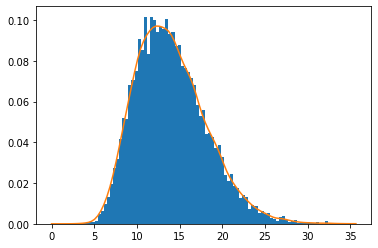

Histogram for F Test feature  1


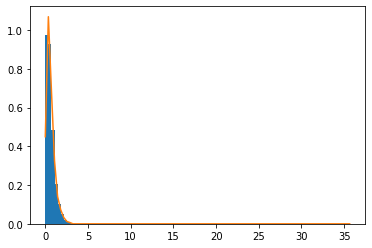

Histogram for F Test feature  2


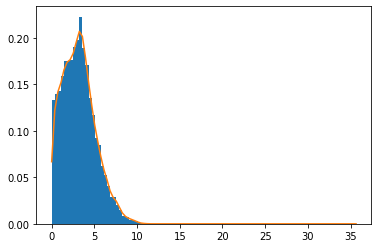

Histogram for F Test feature  3


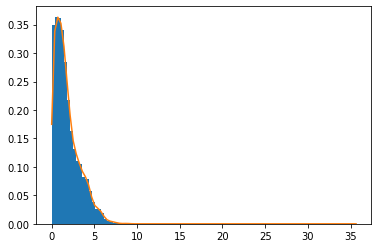

Histogram for F Test feature  4


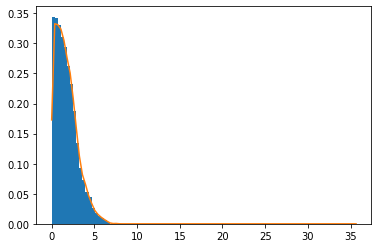

Histogram for F Test feature  5


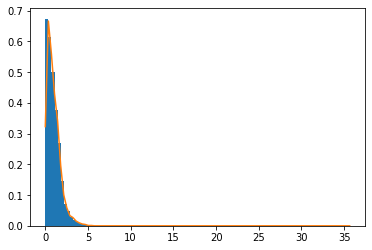

Histogram for F Test feature  6


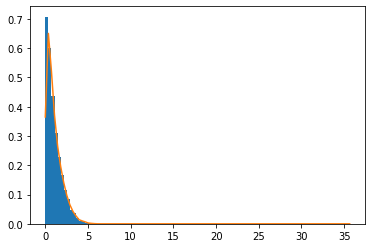

Histogram for F Test feature  7


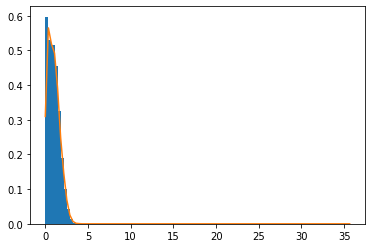

Histogram for F Test feature  8


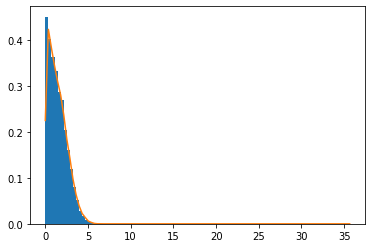

Histogram for F Test feature  9


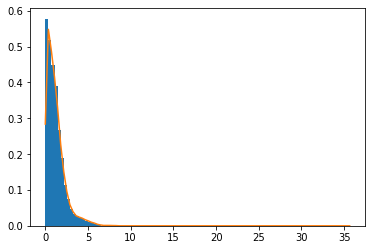

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR Accuracy within training data - All features :  0.97445
LR Accuracy on test data - All features:  0.81155
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.96565
Logistic Regression Accuracy on test data:  0.8413
Accuracy for without feature  1
Logistic Regression Accuracy within training data:  0.97445
Logistic Regression Accuracy on test data:  0.8115
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.97455
Logistic Regression Accuracy on test data:  0.8118
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.964575
Logistic Regression Accuracy on test data:  0.70505
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.94925
Logistic Regression Accuracy on test data:  0.54025
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.974075
Logistic Regression Accuracy on test data:  0.81025
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.973375
Logistic Regression Accuracy on test data:  0.8024
Accuracy for without feature  7
Logistic Regression Accuracy within training data:  0.941125
Logistic Regression Accuracy on test data:  0.4634
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.974625
Logistic Regression Accuracy on test data:  0.81125
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9739
Logistic Regression Accuracy on test data:  0.80725




Results for lamda  1e-09



array([-1.02398253e+02, -3.76238337e+00, -2.60046339e+00, -2.45605815e+00,
       -1.98472351e+00, -1.72096679e+00, -1.39749910e+00, -1.07005894e+00,
       -9.03402339e-01, -7.19206331e-01, -5.25032775e-01, -4.35577450e-01,
       -4.05346113e-01, -2.53991136e-01, -2.28469560e-01, -1.51284685e-01,
       -1.49029956e-01, -1.42071631e-01, -1.33820124e-01, -1.12724878e-01,
       -1.02897268e-01, -8.74018706e-02, -7.99989806e-02, -6.98438437e-02,
       -6.12813773e-02, -5.71213722e-02, -5.39150145e-02, -4.73904849e-02,
       -4.04317875e-02, -3.84300907e-02, -3.63410719e-02, -3.21768864e-02,
       -2.65003851e-02, -2.50646102e-02, -1.96386838e-02, -1.60540569e-02,
       -1.49489275e-02, -1.45516195e-02, -1.21721264e-02, -1.14752321e-02,
       -1.06263682e-02, -8.45445531e-03, -6.18756690e-03, -5.33500359e-03,
       -4.20448645e-03, -3.63072824e-03, -3.18709891e-03, -2.51627338e-03,
       -2.43943570e-03, -2.16418119e-15])

array([[-0.16594616,  0.30721283,  0.02732345, ..., -0.00917037,
        -0.00531038,  0.13980415],
       [-0.12322314,  0.23894653,  0.05215393, ..., -0.00824029,
        -0.03663519, -0.06067927],
       [-0.12384175,  0.19768573, -0.10293603, ...,  0.01542396,
        -0.01463006, -0.06512126],
       ...,
       [-0.17019126,  0.04138816, -0.03138415, ...,  0.02812486,
         0.00500053,  0.12935665],
       [-0.13313826,  0.07091492, -0.0467001 , ...,  0.03706783,
         0.08324784,  0.19125141],
       [-0.14532688, -0.05014927,  0.09767153, ...,  0.21511426,
         0.47764402, -0.2233117 ]])

Printing least k eigenvalues before removing the zero eigenvalue
[-102.39825332   -3.76238337   -2.60046339   -2.45605815   -1.98472351
   -1.72096679   -1.3974991    -1.07005894   -0.90340234   -0.71920633]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-102.39825332   -3.76238337   -2.60046339   -2.45605815   -1.98472351
   -1.72096679   -1.3974991    -1.07005894   -0.90340234]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,11.722137,1.034298,1.529750,1.786605,3.374773,0.076099,1.935694,1.281897,3.131439,0.168270
1,12.602412,0.979848,3.763890,0.867038,1.779210,0.696837,0.615313,1.581927,0.313752,0.618474
2,7.978467,0.323752,2.499884,0.713285,1.090523,1.261849,0.581956,0.815186,1.395456,0.039728
3,9.586573,0.391312,2.326014,0.026010,0.583658,0.600641,0.142443,1.177312,1.161834,0.305286
4,19.046872,0.701597,6.915136,3.511744,3.999490,0.126660,1.196300,0.253758,3.030052,0.560360


Histogram for F Test feature  0


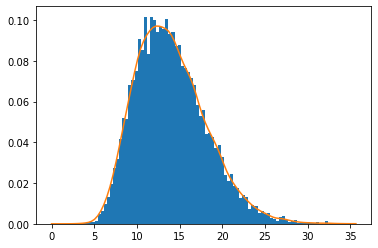

Histogram for F Test feature  1


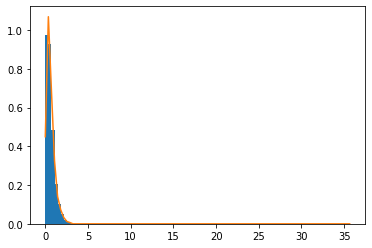

Histogram for F Test feature  2


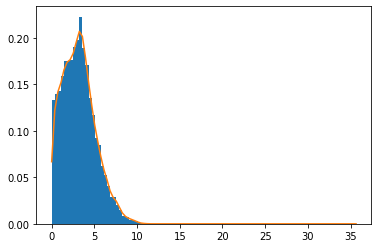

Histogram for F Test feature  3


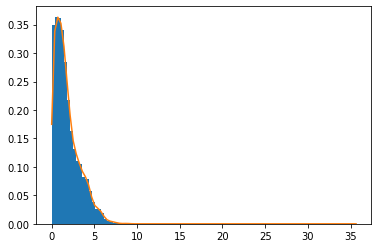

Histogram for F Test feature  4


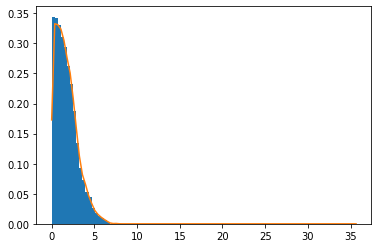

Histogram for F Test feature  5


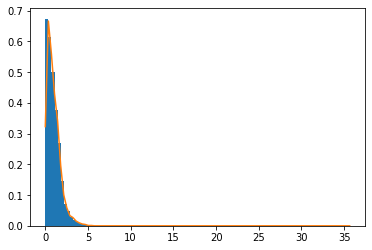

Histogram for F Test feature  6


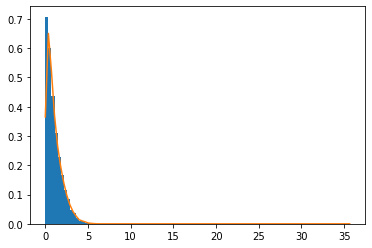

Histogram for F Test feature  7


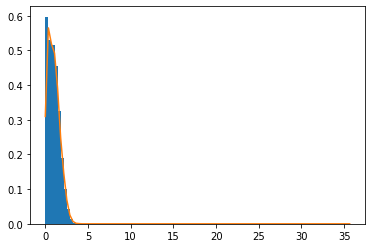

Histogram for F Test feature  8


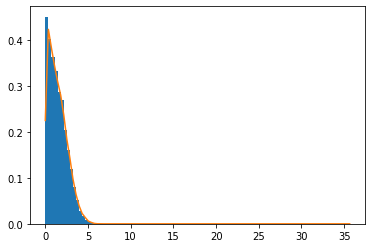

Histogram for F Test feature  9


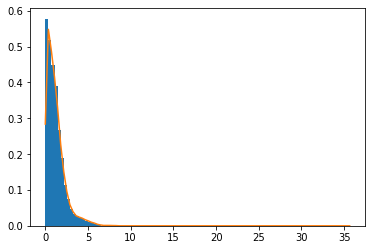

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR Accuracy within training data - All features :  0.97445
LR Accuracy on test data - All features:  0.81155
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.96565
Logistic Regression Accuracy on test data:  0.8413
Accuracy for without feature  1
Logistic Regression Accuracy within training data:  0.97445
Logistic Regression Accuracy on test data:  0.8115
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.97455
Logistic Regression Accuracy on test data:  0.8118
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.964575
Logistic Regression Accuracy on test data:  0.70505
Accuracy for without feature  4
Logistic Regression Accuracy within training data:  0.94925
Logistic Regression Accuracy on test data:  0.5403
Accuracy for without feature  5
Logistic Regression Accuracy within training data:  0.974075
Logistic Regression Accuracy on test data:  0.81025
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.973375
Logistic Regression Accuracy on test data:  0.8024
Accuracy for without feature  7
Logistic Regression Accuracy within training data:  0.941125
Logistic Regression Accuracy on test data:  0.4634
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.974625
Logistic Regression Accuracy on test data:  0.81125
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9739
Logistic Regression Accuracy on test data:  0.80725




Results for lamda  1e-10



array([-1.02398254e+02, -3.76238337e+00, -2.60046339e+00, -2.45605815e+00,
       -1.98472351e+00, -1.72096680e+00, -1.39749910e+00, -1.07005894e+00,
       -9.03402340e-01, -7.19206332e-01, -5.25032777e-01, -4.35577451e-01,
       -4.05346113e-01, -2.53991137e-01, -2.28469561e-01, -1.51284685e-01,
       -1.49029956e-01, -1.42071631e-01, -1.33820125e-01, -1.12724881e-01,
       -1.02897268e-01, -8.74018709e-02, -7.99989814e-02, -6.98438440e-02,
       -6.12813775e-02, -5.71213725e-02, -5.39150148e-02, -4.73904860e-02,
       -4.04317880e-02, -3.84300910e-02, -3.63410721e-02, -3.21768869e-02,
       -2.65003853e-02, -2.50646103e-02, -1.96386840e-02, -1.60540571e-02,
       -1.49489280e-02, -1.45516197e-02, -1.21721265e-02, -1.14752323e-02,
       -1.06263683e-02, -8.45445540e-03, -6.18756691e-03, -5.33500362e-03,
       -4.20448646e-03, -3.63072825e-03, -3.18709893e-03, -2.51627340e-03,
       -2.43943574e-03,  6.13854768e-16])

array([[-0.16594616,  0.30721283,  0.02732345, ..., -0.00917037,
        -0.00531038,  0.13980415],
       [-0.12322314,  0.23894653,  0.05215393, ..., -0.00824029,
        -0.03663519, -0.06067927],
       [-0.12384175,  0.19768573, -0.10293603, ...,  0.01542396,
        -0.01463006, -0.06512126],
       ...,
       [-0.17019126,  0.04138816, -0.03138415, ...,  0.02812486,
         0.00500053,  0.12935665],
       [-0.13313826,  0.07091492, -0.0467001 , ...,  0.03706784,
         0.08324784,  0.19125141],
       [-0.14532688, -0.05014927,  0.09767153, ...,  0.2151143 ,
         0.47764401, -0.2233117 ]])

Printing least k eigenvalues before removing the zero eigenvalue
[-102.39825352   -3.76238337   -2.60046339   -2.45605815   -1.98472351
   -1.7209668    -1.3974991    -1.07005894   -0.90340234   -0.71920633]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-102.39825352   -3.76238337   -2.60046339   -2.45605815   -1.98472351
   -1.7209668    -1.3974991    -1.07005894   -0.90340234]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,11.722137,1.034298,1.529750,1.786605,3.374773,0.076099,1.935694,1.281897,3.131439,0.168270
1,12.602412,0.979848,3.763890,0.867038,1.779210,0.696838,0.615313,1.581927,0.313752,0.618474
2,7.978467,0.323752,2.499884,0.713285,1.090523,1.261849,0.581956,0.815186,1.395456,0.039728
3,9.586573,0.391312,2.326014,0.026010,0.583658,0.600641,0.142443,1.177312,1.161834,0.305286
4,19.046872,0.701597,6.915136,3.511744,3.999490,0.126660,1.196300,0.253758,3.030052,0.560360


Histogram for F Test feature  0


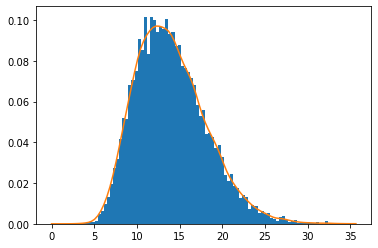

Histogram for F Test feature  1


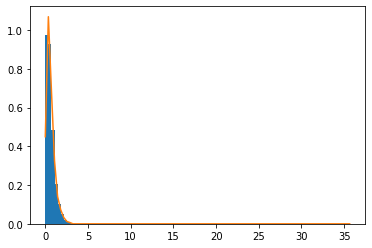

Histogram for F Test feature  2


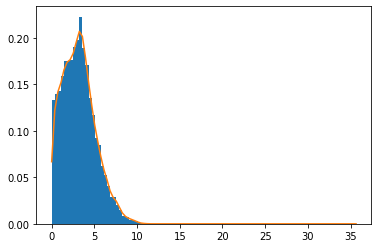

Histogram for F Test feature  3


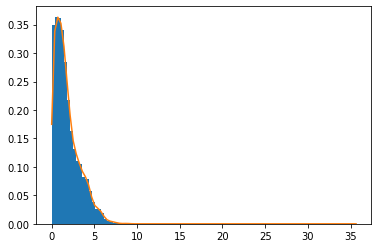

Histogram for F Test feature  4


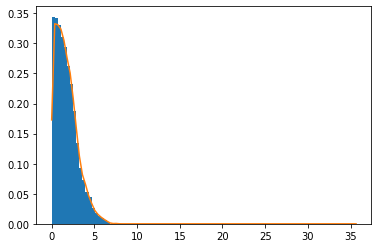

Histogram for F Test feature  5


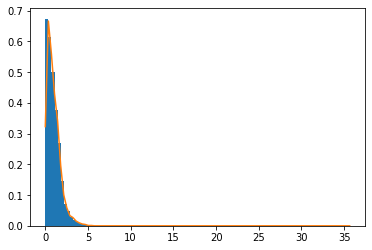

Histogram for F Test feature  6


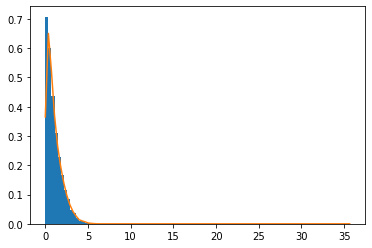

Histogram for F Test feature  7


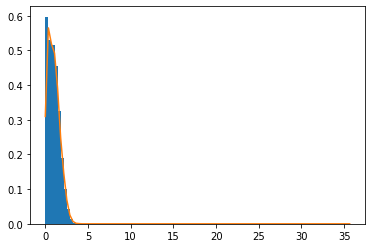

Histogram for F Test feature  8


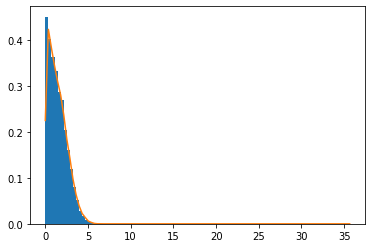

Histogram for F Test feature  9


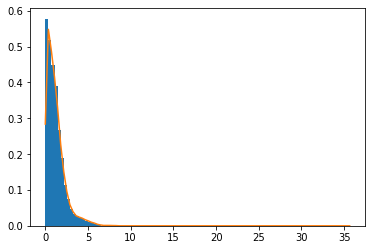

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR Accuracy within training data - All features :  0.97445
LR Accuracy on test data - All features:  0.81155
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.96565
Logistic Regression Accuracy on test data:  0.8413
Accuracy for without feature  1
Logistic Regression Accuracy within training data:  0.97445
Logistic Regression Accuracy on test data:  0.8115
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.97455
Logistic Regression Accuracy on test data:  0.8118
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.964575
Logistic Regression Accuracy on test data:  0.70505
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.94925
Logistic Regression Accuracy on test data:  0.5403
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.974075
Logistic Regression Accuracy on test data:  0.81025
Accuracy for without feature  6
Logistic Regression Accuracy within training data:  0.973375
Logistic Regression Accuracy on test data:  0.8024
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.941125
Logistic Regression Accuracy on test data:  0.4634
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.974625
Logistic Regression Accuracy on test data:  0.81125
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9739
Logistic Regression Accuracy on test data:  0.80725


In [23]:
# Computing M
lamdas = [100000,10,9,8,7,6,5,4,3,2,1,0.1,0.01,0.001,0.0001,0.00001,0.000001,0.0000001,0.00000001,0.000000001,0.0000000001]

for lamda in lamdas:
    print()
    print()
    print()
    print()
    print("Results for lamda ", lamda)
    print()
    k = int(Z.shape[1]*0.2) # 20% of original number of features
    n = Z.shape[0]
    delta_Z_matrix = np.absolute((Z[:int(len(color)/2),:] - Z[int(len(color)/2):,:]))
    M = - Z.T @ Z/n + lamda * delta_Z_matrix.T @ delta_Z_matrix / (n // 2 ) 


    # Computing the term on which we perform SVD
    alpha_alpha_T = color_coefficients @ color_coefficients.T
    d = alpha_alpha_T.shape[0]
    I = np.identity(d)
    I_minus_alpa_alpha_T = I-alpha_alpha_T
    term_for_SVD = (I_minus_alpa_alpha_T @ M) @ I_minus_alpa_alpha_T


    # Performing SVD to get eigenvectors and eigenvalues
    from numpy import linalg as LA
    eigenvalues, eigenvectors = LA.eigh(term_for_SVD)
    display(eigenvalues)
    display(eigenvectors)

    # Forming L from eigenvectors and alpha
    L_1 = color_coefficients
    least_k_eigen_values = eigenvalues[:k]
    least_k_eigen_values[np.absolute(least_k_eigen_values)<0.000001]=0

    print("Printing least k eigenvalues before removing the zero eigenvalue")
    print(least_k_eigen_values)

    non_zero_indeces = None
    if 0 in least_k_eigen_values:
        non_zero_indeces = np.nonzero(least_k_eigen_values)[0]
        least_k_eigen_values_without_0 = least_k_eigen_values[non_zero_indeces]
        print("Printing least k-1 eigenvalues after removing the zero eigenvalue")
        print(least_k_eigen_values_without_0)

    else:
        non_zero_indeces = np.nonzero(least_k_eigen_values[:k-1])[0]
        least_k_eigen_values_without_0 = least_k_eigen_values[:k-1]
        print("Printing least k-1 eigenvalues after removing the zero eigenvalue")
        print(least_k_eigen_values_without_0)

    print("Printing non zero indeces of the least k-1 eigenvalues") 
    print(non_zero_indeces) #

    L_2 = eigenvectors[:,non_zero_indeces]

    # print(L_2.shape)

    L = np.concatenate((L_1, L_2), axis=1)

    # print(L.shape)




    # Obtaining F_test values from extracted image features using numpy's linalg.lstsq function.
    F = torch.from_numpy(np.linalg.lstsq(L, Z.transpose(), rcond=None)[0].transpose())
    F_test = torch.from_numpy(np.linalg.lstsq(L, Z_test.transpose(), rcond=None)[0].transpose())
    F_test_green = torch.from_numpy(np.linalg.lstsq(L, Z_test_green.transpose(), rcond=None)[0].transpose())
    F_test_red = torch.from_numpy(np.linalg.lstsq(L, Z_test_red.transpose(), rcond=None)[0].transpose())

    F_envs_1_and_2 = torch.from_numpy(np.linalg.lstsq(L, Z_envs_1_and_2.transpose(), rcond=None)[0].transpose())
    F_env3 = torch.from_numpy(np.linalg.lstsq(L, Z_env3.transpose(), rcond=None)[0].transpose())


    # Plot histograms

    # the difference between F_test_green and F_test_red
    delta_matrix = np.absolute(F_test_green.detach().numpy() - F_test_red.detach().numpy())

    print("Printing the delta matrix")
    delta_matrix_df = pd.DataFrame(delta_matrix)
    display(delta_matrix_df.head())

    # Plotting the histograms for each feature in the delta matrix # 100 bins
    for i in range(len(delta_matrix_df.columns)): 
        print("Histogram for F Test feature ", i)    
        feature = delta_matrix_df.iloc[:,i].values
        density = stats.gaussian_kde(feature)
        n, x, _ = plt.hist(feature, bins=np.linspace(0, np.amax(delta_matrix_df.iloc[:,0]), 100), 
                           histtype='bar', density=True)  
        plt.plot(x, density(x))
        plt.show()
        
                
    
    
    
    # Predicting label when trained on all F_envs_1_and_2 and tested on all F_env3 features including 
    # color - Environment Shift Present - Logistic Regression
    # Using sklearn Logistic Regression
    from sklearn.linear_model import LogisticRegression

    import torch
    from sklearn import preprocessing



    train_data_path = train_extracted_features_df
    test_data_path = test_extracted_features_df


    def read_data(path):
        data_df = path.to_numpy()

        targets = data_df[:, -1] 
        X = data_df[:, :-1] 

        # Standardize the data
        sscaler = preprocessing.StandardScaler()
        sscaler.fit(X)
        X = sscaler.transform(X)


        X_torch = torch.from_numpy(X)
        targets_torch = torch.from_numpy(targets)
        return X_torch, targets_torch



    _, targets_torch_train = read_data(train_data_path)
    _, targets_torch_test = read_data(test_data_path)


    X_torch_train = F_envs_1_and_2
    X_torch_test = F_env3
    X_torch_test_within = F_envs_1_and_2

    targets_torch_train = targets_torch_train.reshape(-1,1)
    targets_torch_test = targets_torch_test.reshape(-1,1)
    targets_torch_test_within = targets_torch_train.reshape(-1,1)


    print("Printing the shape of the input!")
    print(X_torch_train.shape)

    print("Printing the shape of the target!")
    print(targets_torch_train.shape)


    logistic_regression_model = LogisticRegression(random_state=0).fit(X_torch_train.detach().numpy(), targets_torch_train.numpy())

    print('LR Accuracy within training data - All features : ',logistic_regression_model.score(X_torch_test_within.detach().numpy(), targets_torch_test_within.numpy()))
    print('LR Accuracy on test data - All features: ', logistic_regression_model.score(X_torch_test.detach().numpy(), targets_torch_test.numpy()))

    
    


    # Predicting label when trained on all F_envs_1_and_2 and tested on all F_env3 features except 
    # color - Environment Shift Present - Logistic Regression

    # Using sklearn Logistic Regression
    from sklearn.linear_model import LogisticRegression

    import torch
    from sklearn import preprocessing

    train_data_path = train_extracted_features_df
    test_data_path = test_extracted_features_df


    def read_data(path):
        data_df = path.to_numpy()

        targets = data_df[:, -1] 
        X = data_df[:, :-1] 

        # Standardize the data
        sscaler = preprocessing.StandardScaler()
        sscaler.fit(X)
        X = sscaler.transform(X)


        X_torch = torch.from_numpy(X)
        targets_torch = torch.from_numpy(targets)
        return X_torch, targets_torch



    _, targets_torch_train = read_data(train_data_path)
    _, targets_torch_test = read_data(test_data_path)


    targets_torch_train = targets_torch_train.reshape(-1,1)
    targets_torch_test = targets_torch_test.reshape(-1,1)
    targets_torch_test_within = targets_torch_train.reshape(-1,1)

    for i in range(F_envs_1_and_2.detach().numpy().shape[1]):
        print("Accuracy for without feature ",i)

        X_torch_train = F_envs_1_and_2.detach().numpy().copy()
        X_torch_test = F_env3.detach().numpy().copy()
        X_torch_test_within = F_envs_1_and_2.detach().numpy().copy()

        X_torch_train = np.delete(X_torch_train, i, 1)
        X_torch_test = np.delete(X_torch_test, i, 1)
        X_torch_test_within = np.delete(X_torch_test_within, i, 1)


        logistic_regression_model = LogisticRegression(random_state=0).fit(X_torch_train, targets_torch_train.numpy())

        print('Logistic Regression Accuracy within training data: ',logistic_regression_model.score(X_torch_test_within, targets_torch_test_within.numpy()))
        print('Logistic Regression Accuracy on test data: ', logistic_regression_model.score(X_torch_test, targets_torch_test.numpy()))




